<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/delta_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount you Google drive to access the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/HumanData/utils')

In [3]:
!pip install librosa pydub snntorch tqdm matplotlib torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 6.4 MB/s eta 0:00:00


In [4]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary
from snntorch import surrogate, functional

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time
import itertools
import random
import json
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [5]:
from preprocessing import SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, DURATION
from preprocessing import (
    load_audio_file,
    naa,
    preprocess_audio,
    batch_logmel,
    pad_to_multiple_of,
    preprocess_dataset
)

from spike_encoding import (
    DeltaAudioDataset,
    ThresholdAdaptiveDataset,
    StepForwardDataset,
    visualize_spike_trains
)

from train_eval import (
    train_fn,
    evaluate_model_comprehensive
)

from models import (
    SNNClassifier,
    C_SNN
)

from performance_analysis import (
    PerformanceProfiler,
    run_performance_evaluation
)

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Save best models

In [8]:
os.makedirs('/content/drive/MyDrive/HumanData/best_models', exist_ok=True)

### Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [ ]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [9]:
# Labels ESC-10
class ESCLabels:
    class_names = [
        'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
        'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
    ]
    label_to_index = {label: idx for idx, label in enumerate(class_names)}
    index_to_label = {idx: label for label, idx in label_to_index.items()}


In [10]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100
DURATION = 5.0

In [11]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [03:24<00:00, 20.47s/it]


In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.4, random_state=42, stratify=y_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 240, Val: 80, Test: 80


# Preprocessing



In [13]:
X_train_tensor, y_train_tensor = preprocess_dataset(X_train, y_train, apply_naa=True, apply_taa=False)
X_val_tensor, y_val_tensor = preprocess_dataset(X_val, y_val, apply_naa=False, apply_taa=False)
X_test_tensor, y_test_tensor = preprocess_dataset(X_test, y_test, apply_naa=False, apply_taa=False)

Log-Mel: 100%|██████████| 80/80 [00:00<00:00, 92.58it/s]


Shape verification

In [14]:
print("X_train:", X_train_tensor.shape, "| y_train:", y_train_tensor.shape)
print("X_val:  ", X_val_tensor.shape, "| y_val:  ", y_val_tensor.shape)
print("X_test: ", X_test_tensor.shape, "| y_test: ", y_test_tensor.shape)

X_train: torch.Size([1200, 128, 450, 1]) | y_train: torch.Size([1200])
X_val:   torch.Size([80, 128, 450, 1]) | y_val:   torch.Size([80])
X_test:  torch.Size([80, 128, 450, 1]) | y_test:  torch.Size([80])


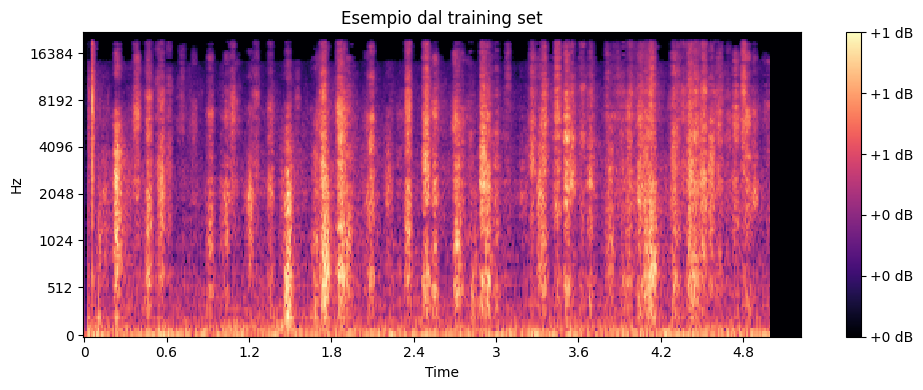

Class: crackling_fire


In [15]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    if isinstance(mel, torch.Tensor):
        mel = mel.squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_tensor[sample_idx], title="Esempio dal training set")
print("Class:", ESCLabels.index_to_label[y_train_tensor[sample_idx].item()])


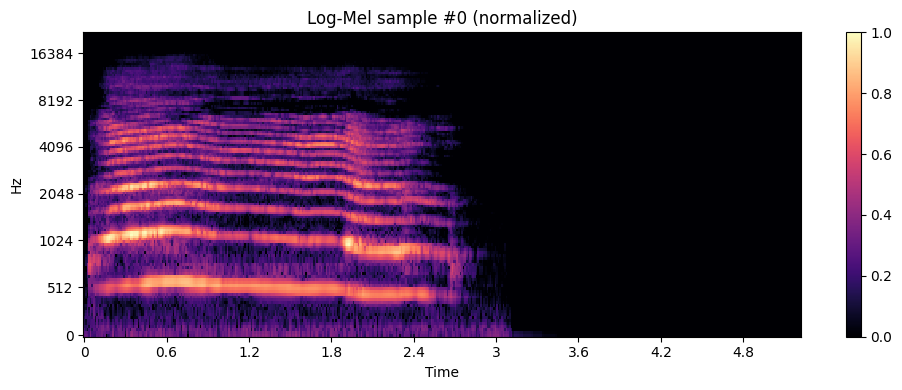

Class: crying_baby


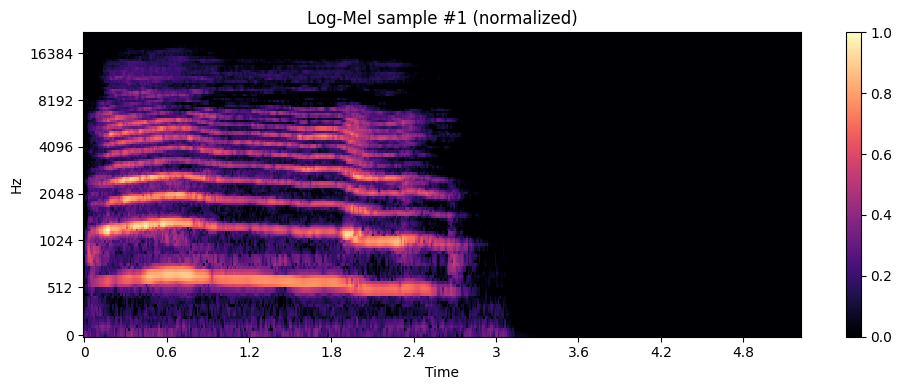

Class: crying_baby


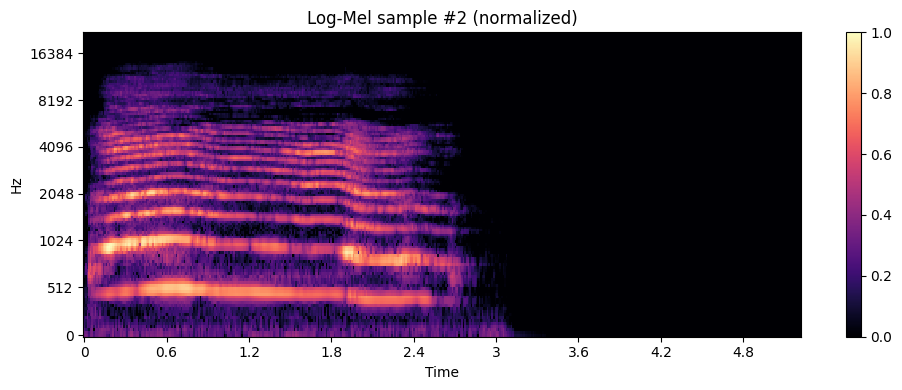

Class: crying_baby


In [16]:
def show_mel_sample(index):
    mel = X_train_tensor[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels.index_to_label[y_train_tensor[index].item()])

for i in range(3):
    show_mel_sample(i)

#Parameters for training:

In [17]:
patience = 30
num_epochs = 100
hidden_sizes = [128, 128, 128]
num_classes = 10
BATCH_SIZE = 32

# Spike Encoding: Delta Modulation

In [18]:
THRESHOLD = 0.05
TIMESTEPS = 200

In [19]:
delta_train_dataset = DeltaAudioDataset(X_train_tensor, y_train_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_val_dataset = DeltaAudioDataset(X_val_tensor, y_val_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)
delta_test_dataset = DeltaAudioDataset(X_test_tensor, y_test_tensor, threshold=THRESHOLD, timesteps=TIMESTEPS)

In [20]:
delta_train_loader = DataLoader(delta_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
delta_val_loader = DataLoader(delta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
delta_test_loader = DataLoader(delta_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())

In [21]:
delta_X_batch, delta_y_batch = next(iter(delta_train_loader))
print("DeltaModulation encoding compleated!")

DeltaModulation encoding compleated!


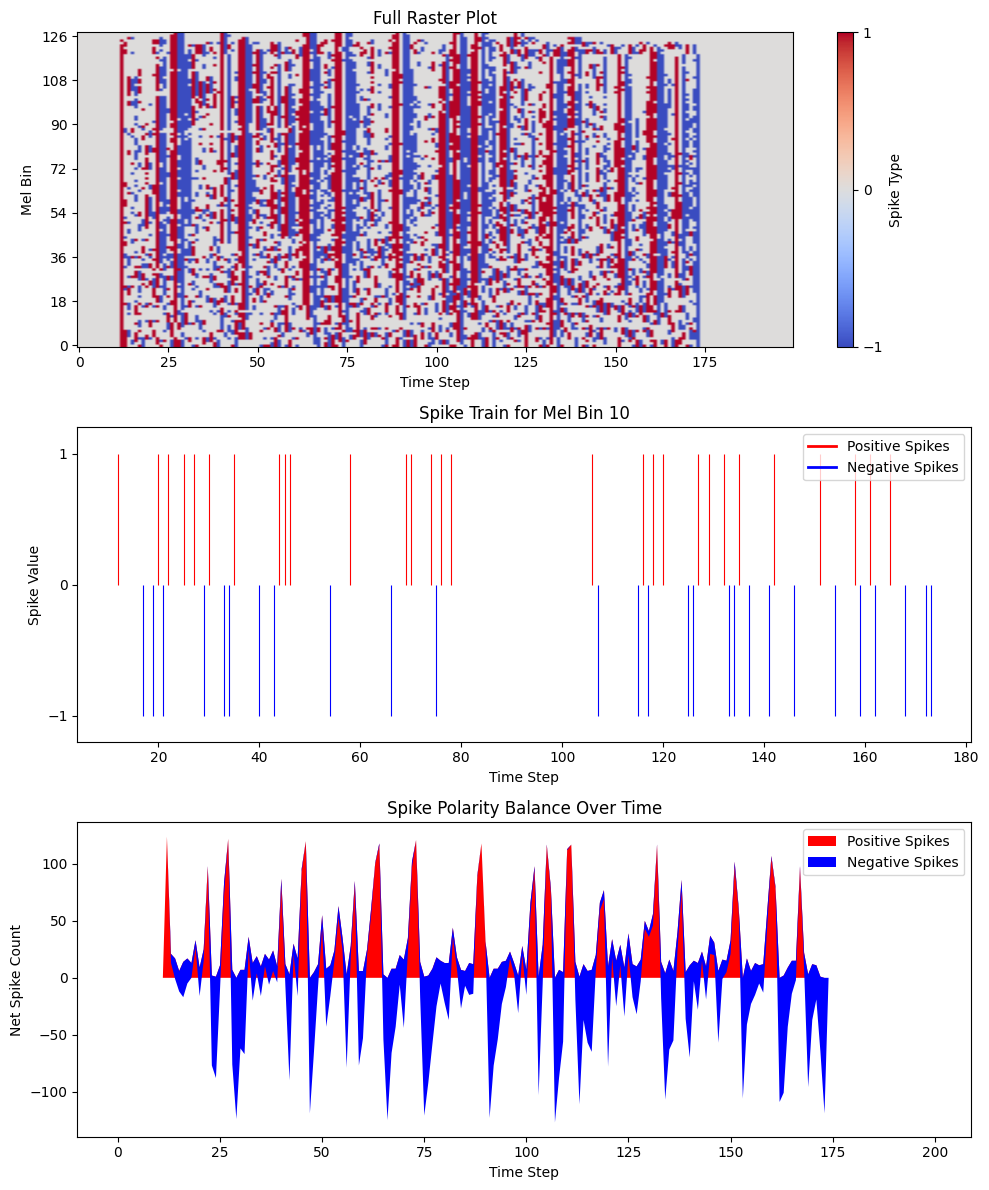

Delta Class: crackling_fire


In [22]:
sample_idx = 10
visualize_spike_trains(delta_X_batch, sample_idx=sample_idx, mel_bin=10)
print(f"Delta Class: {ESCLabels.index_to_label[delta_y_batch[sample_idx].item()]}")

##Delta Modulation: SNN training

In [23]:
delta_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(delta_snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [24]:
optimizer = torch.optim.Adam(delta_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=delta_snn_classifier,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/content/drive/MyDrive/HumanData/utils/train_eval.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [00:43<00:00,  1.00it/s]
                                                              /content/drive/MyDrive/HumanData/utils/train_eval.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [00:45<1:14:31, 45.17s/it]


Epoch 1/100 - 45s - loss: 2.3026 - acc: 0.0987 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [01:30<1:14:23, 45.54s/it]


Epoch 2/100 - 45s - loss: 2.3026 - acc: 0.0987 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   3%|▎         | 3/100 [02:15<1:12:54, 45.10s/it]


Epoch 3/100 - 44s - loss: 2.3026 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   4%|▍         | 4/100 [03:01<1:12:29, 45.31s/it]


Epoch 4/100 - 45s - loss: 2.2720 - acc: 0.1546 - val_loss: 2.2503 - val_acc: 0.1354



Epochs:   5%|▌         | 5/100 [03:46<1:11:42, 45.29s/it]


Epoch 5/100 - 45s - loss: 2.3127 - acc: 0.1521 - val_loss: 2.2938 - val_acc: 0.0938



Epochs:   6%|▌         | 6/100 [04:32<1:11:11, 45.44s/it]


Epoch 6/100 - 45s - loss: 2.2782 - acc: 0.1694 - val_loss: 2.2210 - val_acc: 0.1562



Epochs:   7%|▋         | 7/100 [05:17<1:10:19, 45.37s/it]


Epoch 7/100 - 45s - loss: 2.1549 - acc: 0.2155 - val_loss: 2.2303 - val_acc: 0.2396



Epochs:   8%|▊         | 8/100 [06:03<1:09:41, 45.45s/it]


Epoch 8/100 - 45s - loss: 2.0839 - acc: 0.2475 - val_loss: 2.0933 - val_acc: 0.2708



Epochs:   9%|▉         | 9/100 [06:47<1:08:28, 45.15s/it]


Epoch 9/100 - 44s - loss: 2.1790 - acc: 0.2977 - val_loss: 3.5447 - val_acc: 0.3021



Epochs:  10%|█         | 10/100 [07:33<1:07:53, 45.27s/it]


Epoch 10/100 - 45s - loss: 2.1302 - acc: 0.2985 - val_loss: 2.3070 - val_acc: 0.3229



Epochs:  11%|█         | 11/100 [08:18<1:07:03, 45.20s/it]


Epoch 11/100 - 45s - loss: 2.1827 - acc: 0.3191 - val_loss: 3.3760 - val_acc: 0.3333



Epochs:  12%|█▏        | 12/100 [09:02<1:06:07, 45.08s/it]


Epoch 12/100 - 44s - loss: 2.6099 - acc: 0.3183 - val_loss: 2.7022 - val_acc: 0.2500



Epochs:  13%|█▎        | 13/100 [09:48<1:05:41, 45.30s/it]


Epoch 13/100 - 45s - loss: 2.4421 - acc: 0.3487 - val_loss: 2.3437 - val_acc: 0.3333



Epochs:  14%|█▍        | 14/100 [10:33<1:04:40, 45.12s/it]


Epoch 14/100 - 44s - loss: 2.2329 - acc: 0.3520 - val_loss: 3.0629 - val_acc: 0.3229



Epochs:  15%|█▌        | 15/100 [11:19<1:04:22, 45.44s/it]


Epoch 15/100 - 46s - loss: 1.9870 - acc: 0.3931 - val_loss: 2.1741 - val_acc: 0.4375



Epochs:  16%|█▌        | 16/100 [12:04<1:03:18, 45.22s/it]


Epoch 16/100 - 44s - loss: 1.8699 - acc: 0.4334 - val_loss: 2.2197 - val_acc: 0.4375



Epochs:  17%|█▋        | 17/100 [12:49<1:02:41, 45.32s/it]


Epoch 17/100 - 45s - loss: 1.8369 - acc: 0.4334 - val_loss: 1.6402 - val_acc: 0.4271



Epochs:  18%|█▊        | 18/100 [13:34<1:01:51, 45.26s/it]


Epoch 18/100 - 45s - loss: 1.4868 - acc: 0.4819 - val_loss: 1.5899 - val_acc: 0.5104



Epochs:  19%|█▉        | 19/100 [14:20<1:01:16, 45.39s/it]


Epoch 19/100 - 45s - loss: 1.3357 - acc: 0.4992 - val_loss: 1.6758 - val_acc: 0.4583



Epochs:  20%|██        | 20/100 [15:05<1:00:18, 45.23s/it]


Epoch 20/100 - 44s - loss: 1.3293 - acc: 0.5197 - val_loss: 1.3769 - val_acc: 0.5208



Epochs:  21%|██        | 21/100 [15:51<59:57, 45.54s/it]  


Epoch 21/100 - 46s - loss: 1.2677 - acc: 0.5230 - val_loss: 1.9568 - val_acc: 0.4375



Epochs:  22%|██▏       | 22/100 [16:36<58:57, 45.35s/it]


Epoch 22/100 - 44s - loss: 1.2569 - acc: 0.5428 - val_loss: 1.7414 - val_acc: 0.4479



Epochs:  23%|██▎       | 23/100 [17:22<58:11, 45.35s/it]


Epoch 23/100 - 45s - loss: 1.2248 - acc: 0.5411 - val_loss: 1.6502 - val_acc: 0.5104



Epochs:  24%|██▍       | 24/100 [18:08<57:56, 45.75s/it]


Epoch 24/100 - 46s - loss: 1.1010 - acc: 0.5567 - val_loss: 1.5170 - val_acc: 0.5729



Epochs:  25%|██▌       | 25/100 [18:54<57:14, 45.80s/it]


Epoch 25/100 - 45s - loss: 1.0197 - acc: 0.6151 - val_loss: 1.6176 - val_acc: 0.4792



Epochs:  26%|██▌       | 26/100 [19:39<56:15, 45.61s/it]


Epoch 26/100 - 45s - loss: 1.0620 - acc: 0.6069 - val_loss: 1.5520 - val_acc: 0.6042



Epochs:  27%|██▋       | 27/100 [20:26<55:45, 45.83s/it]


Epoch 27/100 - 46s - loss: 0.9838 - acc: 0.6308 - val_loss: 1.7189 - val_acc: 0.5000



Epochs:  28%|██▊       | 28/100 [21:11<54:43, 45.61s/it]


Epoch 28/100 - 45s - loss: 0.9251 - acc: 0.6521 - val_loss: 1.5847 - val_acc: 0.5938



Epochs:  29%|██▉       | 29/100 [21:56<53:46, 45.44s/it]


Epoch 29/100 - 45s - loss: 0.8863 - acc: 0.6669 - val_loss: 1.2219 - val_acc: 0.6042



Epochs:  30%|███       | 30/100 [22:42<53:13, 45.63s/it]


Epoch 30/100 - 46s - loss: 0.7965 - acc: 0.6990 - val_loss: 1.2635 - val_acc: 0.6562



Epochs:  31%|███       | 31/100 [23:27<52:09, 45.35s/it]


Epoch 31/100 - 44s - loss: 0.7686 - acc: 0.7146 - val_loss: 1.3969 - val_acc: 0.6146



Epochs:  32%|███▏      | 32/100 [24:12<51:29, 45.44s/it]


Epoch 32/100 - 45s - loss: 0.6857 - acc: 0.7188 - val_loss: 1.7285 - val_acc: 0.5208



Epochs:  33%|███▎      | 33/100 [24:58<50:42, 45.42s/it]


Epoch 33/100 - 45s - loss: 0.7714 - acc: 0.7368 - val_loss: 1.4648 - val_acc: 0.6042



Epochs:  34%|███▍      | 34/100 [25:43<50:00, 45.47s/it]


Epoch 34/100 - 45s - loss: 0.5893 - acc: 0.7804 - val_loss: 1.3890 - val_acc: 0.6042



Epochs:  35%|███▌      | 35/100 [26:28<49:02, 45.27s/it]


Epoch 35/100 - 44s - loss: 0.5955 - acc: 0.7780 - val_loss: 1.9024 - val_acc: 0.5417



Epochs:  36%|███▌      | 36/100 [27:14<48:39, 45.62s/it]


Epoch 36/100 - 46s - loss: 0.5535 - acc: 0.7969 - val_loss: 1.6693 - val_acc: 0.5417



Epochs:  37%|███▋      | 37/100 [27:59<47:36, 45.34s/it]


Epoch 37/100 - 44s - loss: 0.5711 - acc: 0.7862 - val_loss: 1.4192 - val_acc: 0.5312



Epochs:  38%|███▊      | 38/100 [28:45<46:58, 45.46s/it]


Epoch 38/100 - 45s - loss: 0.5349 - acc: 0.8150 - val_loss: 1.6018 - val_acc: 0.6354



Epochs:  39%|███▉      | 39/100 [29:30<46:09, 45.41s/it]


Epoch 39/100 - 45s - loss: 0.4732 - acc: 0.8207 - val_loss: 1.3567 - val_acc: 0.6354



Epochs:  40%|████      | 40/100 [30:16<45:24, 45.42s/it]


Epoch 40/100 - 45s - loss: 0.4878 - acc: 0.8224 - val_loss: 1.1905 - val_acc: 0.6146



Epochs:  41%|████      | 41/100 [31:01<44:36, 45.36s/it]


Epoch 41/100 - 45s - loss: 0.4908 - acc: 0.8298 - val_loss: 1.7491 - val_acc: 0.6146



Epochs:  42%|████▏     | 42/100 [31:46<43:44, 45.26s/it]


Epoch 42/100 - 45s - loss: 0.4314 - acc: 0.8470 - val_loss: 1.3421 - val_acc: 0.5833



Epochs:  43%|████▎     | 43/100 [32:32<43:14, 45.52s/it]


Epoch 43/100 - 46s - loss: 0.3853 - acc: 0.8520 - val_loss: 1.1533 - val_acc: 0.6875



Epochs:  44%|████▍     | 44/100 [33:17<42:13, 45.24s/it]


Epoch 44/100 - 44s - loss: 0.4492 - acc: 0.8363 - val_loss: 1.4378 - val_acc: 0.6354



Epochs:  45%|████▌     | 45/100 [34:02<41:31, 45.31s/it]


Epoch 45/100 - 45s - loss: 0.4749 - acc: 0.8421 - val_loss: 1.6521 - val_acc: 0.6979



Epochs:  46%|████▌     | 46/100 [34:47<40:42, 45.23s/it]


Epoch 46/100 - 45s - loss: 0.6697 - acc: 0.8248 - val_loss: 1.8112 - val_acc: 0.6875



Epochs:  47%|████▋     | 47/100 [35:32<39:58, 45.26s/it]


Epoch 47/100 - 45s - loss: 0.4998 - acc: 0.8487 - val_loss: 1.3266 - val_acc: 0.6354



Epochs:  48%|████▊     | 48/100 [36:17<39:10, 45.21s/it]


Epoch 48/100 - 45s - loss: 0.3900 - acc: 0.8692 - val_loss: 1.1832 - val_acc: 0.6979



Epochs:  49%|████▉     | 49/100 [37:03<38:36, 45.41s/it]


Epoch 49/100 - 45s - loss: 0.4691 - acc: 0.8684 - val_loss: 1.7533 - val_acc: 0.6771



Epochs:  50%|█████     | 50/100 [37:49<37:47, 45.35s/it]


Epoch 50/100 - 45s - loss: 0.3757 - acc: 0.8734 - val_loss: 1.8664 - val_acc: 0.6458



Epochs:  51%|█████     | 51/100 [38:35<37:12, 45.55s/it]


Epoch 51/100 - 46s - loss: 0.5312 - acc: 0.8470 - val_loss: 1.3639 - val_acc: 0.6771



Epochs:  52%|█████▏    | 52/100 [39:19<36:10, 45.22s/it]


Epoch 52/100 - 44s - loss: 0.4625 - acc: 0.8660 - val_loss: 1.7031 - val_acc: 0.7188



Epochs:  53%|█████▎    | 53/100 [40:04<35:18, 45.07s/it]


Epoch 53/100 - 44s - loss: 0.3771 - acc: 0.8808 - val_loss: 1.5954 - val_acc: 0.6458



Epochs:  54%|█████▍    | 54/100 [40:49<34:41, 45.24s/it]


Epoch 54/100 - 45s - loss: 0.3067 - acc: 0.8997 - val_loss: 1.7113 - val_acc: 0.6771



Epochs:  55%|█████▌    | 55/100 [41:34<33:45, 45.00s/it]


Epoch 55/100 - 44s - loss: 0.3474 - acc: 0.9054 - val_loss: 1.7320 - val_acc: 0.6354



Epochs:  56%|█████▌    | 56/100 [42:19<33:07, 45.18s/it]


Epoch 56/100 - 45s - loss: 0.2673 - acc: 0.9153 - val_loss: 1.3852 - val_acc: 0.7188



Epochs:  57%|█████▋    | 57/100 [43:04<32:20, 45.14s/it]


Epoch 57/100 - 45s - loss: 0.2706 - acc: 0.9235 - val_loss: 1.5898 - val_acc: 0.6562



Epochs:  58%|█████▊    | 58/100 [43:50<31:41, 45.28s/it]


Epoch 58/100 - 45s - loss: 0.2639 - acc: 0.9252 - val_loss: 1.3781 - val_acc: 0.7083



Epochs:  59%|█████▉    | 59/100 [44:35<30:46, 45.05s/it]


Epoch 59/100 - 44s - loss: 0.2671 - acc: 0.9219 - val_loss: 1.5798 - val_acc: 0.6667



Epochs:  60%|██████    | 60/100 [45:20<30:11, 45.29s/it]


Epoch 60/100 - 45s - loss: 0.3017 - acc: 0.9120 - val_loss: 1.6586 - val_acc: 0.6458



Epochs:  61%|██████    | 61/100 [46:05<29:16, 45.04s/it]


Epoch 61/100 - 44s - loss: 0.2827 - acc: 0.9161 - val_loss: 1.5113 - val_acc: 0.7188



Epochs:  62%|██████▏   | 62/100 [46:50<28:28, 44.97s/it]


Epoch 62/100 - 44s - loss: 0.2177 - acc: 0.9350 - val_loss: 1.1933 - val_acc: 0.7083



Epochs:  63%|██████▎   | 63/100 [47:35<27:51, 45.18s/it]


Epoch 63/100 - 45s - loss: 0.2020 - acc: 0.9416 - val_loss: 1.4123 - val_acc: 0.6146



Epochs:  64%|██████▍   | 64/100 [48:20<27:03, 45.10s/it]


Epoch 64/100 - 44s - loss: 0.2714 - acc: 0.9071 - val_loss: 1.3406 - val_acc: 0.7292



Epochs:  65%|██████▌   | 65/100 [49:06<26:21, 45.18s/it]


Epoch 65/100 - 45s - loss: 0.2551 - acc: 0.9178 - val_loss: 1.4401 - val_acc: 0.6042



Epochs:  66%|██████▌   | 66/100 [49:51<25:38, 45.24s/it]


Epoch 66/100 - 45s - loss: 0.2934 - acc: 0.9071 - val_loss: 1.0562 - val_acc: 0.7188



Epochs:  67%|██████▋   | 67/100 [50:37<24:57, 45.37s/it]


Epoch 67/100 - 45s - loss: 0.2516 - acc: 0.9128 - val_loss: 1.4164 - val_acc: 0.6875



Epochs:  68%|██████▊   | 68/100 [51:21<24:04, 45.14s/it]


Epoch 68/100 - 44s - loss: 0.2407 - acc: 0.9211 - val_loss: 1.2510 - val_acc: 0.7396



Epochs:  69%|██████▉   | 69/100 [52:07<23:26, 45.36s/it]


Epoch 69/100 - 45s - loss: 0.2393 - acc: 0.9301 - val_loss: 1.8527 - val_acc: 0.6979



Epochs:  70%|███████   | 70/100 [52:52<22:32, 45.08s/it]


Epoch 70/100 - 44s - loss: 0.2336 - acc: 0.9186 - val_loss: 1.7153 - val_acc: 0.6562



Epochs:  71%|███████   | 71/100 [53:36<21:42, 44.92s/it]


Epoch 71/100 - 44s - loss: 0.2131 - acc: 0.9342 - val_loss: 1.3497 - val_acc: 0.7500



Epochs:  72%|███████▏  | 72/100 [54:22<21:07, 45.26s/it]


Epoch 72/100 - 46s - loss: 0.2037 - acc: 0.9293 - val_loss: 1.6937 - val_acc: 0.6771



Epochs:  73%|███████▎  | 73/100 [55:06<20:13, 44.96s/it]


Epoch 73/100 - 44s - loss: 0.1670 - acc: 0.9457 - val_loss: 1.6692 - val_acc: 0.5938



Epochs:  74%|███████▍  | 74/100 [55:52<19:30, 45.02s/it]


Epoch 74/100 - 45s - loss: 0.1659 - acc: 0.9457 - val_loss: 1.6061 - val_acc: 0.6042



Epochs:  75%|███████▌  | 75/100 [56:39<19:00, 45.63s/it]


Epoch 75/100 - 47s - loss: 0.1638 - acc: 0.9482 - val_loss: 1.6736 - val_acc: 0.6458



Epochs:  76%|███████▌  | 76/100 [57:24<18:15, 45.65s/it]


Epoch 76/100 - 45s - loss: 0.1359 - acc: 0.9531 - val_loss: 1.5287 - val_acc: 0.6771



Epochs:  77%|███████▋  | 77/100 [58:09<17:19, 45.20s/it]


Epoch 77/100 - 44s - loss: 0.1345 - acc: 0.9548 - val_loss: 1.5648 - val_acc: 0.6354



Epochs:  78%|███████▊  | 78/100 [58:54<16:33, 45.18s/it]


Epoch 78/100 - 45s - loss: 0.1396 - acc: 0.9539 - val_loss: 1.7191 - val_acc: 0.7188



Epochs:  79%|███████▉  | 79/100 [59:38<15:44, 44.98s/it]


Epoch 79/100 - 44s - loss: 0.1325 - acc: 0.9556 - val_loss: 1.4820 - val_acc: 0.7188



Epochs:  80%|████████  | 80/100 [1:00:23<14:56, 44.84s/it]


Epoch 80/100 - 44s - loss: 0.1432 - acc: 0.9490 - val_loss: 1.5986 - val_acc: 0.6875



Epochs:  81%|████████  | 81/100 [1:01:09<14:19, 45.21s/it]


Epoch 81/100 - 46s - loss: 0.1693 - acc: 0.9416 - val_loss: 1.6094 - val_acc: 0.6875



Epochs:  82%|████████▏ | 82/100 [1:01:53<13:30, 45.04s/it]


Epoch 82/100 - 44s - loss: 0.1335 - acc: 0.9597 - val_loss: 1.5999 - val_acc: 0.6562



Epochs:  83%|████████▎ | 83/100 [1:02:39<12:50, 45.35s/it]


Epoch 83/100 - 46s - loss: 0.1628 - acc: 0.9531 - val_loss: 1.8090 - val_acc: 0.6250



Epochs:  84%|████████▍ | 84/100 [1:03:24<12:02, 45.17s/it]


Epoch 84/100 - 44s - loss: 0.1694 - acc: 0.9408 - val_loss: 1.2920 - val_acc: 0.6771



Epochs:  85%|████████▌ | 85/100 [1:04:09<11:17, 45.14s/it]


Epoch 85/100 - 45s - loss: 0.2701 - acc: 0.9227 - val_loss: 1.7706 - val_acc: 0.5938



Epochs:  86%|████████▌ | 86/100 [1:04:55<10:32, 45.19s/it]


Epoch 86/100 - 45s - loss: 0.3226 - acc: 0.9112 - val_loss: 1.5734 - val_acc: 0.6667



Epochs:  87%|████████▋ | 87/100 [1:05:39<09:45, 45.02s/it]


Epoch 87/100 - 44s - loss: 0.2036 - acc: 0.9285 - val_loss: 1.5693 - val_acc: 0.6458



Epochs:  88%|████████▊ | 88/100 [1:06:25<09:01, 45.13s/it]


Epoch 88/100 - 45s - loss: 0.1941 - acc: 0.9383 - val_loss: 1.7894 - val_acc: 0.6042



Epochs:  89%|████████▉ | 89/100 [1:07:10<08:16, 45.10s/it]


Epoch 89/100 - 45s - loss: 0.1512 - acc: 0.9457 - val_loss: 1.5882 - val_acc: 0.5938



Epochs:  90%|█████████ | 90/100 [1:07:55<07:31, 45.16s/it]


Epoch 90/100 - 45s - loss: 0.2957 - acc: 0.9046 - val_loss: 1.4706 - val_acc: 0.7188



Epochs:  91%|█████████ | 91/100 [1:08:40<06:44, 44.99s/it]


Epoch 91/100 - 44s - loss: 0.2408 - acc: 0.9285 - val_loss: 1.6333 - val_acc: 0.6667



Epochs:  92%|█████████▏| 92/100 [1:09:26<06:02, 45.34s/it]


Epoch 92/100 - 46s - loss: 0.1950 - acc: 0.9342 - val_loss: 1.5024 - val_acc: 0.7292



Epochs:  93%|█████████▎| 93/100 [1:10:10<05:16, 45.15s/it]


Epoch 93/100 - 44s - loss: 0.1607 - acc: 0.9400 - val_loss: 1.5046 - val_acc: 0.7188



Epochs:  94%|█████████▍| 94/100 [1:10:55<04:30, 45.11s/it]


Epoch 94/100 - 44s - loss: 0.1798 - acc: 0.9498 - val_loss: 1.5873 - val_acc: 0.6354



Epochs:  95%|█████████▌| 95/100 [1:11:41<03:45, 45.17s/it]


Epoch 95/100 - 45s - loss: 0.1653 - acc: 0.9424 - val_loss: 1.8781 - val_acc: 0.6250



Epochs:  95%|█████████▌| 95/100 [1:12:25<03:48, 45.75s/it]

Early stopping triggered


In [25]:
torch.save(delta_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/delta_modulation/delta_snn.pth')

##Delta Modulation: SNN evaluation

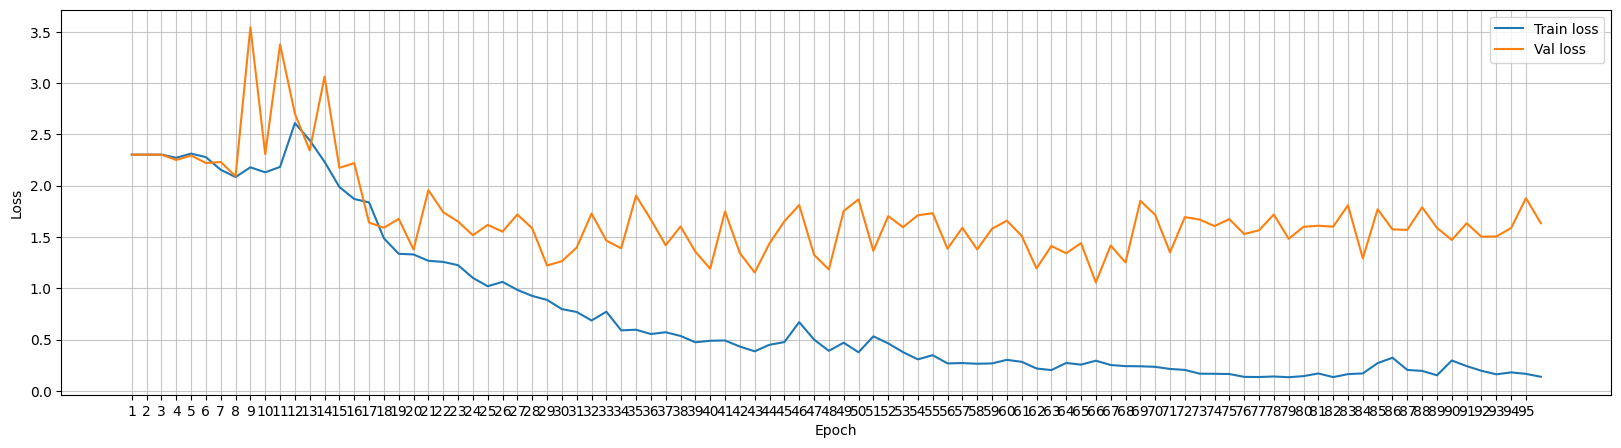

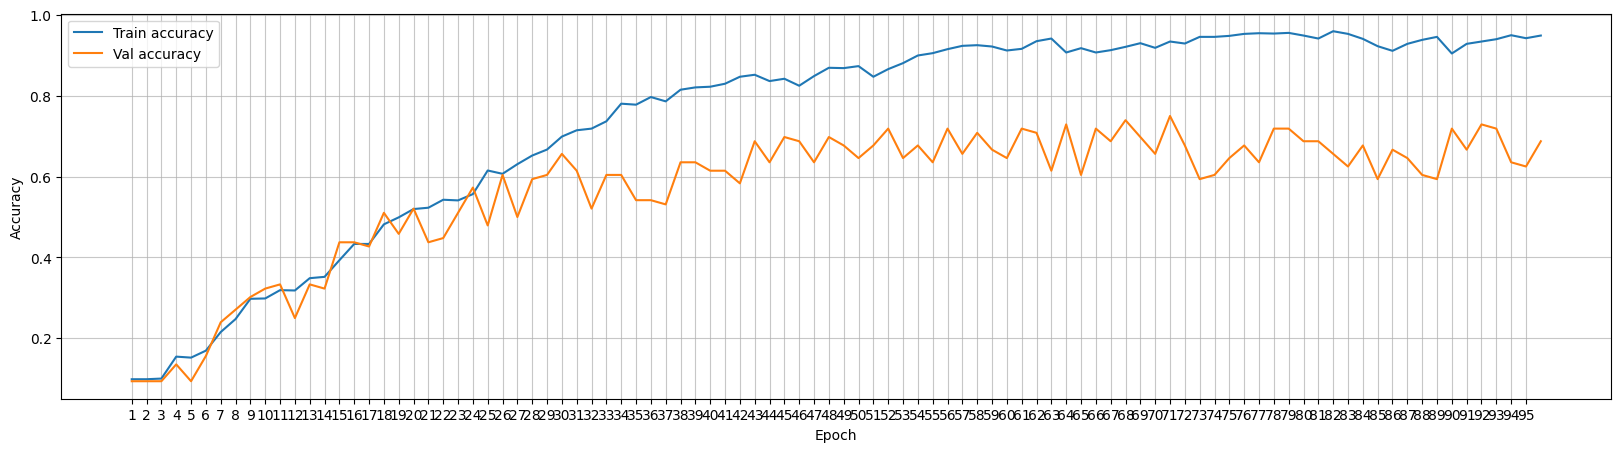

In [26]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6125 (61.25%)

MACRO AVERAGES:
  F1-Score   : 0.5932
  Precision  : 0.6201
  Recall     : 0.6125

WEIGHTED AVERAGES:
  F1-Score   : 0.5932
  Precision  : 0.6201
  Recall     : 0.6125

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.6316   0.5455     0.7500  
clock_tick      0.5000   0.7500     0.3750  
crackling_fire  0.5882   0.5556     0.6250  
crying_baby     0.8000   0.6667     1.0000  
dog             0.6667   0.6000     0.7500  
helicopter      0.7059   0.6667     0.7500  
rain            0.5000   0.5000     0.5000  
rooster         0.5000   0.7500     0.3750  
sea_waves       0.3333   0.5000     0.2500  
sneezing        0.7059   0.6667     0.7500  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.5455    0.7500    0.6316 

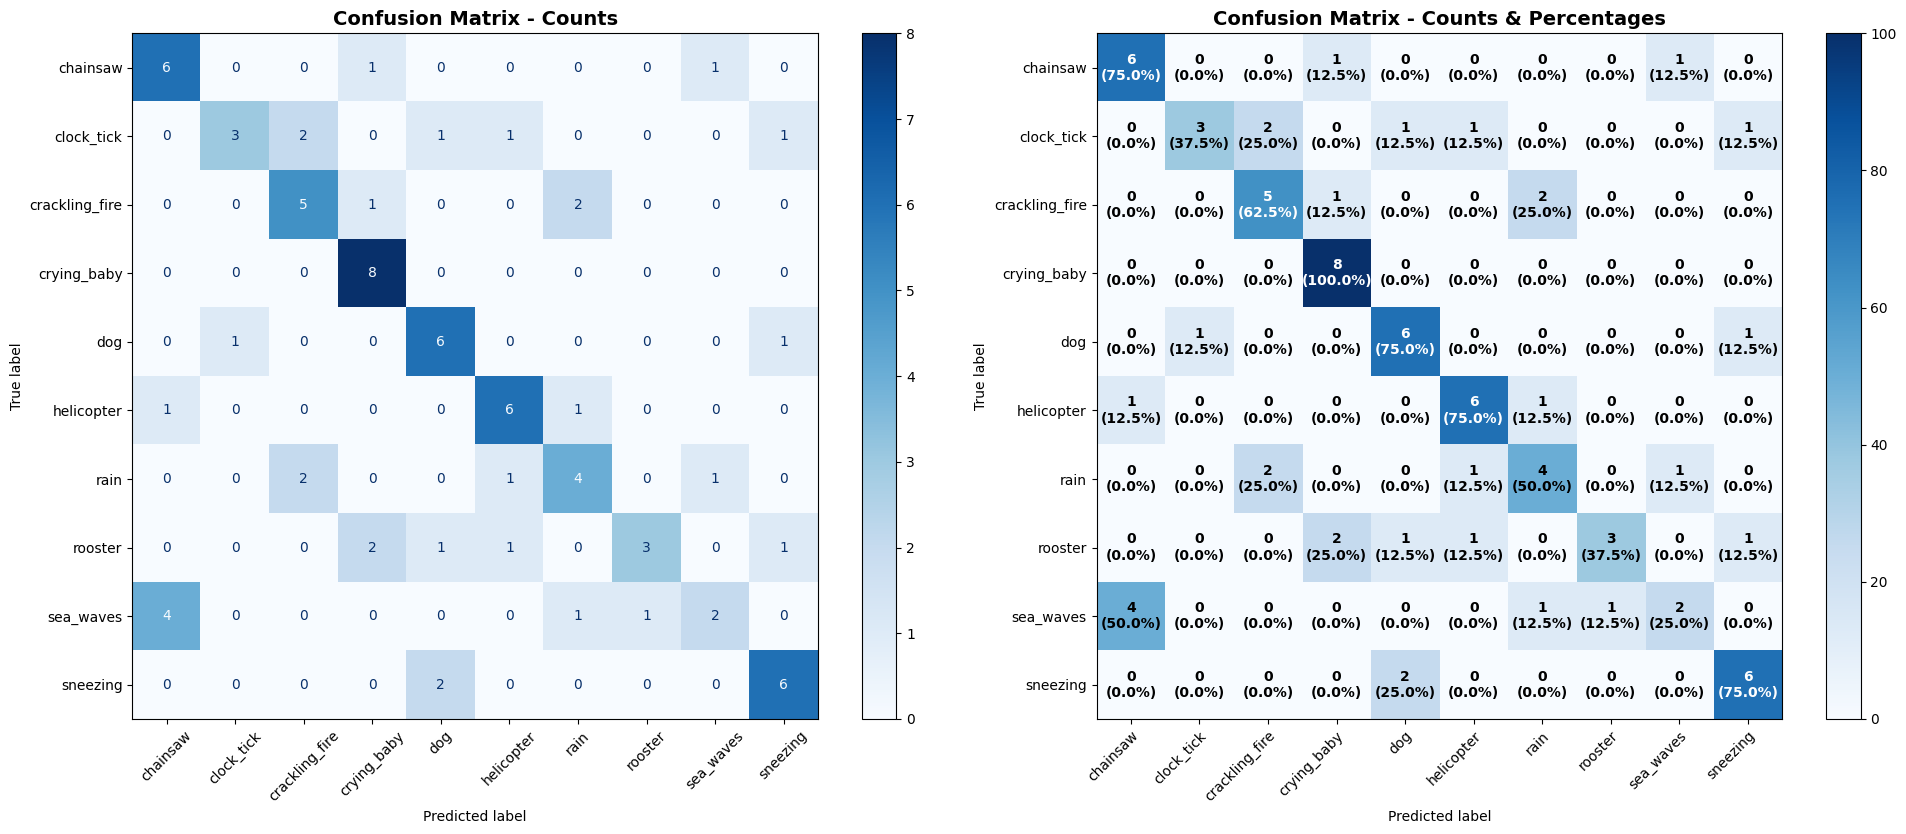


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        6        8        75.00     %
clock_tick      3        8        37.50     %
crackling_fire  5        8        62.50     %
crying_baby     8        8        100.00    %
dog             6        8        75.00     %
helicopter      6        8        75.00     %
rain            4        8        50.00     %
rooster         3        8        37.50     %
sea_waves       2        8        25.00     %
sneezing        6        8        75.00     %


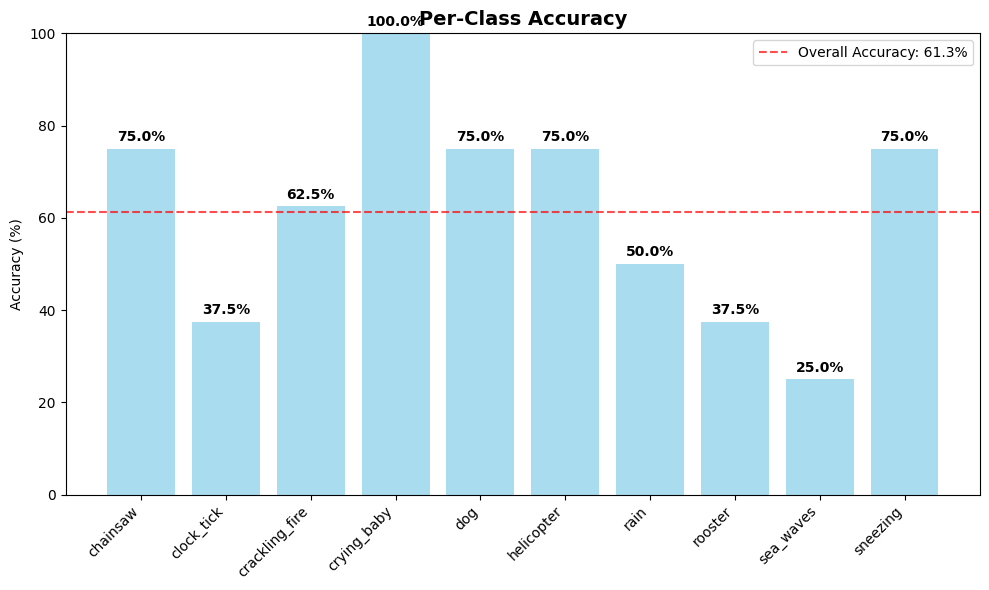

In [27]:
results_snn_delta = evaluate_model_comprehensive(delta_snn_classifier, delta_test_loader, ESCLabels.class_names, device)

##Delta Modulation: SCNN training

In [23]:
delta_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=16,
    conv_channels2=32,
    hidden_dim=64,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(delta_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 16, 128]             64
├─Leaky: 1-2                             [32, 16, 128]             2
├─MaxPool1d: 1-3                         [32, 16, 64]              --
├─Conv1d: 1-4                            [32, 32, 64]              1,568
├─Leaky: 1-5                             [32, 32, 64]              2
├─MaxPool1d: 1-6                         [32, 32, 32]              --
├─Dropout: 1-7                           [32, 1024]                --
├─Linear: 1-8                            [32, 64]                  65,536
├─Leaky: 1-9                             [32, 64]                  2
├─Linear: 1-10                           [32, 10]                  640
├─Leaky: 1-11                            [32, 10]                  2
Total params: 67,816
Trainable params: 67,816
Non-trainable params: 0
Total mult-

In [24]:
optimizer = torch.optim.Adam(delta_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=delta_c_snn_model,
    train_loader=delta_train_loader,
    valid_loader=delta_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/content/drive/MyDrive/HumanData/utils/train_eval.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [00:48<00:00,  1.18s/it]
                                                              /content/drive/MyDrive/HumanData/utils/train_eval.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [00:50<1:22:59, 50.29s/it]


Epoch 1/100 - 50s - loss: 2.3023 - acc: 0.1012 - val_loss: 2.2938 - val_acc: 0.1042



Epochs:   2%|▏         | 2/100 [01:40<1:21:45, 50.06s/it]


Epoch 2/100 - 49s - loss: 2.3021 - acc: 0.1061 - val_loss: 2.2332 - val_acc: 0.1562



Epochs:   3%|▎         | 3/100 [02:29<1:20:26, 49.76s/it]


Epoch 3/100 - 49s - loss: 2.2953 - acc: 0.1135 - val_loss: 2.3877 - val_acc: 0.1354



Epochs:   4%|▍         | 4/100 [03:18<1:19:03, 49.41s/it]


Epoch 4/100 - 48s - loss: 2.2986 - acc: 0.1423 - val_loss: 2.1316 - val_acc: 0.2292



Epochs:   5%|▌         | 5/100 [04:08<1:18:26, 49.54s/it]


Epoch 5/100 - 49s - loss: 2.2719 - acc: 0.1554 - val_loss: 2.4343 - val_acc: 0.1354



Epochs:   6%|▌         | 6/100 [04:57<1:17:24, 49.41s/it]


Epoch 6/100 - 49s - loss: 2.2284 - acc: 0.2031 - val_loss: 2.3381 - val_acc: 0.2292



Epochs:   7%|▋         | 7/100 [05:47<1:16:52, 49.59s/it]


Epoch 7/100 - 49s - loss: 2.2081 - acc: 0.2237 - val_loss: 2.2017 - val_acc: 0.2292



Epochs:   8%|▊         | 8/100 [06:36<1:15:48, 49.44s/it]


Epoch 8/100 - 49s - loss: 2.1162 - acc: 0.2755 - val_loss: 2.1637 - val_acc: 0.2500



Epochs:   9%|▉         | 9/100 [07:25<1:14:59, 49.44s/it]


Epoch 9/100 - 49s - loss: 1.9963 - acc: 0.3479 - val_loss: 2.0093 - val_acc: 0.3125



Epochs:  10%|█         | 10/100 [08:15<1:14:14, 49.49s/it]


Epoch 10/100 - 49s - loss: 1.9444 - acc: 0.3742 - val_loss: 1.9162 - val_acc: 0.3958



Epochs:  11%|█         | 11/100 [09:04<1:13:14, 49.38s/it]


Epoch 11/100 - 49s - loss: 1.6898 - acc: 0.4474 - val_loss: 1.7758 - val_acc: 0.3333



Epochs:  12%|█▏        | 12/100 [09:54<1:12:38, 49.53s/it]


Epoch 12/100 - 49s - loss: 1.6115 - acc: 0.4655 - val_loss: 1.6082 - val_acc: 0.4583



Epochs:  13%|█▎        | 13/100 [10:42<1:11:19, 49.19s/it]


Epoch 13/100 - 48s - loss: 1.5055 - acc: 0.4819 - val_loss: 1.8002 - val_acc: 0.4062



Epochs:  14%|█▍        | 14/100 [11:32<1:10:41, 49.32s/it]


Epoch 14/100 - 49s - loss: 1.4544 - acc: 0.5222 - val_loss: 1.5801 - val_acc: 0.5208



Epochs:  15%|█▌        | 15/100 [12:21<1:09:49, 49.29s/it]


Epoch 15/100 - 49s - loss: 1.4115 - acc: 0.5148 - val_loss: 1.4414 - val_acc: 0.4583



Epochs:  16%|█▌        | 16/100 [13:11<1:09:03, 49.33s/it]


Epoch 16/100 - 49s - loss: 1.3261 - acc: 0.5280 - val_loss: 1.4390 - val_acc: 0.4688



Epochs:  17%|█▋        | 17/100 [14:00<1:08:09, 49.27s/it]


Epoch 17/100 - 49s - loss: 1.2982 - acc: 0.5362 - val_loss: 1.3964 - val_acc: 0.4896



Epochs:  18%|█▊        | 18/100 [14:49<1:07:14, 49.20s/it]


Epoch 18/100 - 49s - loss: 1.2309 - acc: 0.5477 - val_loss: 1.2687 - val_acc: 0.5729



Epochs:  19%|█▉        | 19/100 [15:39<1:06:36, 49.34s/it]


Epoch 19/100 - 49s - loss: 1.2037 - acc: 0.5707 - val_loss: 1.4413 - val_acc: 0.5208



Epochs:  20%|██        | 20/100 [16:28<1:05:43, 49.29s/it]


Epoch 20/100 - 49s - loss: 1.1740 - acc: 0.5929 - val_loss: 1.3104 - val_acc: 0.5312



Epochs:  21%|██        | 21/100 [17:16<1:04:32, 49.02s/it]


Epoch 21/100 - 48s - loss: 1.1239 - acc: 0.5798 - val_loss: 1.3981 - val_acc: 0.5417



Epochs:  22%|██▏       | 22/100 [18:06<1:03:57, 49.20s/it]


Epoch 22/100 - 49s - loss: 1.1491 - acc: 0.6036 - val_loss: 1.2943 - val_acc: 0.5625



Epochs:  23%|██▎       | 23/100 [18:55<1:03:04, 49.14s/it]


Epoch 23/100 - 49s - loss: 1.0813 - acc: 0.6127 - val_loss: 1.2765 - val_acc: 0.5417



Epochs:  24%|██▍       | 24/100 [19:44<1:02:23, 49.25s/it]


Epoch 24/100 - 49s - loss: 0.9717 - acc: 0.6340 - val_loss: 1.3010 - val_acc: 0.5312



Epochs:  25%|██▌       | 25/100 [20:33<1:01:25, 49.15s/it]


Epoch 25/100 - 48s - loss: 1.0235 - acc: 0.6225 - val_loss: 1.0932 - val_acc: 0.6146



Epochs:  26%|██▌       | 26/100 [21:22<1:00:29, 49.05s/it]


Epoch 26/100 - 48s - loss: 0.9129 - acc: 0.6842 - val_loss: 1.0447 - val_acc: 0.5938



Epochs:  27%|██▋       | 27/100 [22:11<59:50, 49.18s/it]  


Epoch 27/100 - 49s - loss: 1.0116 - acc: 0.6160 - val_loss: 1.0875 - val_acc: 0.6146



Epochs:  28%|██▊       | 28/100 [23:00<58:56, 49.12s/it]


Epoch 28/100 - 48s - loss: 0.9282 - acc: 0.6678 - val_loss: 1.0493 - val_acc: 0.6250



Epochs:  29%|██▉       | 29/100 [23:50<58:17, 49.26s/it]


Epoch 29/100 - 49s - loss: 0.8622 - acc: 0.6850 - val_loss: 1.1591 - val_acc: 0.5521



Epochs:  30%|███       | 30/100 [24:38<57:09, 48.99s/it]


Epoch 30/100 - 48s - loss: 0.9809 - acc: 0.6480 - val_loss: 1.1646 - val_acc: 0.6042



Epochs:  31%|███       | 31/100 [25:28<56:26, 49.07s/it]


Epoch 31/100 - 49s - loss: 0.8435 - acc: 0.6859 - val_loss: 1.1147 - val_acc: 0.5312



Epochs:  32%|███▏      | 32/100 [26:17<55:48, 49.24s/it]


Epoch 32/100 - 49s - loss: 0.8949 - acc: 0.6711 - val_loss: 0.9730 - val_acc: 0.6458



Epochs:  33%|███▎      | 33/100 [27:07<55:05, 49.34s/it]


Epoch 33/100 - 49s - loss: 0.8129 - acc: 0.6957 - val_loss: 0.7338 - val_acc: 0.7500



Epochs:  34%|███▍      | 34/100 [27:57<54:24, 49.46s/it]


Epoch 34/100 - 49s - loss: 0.7356 - acc: 0.7303 - val_loss: 0.8823 - val_acc: 0.7396



Epochs:  35%|███▌      | 35/100 [28:46<53:32, 49.43s/it]


Epoch 35/100 - 49s - loss: 0.7999 - acc: 0.7097 - val_loss: 0.9080 - val_acc: 0.6562



Epochs:  36%|███▌      | 36/100 [29:35<52:35, 49.31s/it]


Epoch 36/100 - 49s - loss: 0.6624 - acc: 0.7410 - val_loss: 1.0652 - val_acc: 0.6354



Epochs:  37%|███▋      | 37/100 [30:25<51:58, 49.51s/it]


Epoch 37/100 - 49s - loss: 0.7081 - acc: 0.7459 - val_loss: 0.9494 - val_acc: 0.6562



Epochs:  38%|███▊      | 38/100 [31:14<50:59, 49.35s/it]


Epoch 38/100 - 48s - loss: 0.6760 - acc: 0.7566 - val_loss: 1.0515 - val_acc: 0.6667



Epochs:  39%|███▉      | 39/100 [32:02<49:54, 49.09s/it]


Epoch 39/100 - 48s - loss: 0.7030 - acc: 0.7319 - val_loss: 0.9885 - val_acc: 0.6250



Epochs:  40%|████      | 40/100 [32:52<49:09, 49.16s/it]


Epoch 40/100 - 49s - loss: 0.6733 - acc: 0.7426 - val_loss: 0.9060 - val_acc: 0.7083



Epochs:  41%|████      | 41/100 [33:40<48:10, 49.00s/it]


Epoch 41/100 - 48s - loss: 0.6947 - acc: 0.7459 - val_loss: 0.8651 - val_acc: 0.6771



Epochs:  42%|████▏     | 42/100 [34:29<47:21, 48.99s/it]


Epoch 42/100 - 48s - loss: 0.6404 - acc: 0.7664 - val_loss: 0.8479 - val_acc: 0.7188



Epochs:  43%|████▎     | 43/100 [35:18<46:19, 48.76s/it]


Epoch 43/100 - 48s - loss: 0.7225 - acc: 0.7336 - val_loss: 1.4644 - val_acc: 0.5417



Epochs:  44%|████▍     | 44/100 [36:07<45:40, 48.94s/it]


Epoch 44/100 - 49s - loss: 0.6184 - acc: 0.7664 - val_loss: 0.8480 - val_acc: 0.7396



Epochs:  45%|████▌     | 45/100 [36:56<44:53, 48.98s/it]


Epoch 45/100 - 49s - loss: 0.6617 - acc: 0.7632 - val_loss: 0.9442 - val_acc: 0.7083



Epochs:  46%|████▌     | 46/100 [37:44<43:55, 48.80s/it]


Epoch 46/100 - 48s - loss: 0.6154 - acc: 0.7533 - val_loss: 1.0073 - val_acc: 0.6250



Epochs:  47%|████▋     | 47/100 [38:33<43:09, 48.86s/it]


Epoch 47/100 - 48s - loss: 0.6031 - acc: 0.7747 - val_loss: 1.1465 - val_acc: 0.5833



Epochs:  48%|████▊     | 48/100 [39:22<42:20, 48.86s/it]


Epoch 48/100 - 48s - loss: 0.6008 - acc: 0.7738 - val_loss: 0.8276 - val_acc: 0.7188



Epochs:  49%|████▉     | 49/100 [40:12<41:39, 49.00s/it]


Epoch 49/100 - 49s - loss: 0.5887 - acc: 0.7854 - val_loss: 1.1184 - val_acc: 0.6979



Epochs:  50%|█████     | 50/100 [41:00<40:40, 48.81s/it]


Epoch 50/100 - 48s - loss: 0.5352 - acc: 0.8059 - val_loss: 0.9116 - val_acc: 0.6458



Epochs:  51%|█████     | 51/100 [41:48<39:44, 48.67s/it]


Epoch 51/100 - 48s - loss: 0.6117 - acc: 0.7903 - val_loss: 1.3186 - val_acc: 0.6458



Epochs:  52%|█████▏    | 52/100 [42:37<39:04, 48.84s/it]


Epoch 52/100 - 49s - loss: 0.5657 - acc: 0.7870 - val_loss: 0.9685 - val_acc: 0.6042



Epochs:  53%|█████▎    | 53/100 [43:26<38:14, 48.83s/it]


Epoch 53/100 - 48s - loss: 0.5392 - acc: 0.7870 - val_loss: 0.7741 - val_acc: 0.7188



Epochs:  54%|█████▍    | 54/100 [44:15<37:21, 48.72s/it]


Epoch 54/100 - 48s - loss: 0.5120 - acc: 0.8199 - val_loss: 1.0021 - val_acc: 0.7396



Epochs:  55%|█████▌    | 55/100 [45:03<36:30, 48.67s/it]


Epoch 55/100 - 48s - loss: 0.5009 - acc: 0.8314 - val_loss: 0.7222 - val_acc: 0.7292



Epochs:  56%|█████▌    | 56/100 [45:52<35:40, 48.65s/it]


Epoch 56/100 - 48s - loss: 0.4785 - acc: 0.8248 - val_loss: 0.7934 - val_acc: 0.7500



Epochs:  57%|█████▋    | 57/100 [46:41<35:00, 48.86s/it]


Epoch 57/100 - 49s - loss: 0.4799 - acc: 0.8133 - val_loss: 0.6806 - val_acc: 0.7083



Epochs:  58%|█████▊    | 58/100 [47:29<33:57, 48.52s/it]


Epoch 58/100 - 47s - loss: 0.5124 - acc: 0.8043 - val_loss: 0.7981 - val_acc: 0.6979



Epochs:  59%|█████▉    | 59/100 [48:18<33:17, 48.71s/it]


Epoch 59/100 - 49s - loss: 0.4980 - acc: 0.8257 - val_loss: 0.6324 - val_acc: 0.7604



Epochs:  60%|██████    | 60/100 [49:07<32:28, 48.71s/it]


Epoch 60/100 - 48s - loss: 0.4417 - acc: 0.8372 - val_loss: 0.6016 - val_acc: 0.8125



Epochs:  61%|██████    | 61/100 [49:55<31:34, 48.58s/it]


Epoch 61/100 - 48s - loss: 0.4609 - acc: 0.8322 - val_loss: 0.7197 - val_acc: 0.7812



Epochs:  62%|██████▏   | 62/100 [50:44<30:48, 48.65s/it]


Epoch 62/100 - 48s - loss: 0.4686 - acc: 0.8248 - val_loss: 0.6662 - val_acc: 0.7917



Epochs:  63%|██████▎   | 63/100 [51:33<30:00, 48.66s/it]


Epoch 63/100 - 48s - loss: 0.4574 - acc: 0.8306 - val_loss: 0.9044 - val_acc: 0.6771



Epochs:  64%|██████▍   | 64/100 [52:22<29:15, 48.77s/it]


Epoch 64/100 - 49s - loss: 0.4662 - acc: 0.8355 - val_loss: 0.9098 - val_acc: 0.6875



Epochs:  65%|██████▌   | 65/100 [53:10<28:19, 48.55s/it]


Epoch 65/100 - 48s - loss: 0.4460 - acc: 0.8380 - val_loss: 0.7473 - val_acc: 0.7708



Epochs:  66%|██████▌   | 66/100 [53:58<27:31, 48.57s/it]


Epoch 66/100 - 48s - loss: 0.3968 - acc: 0.8528 - val_loss: 0.6335 - val_acc: 0.7604



Epochs:  67%|██████▋   | 67/100 [54:47<26:46, 48.69s/it]


Epoch 67/100 - 48s - loss: 0.4501 - acc: 0.8314 - val_loss: 0.7160 - val_acc: 0.7292



Epochs:  68%|██████▊   | 68/100 [55:36<25:57, 48.66s/it]


Epoch 68/100 - 48s - loss: 0.4605 - acc: 0.8306 - val_loss: 0.6995 - val_acc: 0.7812



Epochs:  69%|██████▉   | 69/100 [56:25<25:09, 48.69s/it]


Epoch 69/100 - 48s - loss: 0.4321 - acc: 0.8306 - val_loss: 0.6554 - val_acc: 0.7708



Epochs:  70%|███████   | 70/100 [57:13<24:18, 48.60s/it]


Epoch 70/100 - 48s - loss: 0.4241 - acc: 0.8487 - val_loss: 0.7099 - val_acc: 0.7604



Epochs:  71%|███████   | 71/100 [58:02<23:29, 48.60s/it]


Epoch 71/100 - 48s - loss: 0.5001 - acc: 0.8166 - val_loss: 0.8041 - val_acc: 0.7604



Epochs:  72%|███████▏  | 72/100 [58:50<22:38, 48.52s/it]


Epoch 72/100 - 48s - loss: 0.3948 - acc: 0.8618 - val_loss: 0.7942 - val_acc: 0.7812



Epochs:  73%|███████▎  | 73/100 [59:39<21:50, 48.54s/it]


Epoch 73/100 - 48s - loss: 0.4286 - acc: 0.8479 - val_loss: 0.7069 - val_acc: 0.7396



Epochs:  74%|███████▍  | 74/100 [1:00:28<21:06, 48.71s/it]


Epoch 74/100 - 49s - loss: 0.4214 - acc: 0.8503 - val_loss: 0.9081 - val_acc: 0.6979



Epochs:  75%|███████▌  | 75/100 [1:01:16<20:15, 48.62s/it]


Epoch 75/100 - 48s - loss: 0.4213 - acc: 0.8396 - val_loss: 0.7192 - val_acc: 0.7292



Epochs:  76%|███████▌  | 76/100 [1:02:05<19:27, 48.65s/it]


Epoch 76/100 - 48s - loss: 0.3926 - acc: 0.8610 - val_loss: 0.7285 - val_acc: 0.8021



Epochs:  77%|███████▋  | 77/100 [1:02:54<18:44, 48.91s/it]


Epoch 77/100 - 49s - loss: 0.3998 - acc: 0.8569 - val_loss: 0.9475 - val_acc: 0.7188



Epochs:  78%|███████▊  | 78/100 [1:03:44<18:03, 49.27s/it]


Epoch 78/100 - 50s - loss: 0.4850 - acc: 0.8347 - val_loss: 0.8461 - val_acc: 0.7500



Epochs:  79%|███████▉  | 79/100 [1:04:34<17:19, 49.48s/it]


Epoch 79/100 - 49s - loss: 0.3740 - acc: 0.8742 - val_loss: 0.8684 - val_acc: 0.7396



Epochs:  80%|████████  | 80/100 [1:05:23<16:22, 49.14s/it]


Epoch 80/100 - 48s - loss: 0.3864 - acc: 0.8618 - val_loss: 0.7917 - val_acc: 0.6875



Epochs:  81%|████████  | 81/100 [1:06:12<15:35, 49.23s/it]


Epoch 81/100 - 49s - loss: 0.3833 - acc: 0.8586 - val_loss: 0.7543 - val_acc: 0.7396



Epochs:  82%|████████▏ | 82/100 [1:07:02<14:51, 49.53s/it]


Epoch 82/100 - 50s - loss: 0.4301 - acc: 0.8396 - val_loss: 0.8519 - val_acc: 0.7604



Epochs:  83%|████████▎ | 83/100 [1:07:52<14:00, 49.45s/it]


Epoch 83/100 - 49s - loss: 0.4289 - acc: 0.8421 - val_loss: 0.7918 - val_acc: 0.7604



Epochs:  84%|████████▍ | 84/100 [1:08:41<13:09, 49.37s/it]


Epoch 84/100 - 49s - loss: 0.4317 - acc: 0.8347 - val_loss: 0.6498 - val_acc: 0.7500



Epochs:  85%|████████▌ | 85/100 [1:09:30<12:21, 49.40s/it]


Epoch 85/100 - 49s - loss: 0.3209 - acc: 0.8791 - val_loss: 0.8552 - val_acc: 0.7292



Epochs:  86%|████████▌ | 86/100 [1:10:20<11:32, 49.45s/it]


Epoch 86/100 - 49s - loss: 0.3315 - acc: 0.8766 - val_loss: 0.7583 - val_acc: 0.7396



Epochs:  87%|████████▋ | 87/100 [1:11:09<10:40, 49.27s/it]


Epoch 87/100 - 48s - loss: 0.3614 - acc: 0.8643 - val_loss: 0.7624 - val_acc: 0.7500



Epochs:  88%|████████▊ | 88/100 [1:11:57<09:48, 49.07s/it]


Epoch 88/100 - 48s - loss: 0.3575 - acc: 0.8758 - val_loss: 0.6954 - val_acc: 0.7708



Epochs:  89%|████████▉ | 89/100 [1:12:47<09:02, 49.33s/it]


Epoch 89/100 - 49s - loss: 0.2751 - acc: 0.9038 - val_loss: 0.7752 - val_acc: 0.7188



Epochs:  89%|████████▉ | 89/100 [1:13:36<09:05, 49.63s/it]

Early stopping triggered


In [25]:
torch.save(delta_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/delta_modulation/delta_scnn.pth')

##Delta Modulation: SCNN evaluation

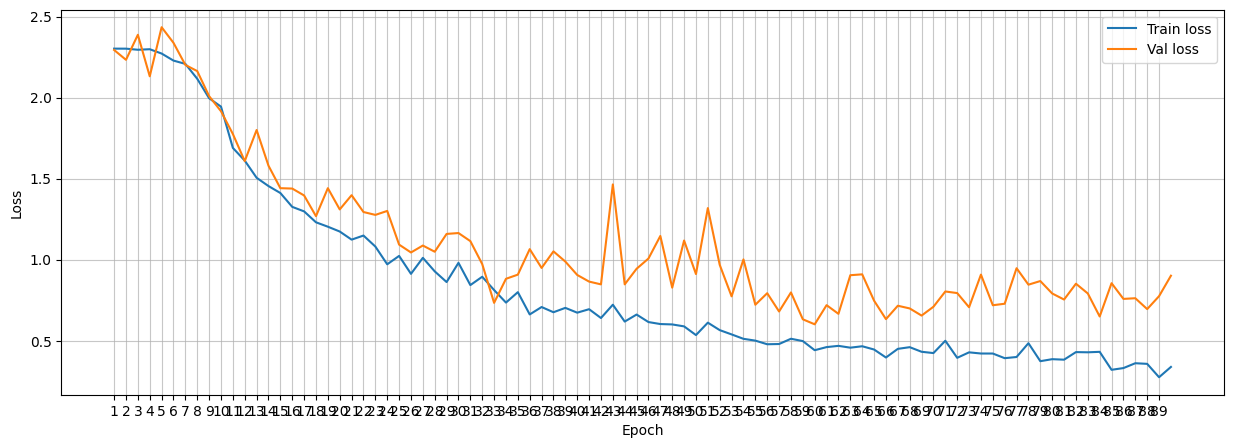

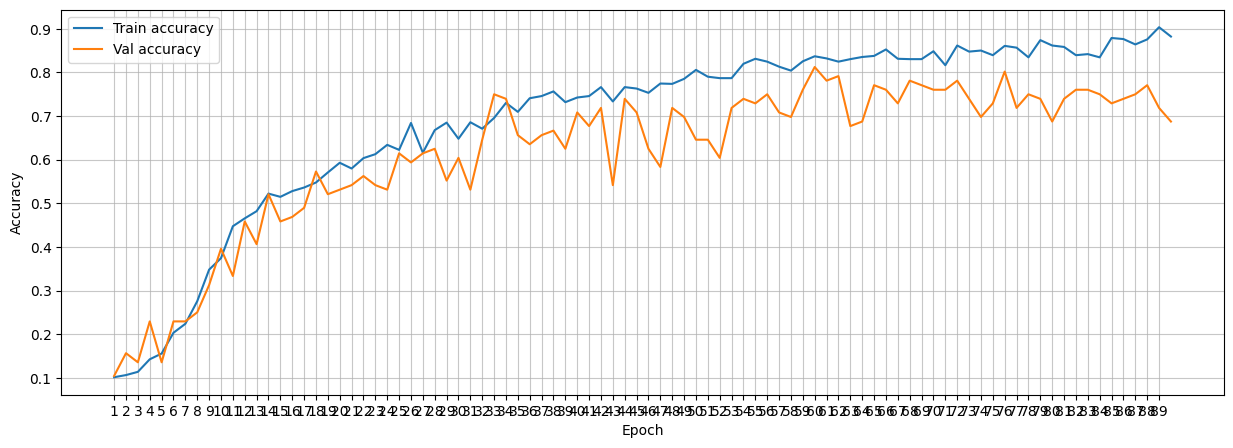

In [26]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6625 (66.25%)

MACRO AVERAGES:
  F1-Score   : 0.6288
  Precision  : 0.6530
  Recall     : 0.6625

WEIGHTED AVERAGES:
  F1-Score   : 0.6288
  Precision  : 0.6530
  Recall     : 0.6625

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.5517   0.3810     1.0000  
clock_tick      0.5000   0.5000     0.5000  
crackling_fire  0.7143   0.8333     0.6250  
crying_baby     1.0000   1.0000     1.0000  
dog             0.6250   0.6250     0.6250  
helicopter      0.8000   0.6667     1.0000  
rain            0.3636   0.6667     0.2500  
rooster         0.9333   1.0000     0.8750  
sea_waves       0.0000   0.0000     0.0000  
sneezing        0.8000   0.8571     0.7500  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.3810    1.0000    0.5517 

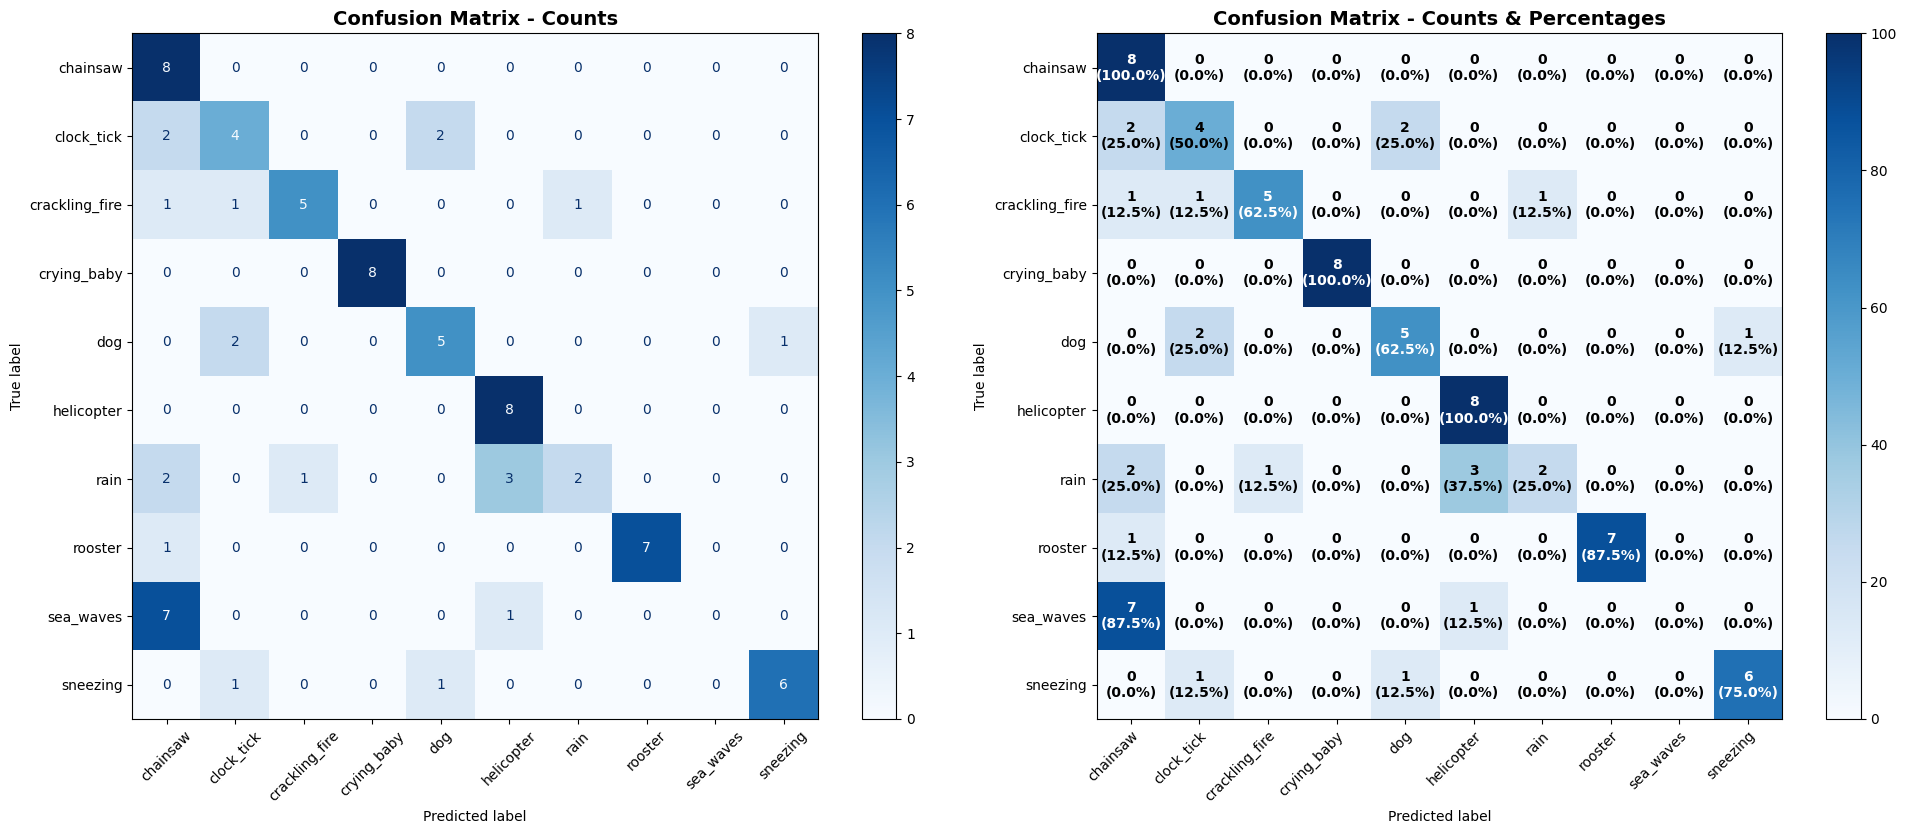


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        8        8        100.00    %
clock_tick      4        8        50.00     %
crackling_fire  5        8        62.50     %
crying_baby     8        8        100.00    %
dog             5        8        62.50     %
helicopter      8        8        100.00    %
rain            2        8        25.00     %
rooster         7        8        87.50     %
sea_waves       0        8        0.00      %
sneezing        6        8        75.00     %


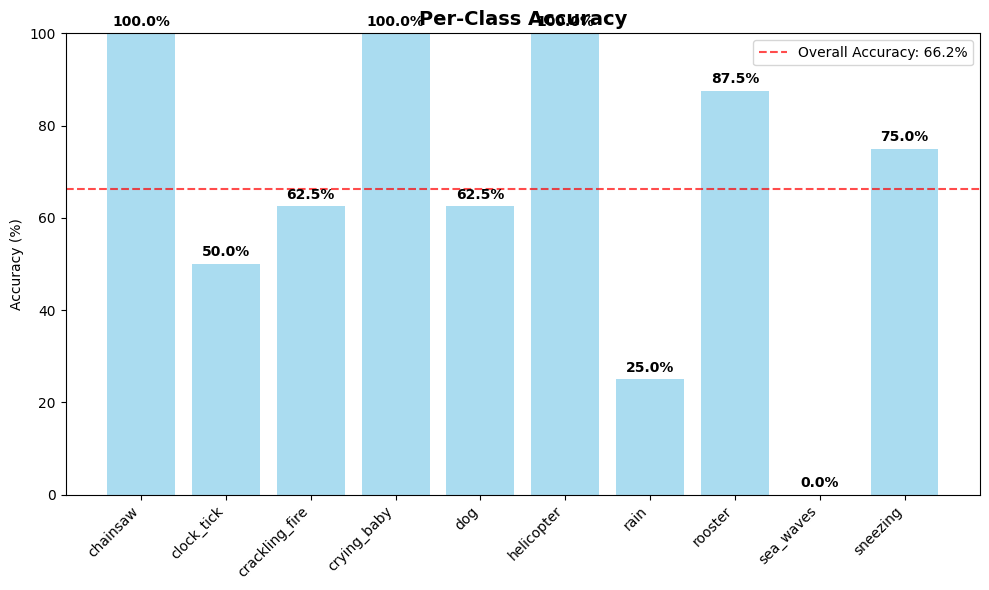

In [27]:
results_scnn_delta = evaluate_model_comprehensive(delta_c_snn_model, delta_test_loader, ESCLabels.class_names, device)

# Spike Encoding: Threshold Adaptive Encoding

In [28]:
ALPHA = 0.999

In [29]:
tae_train_dataset = ThresholdAdaptiveDataset(X_train_tensor, y_train_tensor, alpha=ALPHA)
tae_val_dataset = ThresholdAdaptiveDataset(X_val_tensor, y_val_tensor, alpha=ALPHA)
tae_test_dataset = ThresholdAdaptiveDataset(X_test_tensor, y_test_tensor, alpha=ALPHA)

In [30]:
tae_train_loader = DataLoader(tae_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                num_workers=2, pin_memory=torch.cuda.is_available())
tae_val_loader = DataLoader(tae_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=2, pin_memory=torch.cuda.is_available())
tae_test_loader = DataLoader(tae_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                               num_workers=2, pin_memory=torch.cuda.is_available())

In [31]:
tae_X_batch, tae_y_batch = next(iter(tae_train_loader))
print("Threshold Adaptive encoding compleated!")

Threshold Adaptive encoding compleated!


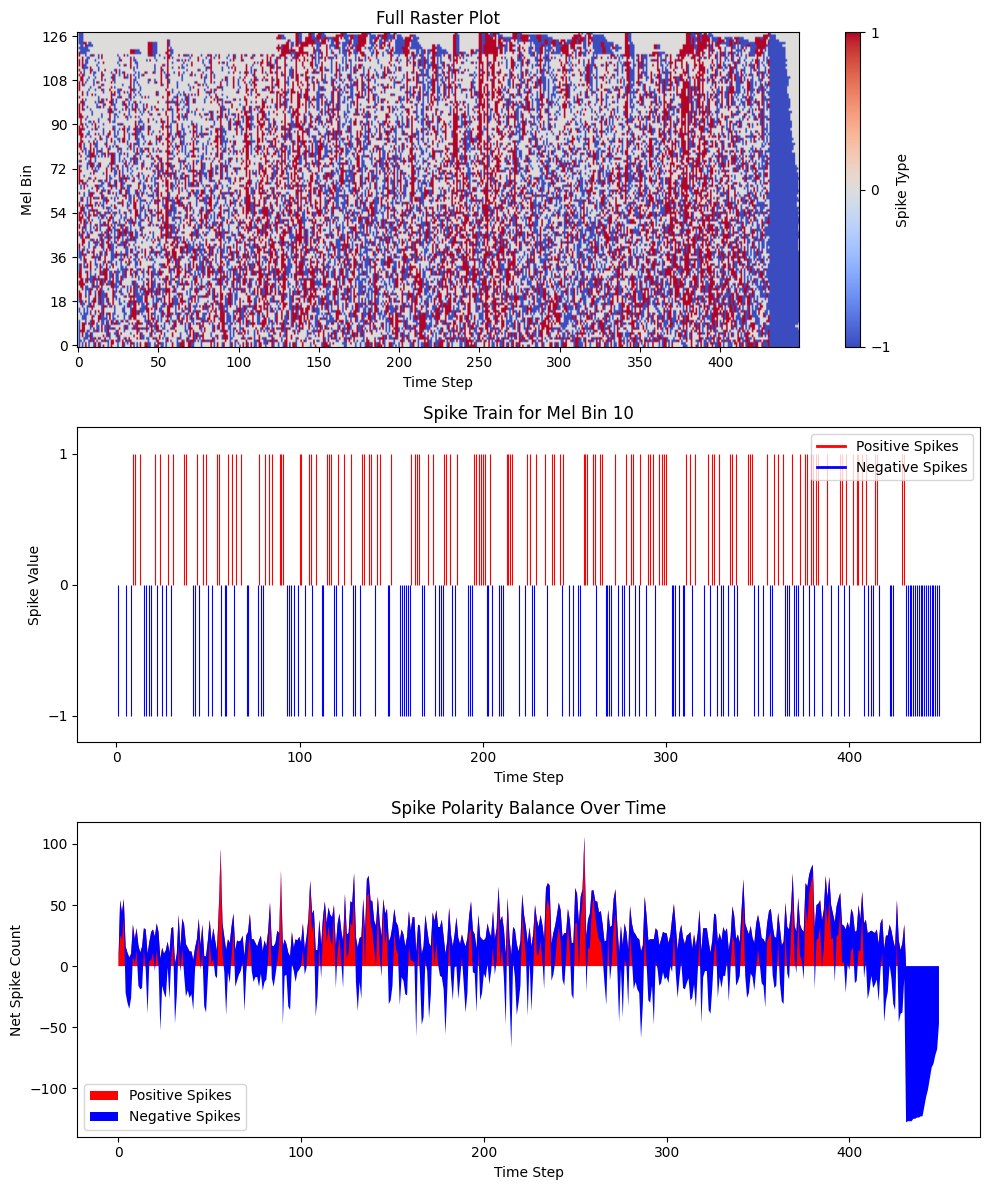

TAE Class: sea_waves


In [32]:
sample_idx = 10
visualize_spike_trains(tae_X_batch, sample_idx=sample_idx, mel_bin=10)
print(f"TAE Class: {ESCLabels.index_to_label[tae_y_batch[sample_idx].item()]}")

##TAE: SNN training

In [33]:
tae_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(tae_snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [34]:
optimizer = torch.optim.Adam(tae_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=tae_snn_classifier,
    train_loader=tae_train_loader,
    valid_loader=tae_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/content/drive/MyDrive/HumanData/utils/train_eval.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [01:49<00:00,  2.40s/it]
                                                              /content/drive/MyDrive/HumanData/utils/train_eval.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [01:55<3:09:50, 115.05s/it]


Epoch 1/100 - 115s - loss: 2.3026 - acc: 0.1012 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [03:49<3:07:24, 114.74s/it]


Epoch 2/100 - 114s - loss: 2.3228 - acc: 0.1102 - val_loss: 2.3072 - val_acc: 0.1042



Epochs:   3%|▎         | 3/100 [05:44<3:05:59, 115.04s/it]


Epoch 3/100 - 115s - loss: 2.2894 - acc: 0.1628 - val_loss: 2.2305 - val_acc: 0.1875



Epochs:   4%|▍         | 4/100 [07:39<3:03:32, 114.71s/it]


Epoch 4/100 - 114s - loss: 2.2950 - acc: 0.1809 - val_loss: 2.2959 - val_acc: 0.2188



Epochs:   5%|▌         | 5/100 [09:35<3:02:24, 115.21s/it]


Epoch 5/100 - 116s - loss: 2.2835 - acc: 0.2188 - val_loss: 2.1199 - val_acc: 0.2708



Epochs:   6%|▌         | 6/100 [11:30<3:00:16, 115.07s/it]


Epoch 6/100 - 114s - loss: 2.1290 - acc: 0.2500 - val_loss: 1.9251 - val_acc: 0.3333



Epochs:   7%|▋         | 7/100 [13:24<2:58:08, 114.93s/it]


Epoch 7/100 - 114s - loss: 2.2378 - acc: 0.3018 - val_loss: 2.1164 - val_acc: 0.3750



Epochs:   8%|▊         | 8/100 [15:19<2:56:20, 115.00s/it]


Epoch 8/100 - 115s - loss: 1.9823 - acc: 0.4178 - val_loss: 2.0424 - val_acc: 0.3229



Epochs:   9%|▉         | 9/100 [17:14<2:54:09, 114.83s/it]


Epoch 9/100 - 114s - loss: 2.1737 - acc: 0.3791 - val_loss: 2.1566 - val_acc: 0.4167



Epochs:  10%|█         | 10/100 [19:09<2:52:27, 114.97s/it]


Epoch 10/100 - 115s - loss: 1.9565 - acc: 0.4326 - val_loss: 1.8920 - val_acc: 0.3333



Epochs:  11%|█         | 11/100 [21:03<2:50:08, 114.71s/it]


Epoch 11/100 - 114s - loss: 1.5073 - acc: 0.4959 - val_loss: 2.0731 - val_acc: 0.4792



Epochs:  12%|█▏        | 12/100 [22:59<2:48:51, 115.13s/it]


Epoch 12/100 - 116s - loss: 1.7020 - acc: 0.4762 - val_loss: 2.0163 - val_acc: 0.5000



Epochs:  13%|█▎        | 13/100 [24:54<2:46:47, 115.03s/it]


Epoch 13/100 - 114s - loss: 1.6403 - acc: 0.4951 - val_loss: 2.0120 - val_acc: 0.3854



Epochs:  14%|█▍        | 14/100 [26:49<2:44:35, 114.83s/it]


Epoch 14/100 - 114s - loss: 1.6801 - acc: 0.4803 - val_loss: 1.8879 - val_acc: 0.5417



Epochs:  15%|█▌        | 15/100 [28:44<2:43:04, 115.11s/it]


Epoch 15/100 - 115s - loss: 2.0674 - acc: 0.5321 - val_loss: 1.8381 - val_acc: 0.5833



Epochs:  16%|█▌        | 16/100 [30:40<2:41:32, 115.38s/it]


Epoch 16/100 - 116s - loss: 2.0661 - acc: 0.5362 - val_loss: 2.1766 - val_acc: 0.5833



Epochs:  17%|█▋        | 17/100 [32:36<2:39:47, 115.51s/it]


Epoch 17/100 - 115s - loss: 1.8772 - acc: 0.5584 - val_loss: 2.2116 - val_acc: 0.5208



Epochs:  18%|█▊        | 18/100 [34:31<2:37:37, 115.34s/it]


Epoch 18/100 - 114s - loss: 1.7472 - acc: 0.5781 - val_loss: 2.0304 - val_acc: 0.5417



Epochs:  19%|█▉        | 19/100 [36:25<2:35:10, 114.94s/it]


Epoch 19/100 - 114s - loss: 1.6628 - acc: 0.5798 - val_loss: 1.7969 - val_acc: 0.4688



Epochs:  20%|██        | 20/100 [38:21<2:33:51, 115.40s/it]


Epoch 20/100 - 116s - loss: 1.5949 - acc: 0.5962 - val_loss: 2.0755 - val_acc: 0.5417



Epochs:  21%|██        | 21/100 [40:16<2:31:33, 115.11s/it]


Epoch 21/100 - 114s - loss: 1.5501 - acc: 0.5921 - val_loss: 1.8047 - val_acc: 0.5625



Epochs:  22%|██▏       | 22/100 [42:10<2:29:19, 114.87s/it]


Epoch 22/100 - 114s - loss: 1.4741 - acc: 0.6151 - val_loss: 1.9982 - val_acc: 0.4896



Epochs:  23%|██▎       | 23/100 [44:06<2:27:42, 115.10s/it]


Epoch 23/100 - 115s - loss: 1.3004 - acc: 0.6562 - val_loss: 2.3260 - val_acc: 0.5104



Epochs:  24%|██▍       | 24/100 [46:00<2:25:22, 114.78s/it]


Epoch 24/100 - 114s - loss: 1.3797 - acc: 0.6464 - val_loss: 1.9003 - val_acc: 0.5208



Epochs:  25%|██▌       | 25/100 [47:56<2:23:55, 115.14s/it]


Epoch 25/100 - 115s - loss: 1.4363 - acc: 0.6505 - val_loss: 2.2697 - val_acc: 0.4583



Epochs:  26%|██▌       | 26/100 [49:51<2:21:52, 115.03s/it]


Epoch 26/100 - 114s - loss: 1.5308 - acc: 0.6439 - val_loss: 2.1029 - val_acc: 0.5312



Epochs:  27%|██▋       | 27/100 [51:45<2:19:43, 114.84s/it]


Epoch 27/100 - 114s - loss: 1.3706 - acc: 0.6628 - val_loss: 1.9699 - val_acc: 0.5104



Epochs:  28%|██▊       | 28/100 [53:42<2:18:37, 115.52s/it]


Epoch 28/100 - 117s - loss: 1.2965 - acc: 0.6620 - val_loss: 1.9834 - val_acc: 0.5312



Epochs:  29%|██▉       | 29/100 [55:36<2:16:13, 115.12s/it]


Epoch 29/100 - 114s - loss: 1.1958 - acc: 0.6776 - val_loss: 1.9447 - val_acc: 0.6042



Epochs:  30%|███       | 30/100 [57:30<2:13:41, 114.60s/it]


Epoch 30/100 - 113s - loss: 1.2526 - acc: 0.6883 - val_loss: 2.1410 - val_acc: 0.5312



Epochs:  31%|███       | 31/100 [59:25<2:11:53, 114.69s/it]


Epoch 31/100 - 114s - loss: 1.2809 - acc: 0.6850 - val_loss: 1.7654 - val_acc: 0.6146



Epochs:  32%|███▏      | 32/100 [1:01:20<2:10:05, 114.79s/it]


Epoch 32/100 - 115s - loss: 1.1383 - acc: 0.7048 - val_loss: 2.5232 - val_acc: 0.4896



Epochs:  33%|███▎      | 33/100 [1:03:14<2:07:53, 114.53s/it]


Epoch 33/100 - 113s - loss: 0.9650 - acc: 0.7278 - val_loss: 1.5282 - val_acc: 0.6042



Epochs:  34%|███▍      | 34/100 [1:05:09<2:06:07, 114.65s/it]


Epoch 34/100 - 114s - loss: 1.0793 - acc: 0.7229 - val_loss: 2.4438 - val_acc: 0.5000



Epochs:  35%|███▌      | 35/100 [1:07:03<2:04:18, 114.74s/it]


Epoch 35/100 - 114s - loss: 1.0678 - acc: 0.7146 - val_loss: 1.7817 - val_acc: 0.6146



Epochs:  36%|███▌      | 36/100 [1:08:57<2:01:57, 114.34s/it]


Epoch 36/100 - 113s - loss: 1.0580 - acc: 0.7245 - val_loss: 2.4225 - val_acc: 0.5312



Epochs:  37%|███▋      | 37/100 [1:10:52<2:00:12, 114.48s/it]


Epoch 37/100 - 114s - loss: 1.0611 - acc: 0.7155 - val_loss: 1.8944 - val_acc: 0.6562



Epochs:  38%|███▊      | 38/100 [1:12:47<1:58:26, 114.63s/it]


Epoch 38/100 - 114s - loss: 1.0167 - acc: 0.7270 - val_loss: 2.4151 - val_acc: 0.5625



Epochs:  39%|███▉      | 39/100 [1:14:41<1:56:23, 114.49s/it]


Epoch 39/100 - 114s - loss: 0.9814 - acc: 0.7336 - val_loss: 2.5169 - val_acc: 0.4896



Epochs:  40%|████      | 40/100 [1:16:35<1:54:25, 114.43s/it]


Epoch 40/100 - 114s - loss: 0.9058 - acc: 0.7615 - val_loss: 1.7738 - val_acc: 0.5938



Epochs:  41%|████      | 41/100 [1:18:30<1:52:45, 114.68s/it]


Epoch 41/100 - 115s - loss: 0.8565 - acc: 0.7722 - val_loss: 1.8352 - val_acc: 0.6458



Epochs:  42%|████▏     | 42/100 [1:20:24<1:50:28, 114.29s/it]


Epoch 42/100 - 113s - loss: 0.9993 - acc: 0.7220 - val_loss: 1.7884 - val_acc: 0.6979



Epochs:  43%|████▎     | 43/100 [1:22:18<1:48:29, 114.20s/it]


Epoch 43/100 - 114s - loss: 0.9188 - acc: 0.7525 - val_loss: 2.1432 - val_acc: 0.6250



Epochs:  44%|████▍     | 44/100 [1:24:12<1:46:42, 114.33s/it]


Epoch 44/100 - 114s - loss: 0.7574 - acc: 0.8043 - val_loss: 2.0593 - val_acc: 0.5312



Epochs:  45%|████▌     | 45/100 [1:26:08<1:45:02, 114.60s/it]


Epoch 45/100 - 115s - loss: 0.8365 - acc: 0.7878 - val_loss: 1.8594 - val_acc: 0.6250



Epochs:  46%|████▌     | 46/100 [1:28:02<1:43:08, 114.61s/it]


Epoch 46/100 - 114s - loss: 0.9887 - acc: 0.7837 - val_loss: 1.9667 - val_acc: 0.6354



Epochs:  47%|████▋     | 47/100 [1:29:57<1:41:21, 114.75s/it]


Epoch 47/100 - 115s - loss: 0.6597 - acc: 0.8191 - val_loss: 2.2442 - val_acc: 0.5833



Epochs:  48%|████▊     | 48/100 [1:31:53<1:39:37, 114.95s/it]


Epoch 48/100 - 115s - loss: 0.7203 - acc: 0.8207 - val_loss: 1.4830 - val_acc: 0.6562



Epochs:  49%|████▉     | 49/100 [1:33:47<1:37:34, 114.79s/it]


Epoch 49/100 - 114s - loss: 0.7935 - acc: 0.7887 - val_loss: 2.6045 - val_acc: 0.4896



Epochs:  50%|█████     | 50/100 [1:35:41<1:35:31, 114.63s/it]


Epoch 50/100 - 114s - loss: 0.7816 - acc: 0.7878 - val_loss: 2.4344 - val_acc: 0.4792



Epochs:  51%|█████     | 51/100 [1:37:37<1:33:46, 114.82s/it]


Epoch 51/100 - 115s - loss: 0.7471 - acc: 0.8141 - val_loss: 1.5916 - val_acc: 0.6771



Epochs:  52%|█████▏    | 52/100 [1:39:32<1:31:55, 114.90s/it]


Epoch 52/100 - 115s - loss: 0.6352 - acc: 0.8421 - val_loss: 1.8037 - val_acc: 0.6146



Epochs:  53%|█████▎    | 53/100 [1:41:27<1:30:03, 114.97s/it]


Epoch 53/100 - 115s - loss: 0.6952 - acc: 0.8429 - val_loss: 1.4715 - val_acc: 0.6771



Epochs:  54%|█████▍    | 54/100 [1:43:22<1:28:09, 114.99s/it]


Epoch 54/100 - 115s - loss: 0.7946 - acc: 0.8150 - val_loss: 2.6555 - val_acc: 0.5938



Epochs:  55%|█████▌    | 55/100 [1:45:18<1:26:33, 115.41s/it]


Epoch 55/100 - 116s - loss: 0.7921 - acc: 0.8109 - val_loss: 1.4925 - val_acc: 0.6042



Epochs:  56%|█████▌    | 56/100 [1:47:15<1:24:49, 115.67s/it]


Epoch 56/100 - 116s - loss: 0.6736 - acc: 0.8396 - val_loss: 2.0044 - val_acc: 0.6458



Epochs:  57%|█████▋    | 57/100 [1:49:09<1:22:40, 115.36s/it]


Epoch 57/100 - 114s - loss: 0.5603 - acc: 0.8569 - val_loss: 1.7278 - val_acc: 0.6250



Epochs:  58%|█████▊    | 58/100 [1:51:05<1:20:49, 115.47s/it]


Epoch 58/100 - 115s - loss: 0.5760 - acc: 0.8487 - val_loss: 1.4045 - val_acc: 0.6875



Epochs:  59%|█████▉    | 59/100 [1:53:01<1:19:01, 115.64s/it]


Epoch 59/100 - 116s - loss: 0.6015 - acc: 0.8487 - val_loss: 1.5084 - val_acc: 0.7292



Epochs:  60%|██████    | 60/100 [1:54:56<1:16:56, 115.42s/it]


Epoch 60/100 - 114s - loss: 0.5908 - acc: 0.8421 - val_loss: 1.3562 - val_acc: 0.7396



Epochs:  61%|██████    | 61/100 [1:56:50<1:14:47, 115.06s/it]


Epoch 61/100 - 114s - loss: 0.6244 - acc: 0.8413 - val_loss: 1.3233 - val_acc: 0.7292



Epochs:  62%|██████▏   | 62/100 [1:58:46<1:13:06, 115.44s/it]


Epoch 62/100 - 116s - loss: 0.5181 - acc: 0.8618 - val_loss: 2.1773 - val_acc: 0.6354



Epochs:  63%|██████▎   | 63/100 [2:00:43<1:11:20, 115.68s/it]


Epoch 63/100 - 116s - loss: 0.6577 - acc: 0.8454 - val_loss: 1.3268 - val_acc: 0.7396



Epochs:  64%|██████▍   | 64/100 [2:02:38<1:09:20, 115.57s/it]


Epoch 64/100 - 115s - loss: 0.5368 - acc: 0.8692 - val_loss: 1.5399 - val_acc: 0.6562



Epochs:  65%|██████▌   | 65/100 [2:04:32<1:07:05, 115.02s/it]


Epoch 65/100 - 113s - loss: 0.7341 - acc: 0.8347 - val_loss: 2.0110 - val_acc: 0.6562



Epochs:  66%|██████▌   | 66/100 [2:06:28<1:05:21, 115.34s/it]


Epoch 66/100 - 116s - loss: 0.7383 - acc: 0.8281 - val_loss: 1.2928 - val_acc: 0.7396



Epochs:  67%|██████▋   | 67/100 [2:08:24<1:03:30, 115.46s/it]


Epoch 67/100 - 115s - loss: 0.6858 - acc: 0.8363 - val_loss: 1.5231 - val_acc: 0.7083



Epochs:  68%|██████▊   | 68/100 [2:10:17<1:01:14, 114.81s/it]


Epoch 68/100 - 113s - loss: 0.7750 - acc: 0.8446 - val_loss: 1.9635 - val_acc: 0.7188



Epochs:  69%|██████▉   | 69/100 [2:12:10<59:08, 114.46s/it]  


Epoch 69/100 - 113s - loss: 0.8240 - acc: 0.8339 - val_loss: 1.6274 - val_acc: 0.6667



Epochs:  70%|███████   | 70/100 [2:14:06<57:19, 114.65s/it]


Epoch 70/100 - 115s - loss: 0.6921 - acc: 0.8487 - val_loss: 1.3164 - val_acc: 0.7708



Epochs:  71%|███████   | 71/100 [2:15:59<55:17, 114.41s/it]


Epoch 71/100 - 113s - loss: 0.7078 - acc: 0.8586 - val_loss: 1.4346 - val_acc: 0.7604



Epochs:  72%|███████▏  | 72/100 [2:17:53<53:17, 114.19s/it]


Epoch 72/100 - 113s - loss: 0.5405 - acc: 0.8684 - val_loss: 1.3062 - val_acc: 0.7396



Epochs:  73%|███████▎  | 73/100 [2:19:48<51:32, 114.53s/it]


Epoch 73/100 - 115s - loss: 0.7170 - acc: 0.8544 - val_loss: 1.6834 - val_acc: 0.7292



Epochs:  74%|███████▍  | 74/100 [2:21:43<49:39, 114.58s/it]


Epoch 74/100 - 114s - loss: 0.5875 - acc: 0.8618 - val_loss: 1.4159 - val_acc: 0.8021



Epochs:  75%|███████▌  | 75/100 [2:23:37<47:38, 114.32s/it]


Epoch 75/100 - 113s - loss: 0.5725 - acc: 0.8791 - val_loss: 1.6136 - val_acc: 0.7500



Epochs:  76%|███████▌  | 76/100 [2:25:31<45:42, 114.29s/it]


Epoch 76/100 - 114s - loss: 0.5211 - acc: 0.8725 - val_loss: 1.3643 - val_acc: 0.7500



Epochs:  77%|███████▋  | 77/100 [2:27:24<43:42, 114.01s/it]


Epoch 77/100 - 113s - loss: 0.5199 - acc: 0.8725 - val_loss: 1.8969 - val_acc: 0.6667



Epochs:  78%|███████▊  | 78/100 [2:29:18<41:45, 113.89s/it]


Epoch 78/100 - 113s - loss: 0.5912 - acc: 0.8553 - val_loss: 2.6607 - val_acc: 0.5729



Epochs:  79%|███████▉  | 79/100 [2:31:13<39:56, 114.14s/it]


Epoch 79/100 - 114s - loss: 0.8148 - acc: 0.8298 - val_loss: 1.6913 - val_acc: 0.7083



Epochs:  80%|████████  | 80/100 [2:33:07<38:01, 114.10s/it]


Epoch 80/100 - 114s - loss: 0.4861 - acc: 0.8824 - val_loss: 1.3634 - val_acc: 0.7708



Epochs:  81%|████████  | 81/100 [2:35:00<36:03, 113.84s/it]


Epoch 81/100 - 113s - loss: 0.5219 - acc: 0.8766 - val_loss: 1.7089 - val_acc: 0.7500



Epochs:  82%|████████▏ | 82/100 [2:36:55<34:14, 114.15s/it]


Epoch 82/100 - 114s - loss: 0.5165 - acc: 0.8602 - val_loss: 1.5152 - val_acc: 0.8021



Epochs:  83%|████████▎ | 83/100 [2:38:48<32:16, 113.89s/it]


Epoch 83/100 - 113s - loss: 0.4470 - acc: 0.8865 - val_loss: 1.3605 - val_acc: 0.7500



Epochs:  84%|████████▍ | 84/100 [2:40:41<30:17, 113.57s/it]


Epoch 84/100 - 112s - loss: 0.8151 - acc: 0.8429 - val_loss: 1.9087 - val_acc: 0.6979



Epochs:  85%|████████▌ | 85/100 [2:42:36<28:28, 113.92s/it]


Epoch 85/100 - 114s - loss: 0.6333 - acc: 0.8594 - val_loss: 1.2632 - val_acc: 0.7188



Epochs:  86%|████████▌ | 86/100 [2:44:30<26:34, 113.92s/it]


Epoch 86/100 - 113s - loss: 0.4795 - acc: 0.8799 - val_loss: 1.6578 - val_acc: 0.6979



Epochs:  87%|████████▋ | 87/100 [2:46:23<24:38, 113.74s/it]


Epoch 87/100 - 113s - loss: 0.3964 - acc: 0.8964 - val_loss: 1.9868 - val_acc: 0.7396



Epochs:  88%|████████▊ | 88/100 [2:48:18<22:48, 114.01s/it]


Epoch 88/100 - 114s - loss: 0.5419 - acc: 0.8651 - val_loss: 1.8045 - val_acc: 0.7292



Epochs:  89%|████████▉ | 89/100 [2:50:11<20:53, 113.92s/it]


Epoch 89/100 - 113s - loss: 0.3314 - acc: 0.9021 - val_loss: 1.4233 - val_acc: 0.7604



Epochs:  90%|█████████ | 90/100 [2:52:04<18:57, 113.70s/it]


Epoch 90/100 - 113s - loss: 0.3125 - acc: 0.9120 - val_loss: 1.6715 - val_acc: 0.7708



Epochs:  91%|█████████ | 91/100 [2:53:59<17:05, 113.98s/it]


Epoch 91/100 - 114s - loss: 0.2200 - acc: 0.9326 - val_loss: 1.2786 - val_acc: 0.7708



Epochs:  92%|█████████▏| 92/100 [2:55:55<15:15, 114.47s/it]


Epoch 92/100 - 115s - loss: 0.2076 - acc: 0.9350 - val_loss: 1.6133 - val_acc: 0.7917



Epochs:  93%|█████████▎| 93/100 [2:57:49<13:20, 114.35s/it]


Epoch 93/100 - 114s - loss: 0.2937 - acc: 0.9128 - val_loss: 1.8230 - val_acc: 0.6875



Epochs:  94%|█████████▍| 94/100 [2:59:43<11:26, 114.37s/it]


Epoch 94/100 - 114s - loss: 0.3375 - acc: 0.9054 - val_loss: 1.6383 - val_acc: 0.7812



Epochs:  95%|█████████▌| 95/100 [3:01:37<09:31, 114.26s/it]


Epoch 95/100 - 114s - loss: 0.3358 - acc: 0.9211 - val_loss: 1.6833 - val_acc: 0.7500



Epochs:  96%|█████████▌| 96/100 [3:03:30<07:35, 113.81s/it]


Epoch 96/100 - 112s - loss: 0.3484 - acc: 0.9186 - val_loss: 1.8970 - val_acc: 0.7292



Epochs:  97%|█████████▋| 97/100 [3:05:25<05:42, 114.19s/it]


Epoch 97/100 - 115s - loss: 0.2973 - acc: 0.9013 - val_loss: 1.8239 - val_acc: 0.7396



Epochs:  98%|█████████▊| 98/100 [3:07:20<03:49, 114.57s/it]


Epoch 98/100 - 115s - loss: 0.4392 - acc: 0.9030 - val_loss: 1.4526 - val_acc: 0.7812



Epochs:  99%|█████████▉| 99/100 [3:09:15<01:54, 114.48s/it]


Epoch 99/100 - 114s - loss: 0.2701 - acc: 0.9169 - val_loss: 2.4948 - val_acc: 0.6979



Epochs: 100%|██████████| 100/100 [3:11:10<00:00, 114.70s/it]


Epoch 100/100 - 114s - loss: 0.3386 - acc: 0.9161 - val_loss: 1.2571 - val_acc: 0.7500


In [35]:
torch.save(tae_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/tae/tae_snn.pth')

##TAE: SNN evaluation

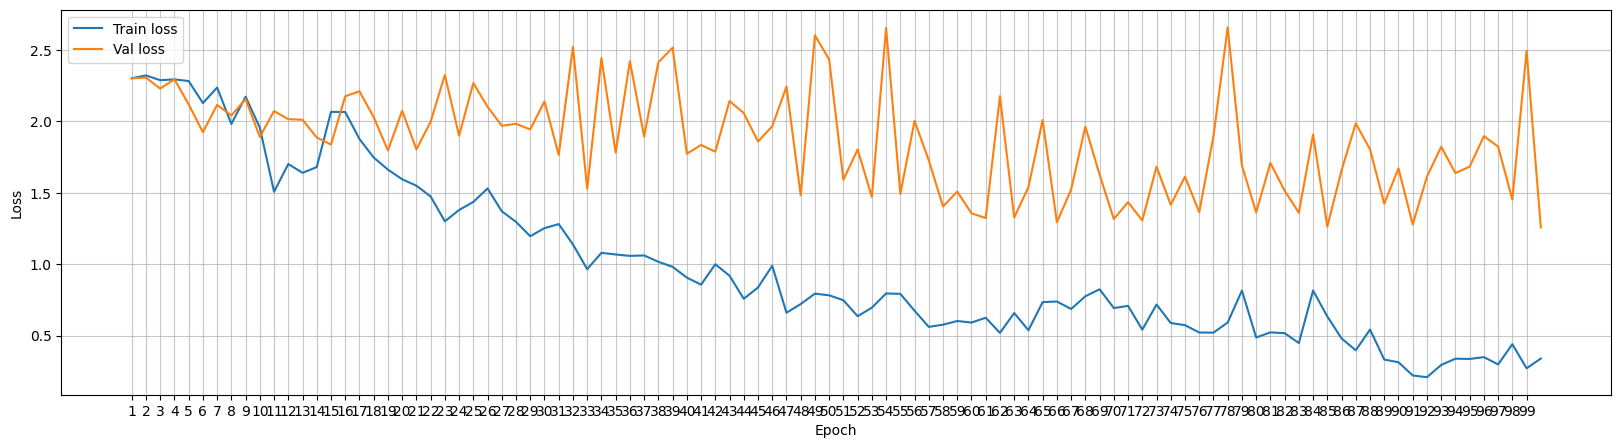

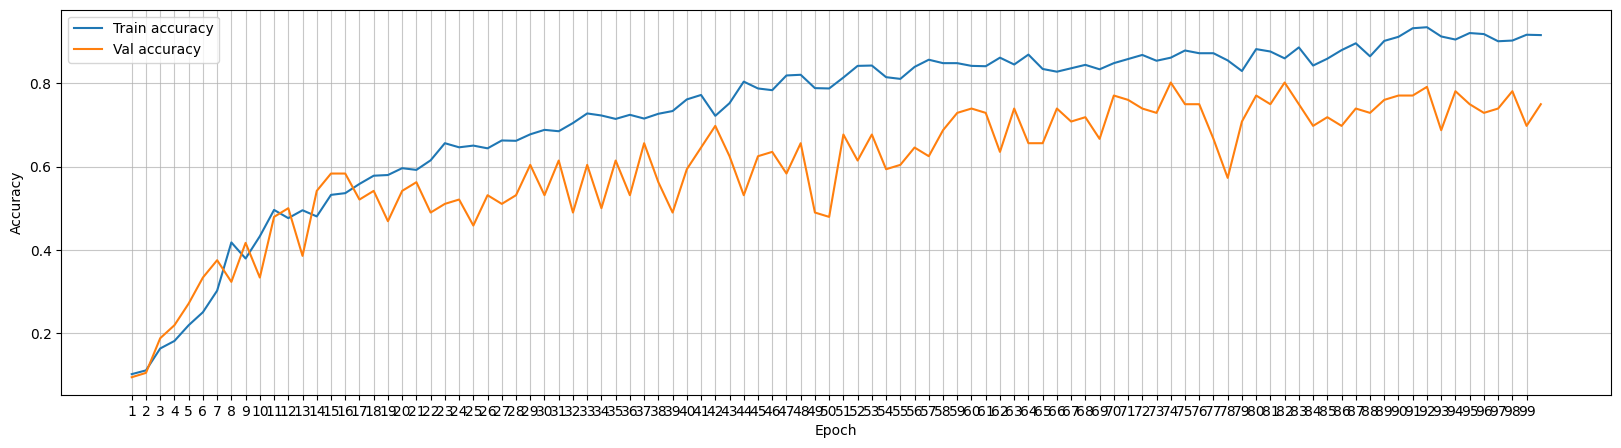

In [36]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.7375 (73.75%)

MACRO AVERAGES:
  F1-Score   : 0.7346
  Precision  : 0.7586
  Recall     : 0.7375

WEIGHTED AVERAGES:
  F1-Score   : 0.7346
  Precision  : 0.7586
  Recall     : 0.7375

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8235   0.7778     0.8750  
clock_tick      0.4286   0.5000     0.3750  
crackling_fire  0.9333   1.0000     0.8750  
crying_baby     0.7692   1.0000     0.6250  
dog             0.7619   0.6154     1.0000  
helicopter      0.6667   0.6000     0.7500  
rain            0.6250   0.6250     0.6250  
rooster         0.8235   0.7778     0.8750  
sea_waves       0.8000   0.8571     0.7500  
sneezing        0.7143   0.8333     0.6250  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.7778    0.8750    0.8235 

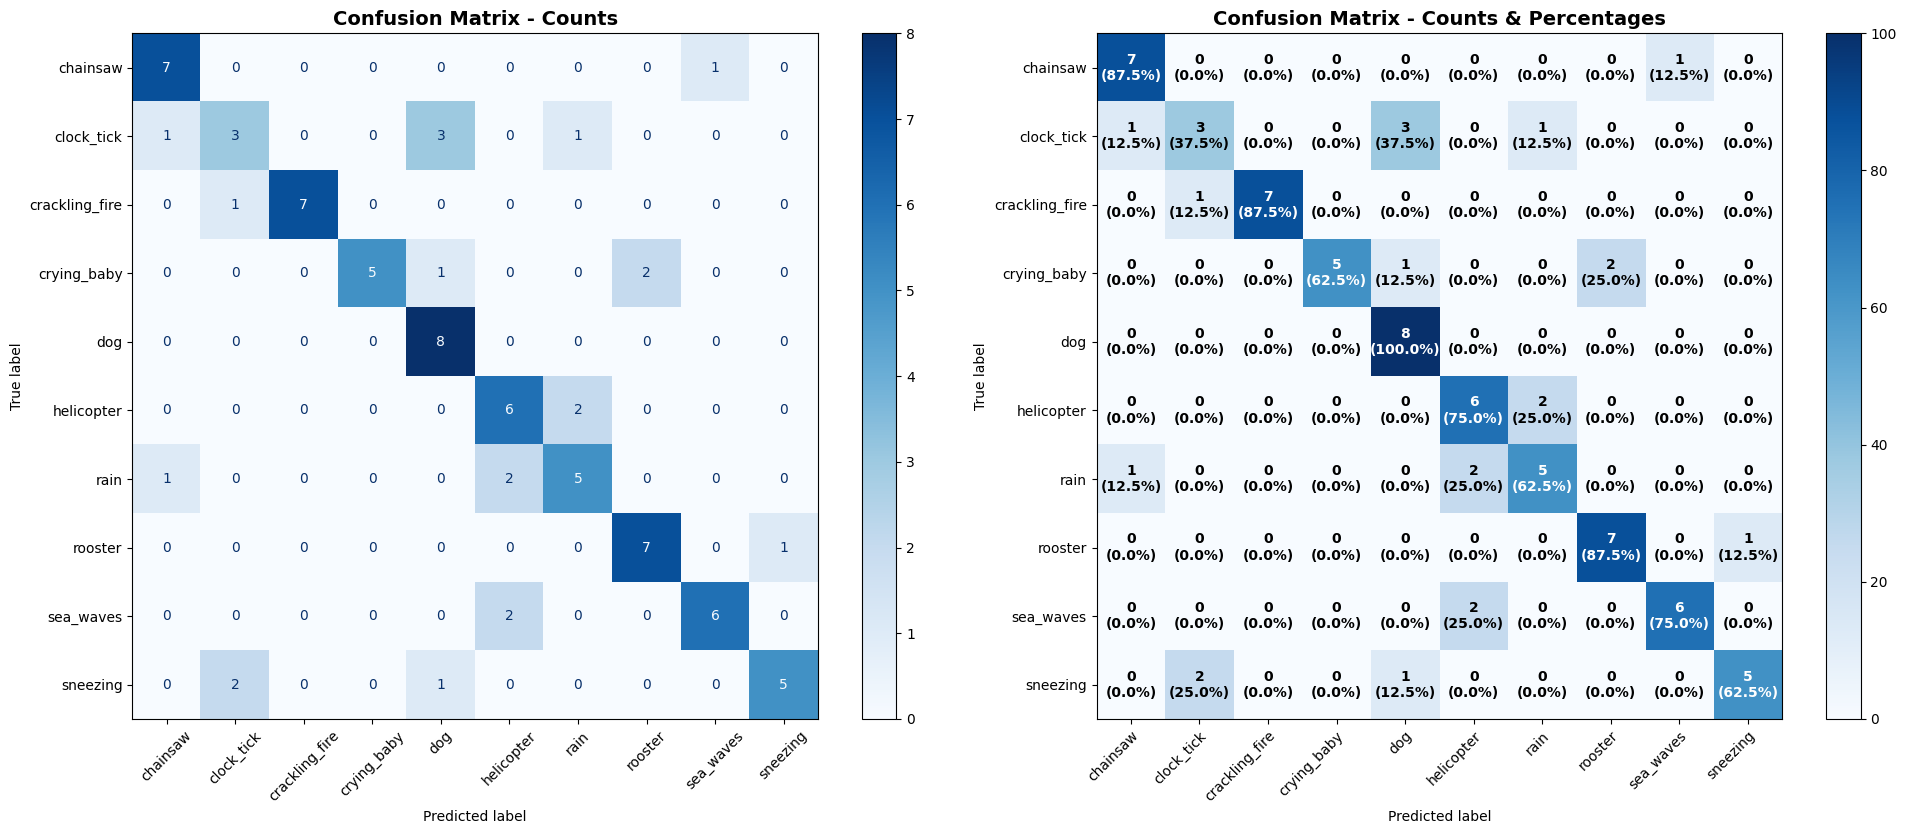


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        7        8        87.50     %
clock_tick      3        8        37.50     %
crackling_fire  7        8        87.50     %
crying_baby     5        8        62.50     %
dog             8        8        100.00    %
helicopter      6        8        75.00     %
rain            5        8        62.50     %
rooster         7        8        87.50     %
sea_waves       6        8        75.00     %
sneezing        5        8        62.50     %


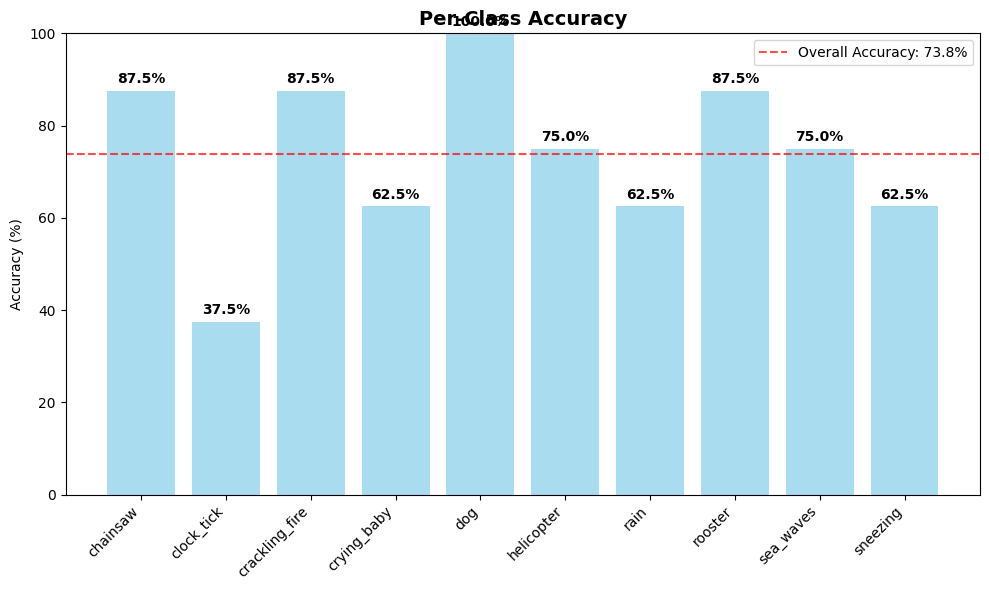

In [37]:
results_snn_tae = evaluate_model_comprehensive(tae_snn_classifier, tae_test_loader, ESCLabels.class_names, device)

##TAE: SCNN training

In [33]:
tae_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=16,
    conv_channels2=32,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(tae_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 16, 128]             64
├─Leaky: 1-2                             [32, 16, 128]             2
├─MaxPool1d: 1-3                         [32, 16, 64]              --
├─Conv1d: 1-4                            [32, 32, 64]              1,568
├─Leaky: 1-5                             [32, 32, 64]              2
├─MaxPool1d: 1-6                         [32, 32, 32]              --
├─Dropout: 1-7                           [32, 1024]                --
├─Linear: 1-8                            [32, 64]                  65,536
├─Leaky: 1-9                             [32, 64]                  2
├─Linear: 1-10                           [32, 10]                  640
├─Leaky: 1-11                            [32, 10]                  2
Total params: 67,816
Trainable params: 67,816
Non-trainable params: 0
Total mult-

In [24]:
optimizer = torch.optim.Adam(tae_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=tae_c_snn_model,
    train_loader=tae_train_loader,
    valid_loader=tae_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/content/drive/MyDrive/HumanData/utils/train_eval.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [01:40<00:00,  2.60s/it]
                                                              /content/drive/MyDrive/HumanData/utils/train_eval.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [01:45<2:54:28, 105.74s/it]


Epoch 1/100 - 105s - loss: 2.3071 - acc: 0.1036 - val_loss: 2.2950 - val_acc: 0.0833



Epochs:   2%|▏         | 2/100 [03:30<2:52:06, 105.38s/it]


Epoch 2/100 - 105s - loss: 2.3237 - acc: 0.1127 - val_loss: 2.1632 - val_acc: 0.0938



Epochs:   3%|▎         | 3/100 [05:15<2:50:02, 105.18s/it]


Epoch 3/100 - 104s - loss: 2.1465 - acc: 0.1916 - val_loss: 2.1246 - val_acc: 0.1354



Epochs:   4%|▍         | 4/100 [07:00<2:48:10, 105.11s/it]


Epoch 4/100 - 105s - loss: 2.0525 - acc: 0.2418 - val_loss: 2.0063 - val_acc: 0.1875



Epochs:   5%|▌         | 5/100 [08:46<2:46:56, 105.44s/it]


Epoch 5/100 - 106s - loss: 1.7466 - acc: 0.3840 - val_loss: 1.9420 - val_acc: 0.3125



Epochs:   6%|▌         | 6/100 [10:31<2:44:46, 105.18s/it]


Epoch 6/100 - 104s - loss: 1.7265 - acc: 0.4104 - val_loss: 1.8510 - val_acc: 0.2292



Epochs:   7%|▋         | 7/100 [12:16<2:42:52, 105.08s/it]


Epoch 7/100 - 104s - loss: 1.6077 - acc: 0.4145 - val_loss: 1.5579 - val_acc: 0.4896



Epochs:   8%|▊         | 8/100 [14:01<2:40:58, 104.98s/it]


Epoch 8/100 - 104s - loss: 1.4431 - acc: 0.4770 - val_loss: 1.4886 - val_acc: 0.4896



Epochs:   9%|▉         | 9/100 [15:45<2:39:01, 104.85s/it]


Epoch 9/100 - 104s - loss: 1.3826 - acc: 0.5271 - val_loss: 1.1867 - val_acc: 0.5208



Epochs:  10%|█         | 10/100 [17:31<2:37:33, 105.04s/it]


Epoch 10/100 - 105s - loss: 1.1971 - acc: 0.5748 - val_loss: 1.2887 - val_acc: 0.5312



Epochs:  11%|█         | 11/100 [19:16<2:35:44, 105.00s/it]


Epoch 11/100 - 104s - loss: 1.1935 - acc: 0.5773 - val_loss: 1.4139 - val_acc: 0.5000



Epochs:  12%|█▏        | 12/100 [21:01<2:34:00, 105.00s/it]


Epoch 12/100 - 105s - loss: 1.2146 - acc: 0.5609 - val_loss: 1.4361 - val_acc: 0.4896



Epochs:  13%|█▎        | 13/100 [22:45<2:32:06, 104.90s/it]


Epoch 13/100 - 104s - loss: 1.0853 - acc: 0.6077 - val_loss: 1.1104 - val_acc: 0.6042



Epochs:  14%|█▍        | 14/100 [24:30<2:30:13, 104.81s/it]


Epoch 14/100 - 104s - loss: 1.0075 - acc: 0.6143 - val_loss: 1.0721 - val_acc: 0.5833



Epochs:  15%|█▌        | 15/100 [26:15<2:28:34, 104.87s/it]


Epoch 15/100 - 105s - loss: 0.9598 - acc: 0.6562 - val_loss: 1.2589 - val_acc: 0.5729



Epochs:  16%|█▌        | 16/100 [27:59<2:26:41, 104.77s/it]


Epoch 16/100 - 104s - loss: 0.9364 - acc: 0.6488 - val_loss: 1.2297 - val_acc: 0.5208



Epochs:  17%|█▋        | 17/100 [29:44<2:24:57, 104.79s/it]


Epoch 17/100 - 104s - loss: 0.9483 - acc: 0.6488 - val_loss: 0.9629 - val_acc: 0.6146



Epochs:  18%|█▊        | 18/100 [31:29<2:23:12, 104.79s/it]


Epoch 18/100 - 104s - loss: 0.8854 - acc: 0.6686 - val_loss: 1.0907 - val_acc: 0.5625



Epochs:  19%|█▉        | 19/100 [33:14<2:21:42, 104.98s/it]


Epoch 19/100 - 105s - loss: 0.8303 - acc: 0.6891 - val_loss: 1.2180 - val_acc: 0.5938



Epochs:  20%|██        | 20/100 [35:00<2:20:22, 105.28s/it]


Epoch 20/100 - 106s - loss: 0.8309 - acc: 0.6957 - val_loss: 1.1675 - val_acc: 0.5938



Epochs:  21%|██        | 21/100 [36:46<2:18:41, 105.33s/it]


Epoch 21/100 - 105s - loss: 0.8816 - acc: 0.6801 - val_loss: 0.9034 - val_acc: 0.6979



Epochs:  22%|██▏       | 22/100 [38:31<2:16:41, 105.14s/it]


Epoch 22/100 - 104s - loss: 0.8600 - acc: 0.6785 - val_loss: 0.9413 - val_acc: 0.7188



Epochs:  23%|██▎       | 23/100 [40:15<2:14:38, 104.91s/it]


Epoch 23/100 - 104s - loss: 0.7493 - acc: 0.7253 - val_loss: 1.0093 - val_acc: 0.6562



Epochs:  24%|██▍       | 24/100 [42:00<2:12:55, 104.94s/it]


Epoch 24/100 - 105s - loss: 0.8142 - acc: 0.7056 - val_loss: 1.0013 - val_acc: 0.7083



Epochs:  25%|██▌       | 25/100 [43:45<2:11:01, 104.82s/it]


Epoch 25/100 - 104s - loss: 0.7601 - acc: 0.7220 - val_loss: 1.2378 - val_acc: 0.6250



Epochs:  26%|██▌       | 26/100 [45:30<2:09:28, 104.98s/it]


Epoch 26/100 - 105s - loss: 0.7441 - acc: 0.7286 - val_loss: 1.0948 - val_acc: 0.6875



Epochs:  27%|██▋       | 27/100 [47:15<2:07:43, 104.98s/it]


Epoch 27/100 - 104s - loss: 0.7294 - acc: 0.7434 - val_loss: 0.9084 - val_acc: 0.7188



Epochs:  28%|██▊       | 28/100 [49:00<2:05:58, 104.98s/it]


Epoch 28/100 - 104s - loss: 0.7228 - acc: 0.7146 - val_loss: 0.9752 - val_acc: 0.6771



Epochs:  29%|██▉       | 29/100 [50:45<2:04:07, 104.89s/it]


Epoch 29/100 - 104s - loss: 0.7020 - acc: 0.7393 - val_loss: 0.9740 - val_acc: 0.6771



Epochs:  30%|███       | 30/100 [52:30<2:02:26, 104.95s/it]


Epoch 30/100 - 105s - loss: 0.6754 - acc: 0.7623 - val_loss: 1.1349 - val_acc: 0.6667



Epochs:  31%|███       | 31/100 [54:15<2:00:42, 104.96s/it]


Epoch 31/100 - 104s - loss: 0.7000 - acc: 0.7303 - val_loss: 0.9907 - val_acc: 0.7292



Epochs:  32%|███▏      | 32/100 [55:59<1:58:49, 104.85s/it]


Epoch 32/100 - 104s - loss: 0.6727 - acc: 0.7558 - val_loss: 0.8714 - val_acc: 0.6979



Epochs:  33%|███▎      | 33/100 [57:44<1:57:12, 104.96s/it]


Epoch 33/100 - 105s - loss: 0.6523 - acc: 0.7599 - val_loss: 1.1857 - val_acc: 0.6354



Epochs:  34%|███▍      | 34/100 [59:29<1:55:27, 104.96s/it]


Epoch 34/100 - 104s - loss: 0.6216 - acc: 0.7796 - val_loss: 1.0281 - val_acc: 0.6979



Epochs:  35%|███▌      | 35/100 [1:01:14<1:53:37, 104.89s/it]


Epoch 35/100 - 104s - loss: 0.6031 - acc: 0.7862 - val_loss: 1.0608 - val_acc: 0.6771



Epochs:  36%|███▌      | 36/100 [1:02:59<1:51:55, 104.94s/it]


Epoch 36/100 - 105s - loss: 0.5472 - acc: 0.7928 - val_loss: 0.9353 - val_acc: 0.7188



Epochs:  37%|███▋      | 37/100 [1:04:44<1:50:03, 104.82s/it]


Epoch 37/100 - 104s - loss: 0.6204 - acc: 0.7812 - val_loss: 0.9787 - val_acc: 0.7396



Epochs:  38%|███▊      | 38/100 [1:06:28<1:48:18, 104.81s/it]


Epoch 38/100 - 104s - loss: 0.5938 - acc: 0.7878 - val_loss: 0.8901 - val_acc: 0.7292



Epochs:  39%|███▉      | 39/100 [1:08:13<1:46:27, 104.72s/it]


Epoch 39/100 - 104s - loss: 0.5443 - acc: 0.8117 - val_loss: 0.8273 - val_acc: 0.7292



Epochs:  40%|████      | 40/100 [1:09:58<1:44:45, 104.75s/it]


Epoch 40/100 - 104s - loss: 0.5128 - acc: 0.8109 - val_loss: 0.8757 - val_acc: 0.7292



Epochs:  41%|████      | 41/100 [1:11:43<1:43:08, 104.89s/it]


Epoch 41/100 - 105s - loss: 0.4902 - acc: 0.8076 - val_loss: 0.9089 - val_acc: 0.7708



Epochs:  42%|████▏     | 42/100 [1:13:28<1:41:24, 104.91s/it]


Epoch 42/100 - 104s - loss: 0.5262 - acc: 0.8084 - val_loss: 1.0176 - val_acc: 0.6875



Epochs:  43%|████▎     | 43/100 [1:15:14<1:39:54, 105.16s/it]


Epoch 43/100 - 105s - loss: 0.5063 - acc: 0.8207 - val_loss: 1.0880 - val_acc: 0.7083



Epochs:  44%|████▍     | 44/100 [1:16:59<1:38:04, 105.07s/it]


Epoch 44/100 - 104s - loss: 0.3902 - acc: 0.8627 - val_loss: 0.8333 - val_acc: 0.7188



Epochs:  45%|████▌     | 45/100 [1:18:43<1:36:14, 105.00s/it]


Epoch 45/100 - 104s - loss: 0.4681 - acc: 0.8281 - val_loss: 0.8270 - val_acc: 0.7500



Epochs:  46%|████▌     | 46/100 [1:20:29<1:34:36, 105.13s/it]


Epoch 46/100 - 105s - loss: 0.5000 - acc: 0.8150 - val_loss: 0.7598 - val_acc: 0.8021



Epochs:  47%|████▋     | 47/100 [1:22:13<1:32:43, 104.96s/it]


Epoch 47/100 - 104s - loss: 0.4285 - acc: 0.8429 - val_loss: 0.7474 - val_acc: 0.8021



Epochs:  48%|████▊     | 48/100 [1:23:59<1:31:00, 105.02s/it]


Epoch 48/100 - 105s - loss: 0.4546 - acc: 0.8380 - val_loss: 0.7918 - val_acc: 0.8021



Epochs:  49%|████▉     | 49/100 [1:25:43<1:29:02, 104.76s/it]


Epoch 49/100 - 104s - loss: 0.3798 - acc: 0.8742 - val_loss: 0.8937 - val_acc: 0.7604



Epochs:  50%|█████     | 50/100 [1:27:27<1:27:12, 104.66s/it]


Epoch 50/100 - 104s - loss: 0.4003 - acc: 0.8520 - val_loss: 1.1637 - val_acc: 0.7083



Epochs:  51%|█████     | 51/100 [1:29:13<1:25:40, 104.92s/it]


Epoch 51/100 - 105s - loss: 0.4205 - acc: 0.8487 - val_loss: 0.8884 - val_acc: 0.7292



Epochs:  52%|█████▏    | 52/100 [1:30:57<1:23:53, 104.86s/it]


Epoch 52/100 - 104s - loss: 0.3894 - acc: 0.8594 - val_loss: 0.7921 - val_acc: 0.8125



Epochs:  53%|█████▎    | 53/100 [1:32:42<1:22:08, 104.85s/it]


Epoch 53/100 - 104s - loss: 0.3739 - acc: 0.8701 - val_loss: 0.8773 - val_acc: 0.8021



Epochs:  54%|█████▍    | 54/100 [1:34:27<1:20:27, 104.95s/it]


Epoch 54/100 - 105s - loss: 0.4618 - acc: 0.8388 - val_loss: 0.9063 - val_acc: 0.7917



Epochs:  55%|█████▌    | 55/100 [1:36:12<1:18:37, 104.84s/it]


Epoch 55/100 - 104s - loss: 0.3758 - acc: 0.8610 - val_loss: 0.8563 - val_acc: 0.8125



Epochs:  56%|█████▌    | 56/100 [1:37:56<1:16:46, 104.69s/it]


Epoch 56/100 - 104s - loss: 0.3501 - acc: 0.8734 - val_loss: 0.9628 - val_acc: 0.7083



Epochs:  57%|█████▋    | 57/100 [1:39:41<1:15:05, 104.77s/it]


Epoch 57/100 - 104s - loss: 0.3606 - acc: 0.8750 - val_loss: 0.7192 - val_acc: 0.7812



Epochs:  58%|█████▊    | 58/100 [1:41:26<1:13:21, 104.79s/it]


Epoch 58/100 - 104s - loss: 0.3485 - acc: 0.8840 - val_loss: 0.9288 - val_acc: 0.8021



Epochs:  59%|█████▉    | 59/100 [1:43:11<1:11:34, 104.75s/it]


Epoch 59/100 - 104s - loss: 0.3220 - acc: 0.8882 - val_loss: 0.8121 - val_acc: 0.7917



Epochs:  60%|██████    | 60/100 [1:44:56<1:09:50, 104.75s/it]


Epoch 60/100 - 104s - loss: 0.4034 - acc: 0.8676 - val_loss: 0.8799 - val_acc: 0.7917



Epochs:  61%|██████    | 61/100 [1:46:40<1:08:02, 104.69s/it]


Epoch 61/100 - 104s - loss: 0.4025 - acc: 0.8536 - val_loss: 0.8712 - val_acc: 0.7604



Epochs:  62%|██████▏   | 62/100 [1:48:25<1:06:18, 104.70s/it]


Epoch 62/100 - 104s - loss: 0.3777 - acc: 0.8660 - val_loss: 0.7488 - val_acc: 0.8125



Epochs:  63%|██████▎   | 63/100 [1:50:09<1:04:33, 104.68s/it]


Epoch 63/100 - 104s - loss: 0.3065 - acc: 0.8988 - val_loss: 0.6890 - val_acc: 0.8021



Epochs:  64%|██████▍   | 64/100 [1:51:54<1:02:46, 104.63s/it]


Epoch 64/100 - 104s - loss: 0.3405 - acc: 0.8865 - val_loss: 0.7415 - val_acc: 0.8333



Epochs:  65%|██████▌   | 65/100 [1:53:39<1:01:04, 104.69s/it]


Epoch 65/100 - 104s - loss: 0.3380 - acc: 0.8783 - val_loss: 1.0845 - val_acc: 0.7188



Epochs:  66%|██████▌   | 66/100 [1:55:23<59:16, 104.61s/it]  


Epoch 66/100 - 104s - loss: 0.3232 - acc: 0.8898 - val_loss: 0.7368 - val_acc: 0.7917



Epochs:  67%|██████▋   | 67/100 [1:57:08<57:31, 104.60s/it]


Epoch 67/100 - 104s - loss: 0.3726 - acc: 0.8758 - val_loss: 0.8529 - val_acc: 0.8125



Epochs:  68%|██████▊   | 68/100 [1:58:53<55:51, 104.75s/it]


Epoch 68/100 - 105s - loss: 0.3746 - acc: 0.8676 - val_loss: 1.3330 - val_acc: 0.6875



Epochs:  69%|██████▉   | 69/100 [2:00:37<54:05, 104.69s/it]


Epoch 69/100 - 104s - loss: 0.3513 - acc: 0.8750 - val_loss: 1.0735 - val_acc: 0.7188



Epochs:  70%|███████   | 70/100 [2:02:22<52:22, 104.75s/it]


Epoch 70/100 - 104s - loss: 0.3636 - acc: 0.8824 - val_loss: 0.6679 - val_acc: 0.7708



Epochs:  71%|███████   | 71/100 [2:04:07<50:35, 104.66s/it]


Epoch 71/100 - 104s - loss: 0.2818 - acc: 0.8980 - val_loss: 0.5717 - val_acc: 0.8125



Epochs:  72%|███████▏  | 72/100 [2:05:51<48:49, 104.64s/it]


Epoch 72/100 - 104s - loss: 0.3266 - acc: 0.8799 - val_loss: 0.6708 - val_acc: 0.7812



Epochs:  73%|███████▎  | 73/100 [2:07:36<47:08, 104.75s/it]


Epoch 73/100 - 105s - loss: 0.2906 - acc: 0.9013 - val_loss: 0.8334 - val_acc: 0.7812



Epochs:  74%|███████▍  | 74/100 [2:09:21<45:19, 104.61s/it]


Epoch 74/100 - 104s - loss: 0.2811 - acc: 0.9137 - val_loss: 0.8108 - val_acc: 0.7812



Epochs:  75%|███████▌  | 75/100 [2:11:05<43:34, 104.57s/it]


Epoch 75/100 - 104s - loss: 0.2889 - acc: 0.8939 - val_loss: 0.7457 - val_acc: 0.8125



Epochs:  76%|███████▌  | 76/100 [2:12:50<41:52, 104.69s/it]


Epoch 76/100 - 104s - loss: 0.2794 - acc: 0.8988 - val_loss: 0.6818 - val_acc: 0.8333



Epochs:  77%|███████▋  | 77/100 [2:14:35<40:07, 104.65s/it]


Epoch 77/100 - 104s - loss: 0.2622 - acc: 0.9137 - val_loss: 0.9900 - val_acc: 0.7812



Epochs:  78%|███████▊  | 78/100 [2:16:19<38:23, 104.69s/it]


Epoch 78/100 - 104s - loss: 0.2499 - acc: 0.9120 - val_loss: 0.6663 - val_acc: 0.8229



Epochs:  79%|███████▉  | 79/100 [2:18:04<36:37, 104.62s/it]


Epoch 79/100 - 104s - loss: 0.2705 - acc: 0.9104 - val_loss: 0.8046 - val_acc: 0.8125



Epochs:  80%|████████  | 80/100 [2:19:48<34:52, 104.61s/it]


Epoch 80/100 - 104s - loss: 0.2599 - acc: 0.9054 - val_loss: 0.8275 - val_acc: 0.7292



Epochs:  81%|████████  | 81/100 [2:21:33<33:09, 104.72s/it]


Epoch 81/100 - 104s - loss: 0.3910 - acc: 0.8660 - val_loss: 0.8521 - val_acc: 0.7396



Epochs:  82%|████████▏ | 82/100 [2:23:18<31:25, 104.72s/it]


Epoch 82/100 - 104s - loss: 0.2346 - acc: 0.9153 - val_loss: 0.7985 - val_acc: 0.7604



Epochs:  83%|████████▎ | 83/100 [2:25:03<29:38, 104.62s/it]


Epoch 83/100 - 104s - loss: 0.2577 - acc: 0.9087 - val_loss: 0.6048 - val_acc: 0.7917



Epochs:  84%|████████▍ | 84/100 [2:26:48<27:59, 104.96s/it]


Epoch 84/100 - 105s - loss: 0.2417 - acc: 0.9137 - val_loss: 0.8078 - val_acc: 0.8125



Epochs:  85%|████████▌ | 85/100 [2:28:33<26:12, 104.83s/it]


Epoch 85/100 - 104s - loss: 0.2837 - acc: 0.9021 - val_loss: 0.7860 - val_acc: 0.8125



Epochs:  86%|████████▌ | 86/100 [2:30:18<24:27, 104.80s/it]


Epoch 86/100 - 104s - loss: 0.2379 - acc: 0.9169 - val_loss: 0.6822 - val_acc: 0.7917



Epochs:  87%|████████▋ | 87/100 [2:32:02<22:42, 104.81s/it]


Epoch 87/100 - 104s - loss: 0.2107 - acc: 0.9309 - val_loss: 0.7623 - val_acc: 0.7917



Epochs:  88%|████████▊ | 88/100 [2:33:47<20:57, 104.77s/it]


Epoch 88/100 - 104s - loss: 0.2238 - acc: 0.9202 - val_loss: 0.7258 - val_acc: 0.8542



Epochs:  89%|████████▉ | 89/100 [2:35:32<19:13, 104.83s/it]


Epoch 89/100 - 104s - loss: 0.2073 - acc: 0.9367 - val_loss: 0.7484 - val_acc: 0.8438



Epochs:  90%|█████████ | 90/100 [2:37:17<17:28, 104.89s/it]


Epoch 90/100 - 105s - loss: 0.2491 - acc: 0.9128 - val_loss: 0.7613 - val_acc: 0.8333



Epochs:  91%|█████████ | 91/100 [2:39:02<15:44, 105.00s/it]


Epoch 91/100 - 105s - loss: 0.2484 - acc: 0.9169 - val_loss: 0.6292 - val_acc: 0.8333



Epochs:  92%|█████████▏| 92/100 [2:40:48<14:01, 105.16s/it]


Epoch 92/100 - 105s - loss: 0.2347 - acc: 0.9161 - val_loss: 0.9198 - val_acc: 0.8229



Epochs:  93%|█████████▎| 93/100 [2:42:33<12:15, 105.12s/it]


Epoch 93/100 - 105s - loss: 0.1975 - acc: 0.9301 - val_loss: 0.7648 - val_acc: 0.8438



Epochs:  94%|█████████▍| 94/100 [2:44:18<10:30, 105.16s/it]


Epoch 94/100 - 105s - loss: 0.2316 - acc: 0.9227 - val_loss: 1.0646 - val_acc: 0.7604



Epochs:  95%|█████████▌| 95/100 [2:46:04<08:46, 105.23s/it]


Epoch 95/100 - 105s - loss: 0.2211 - acc: 0.9219 - val_loss: 0.7936 - val_acc: 0.8333



Epochs:  96%|█████████▌| 96/100 [2:47:48<07:00, 105.03s/it]


Epoch 96/100 - 104s - loss: 0.1880 - acc: 0.9334 - val_loss: 0.7290 - val_acc: 0.8333



Epochs:  97%|█████████▋| 97/100 [2:49:33<05:15, 105.09s/it]


Epoch 97/100 - 105s - loss: 0.2663 - acc: 0.9145 - val_loss: 0.8166 - val_acc: 0.8125



Epochs:  98%|█████████▊| 98/100 [2:51:18<03:30, 105.01s/it]


Epoch 98/100 - 104s - loss: 0.2323 - acc: 0.9243 - val_loss: 0.7872 - val_acc: 0.8333



Epochs:  99%|█████████▉| 99/100 [2:53:03<01:45, 105.02s/it]


Epoch 99/100 - 105s - loss: 0.1881 - acc: 0.9350 - val_loss: 0.8111 - val_acc: 0.8333



Epochs: 100%|██████████| 100/100 [2:54:48<00:00, 104.88s/it]


Epoch 100/100 - 104s - loss: 0.1432 - acc: 0.9523 - val_loss: 0.9273 - val_acc: 0.7917


In [32]:
torch.save(tae_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/tae/tae_scnn.pth')

##TAE: SCNN evaluation

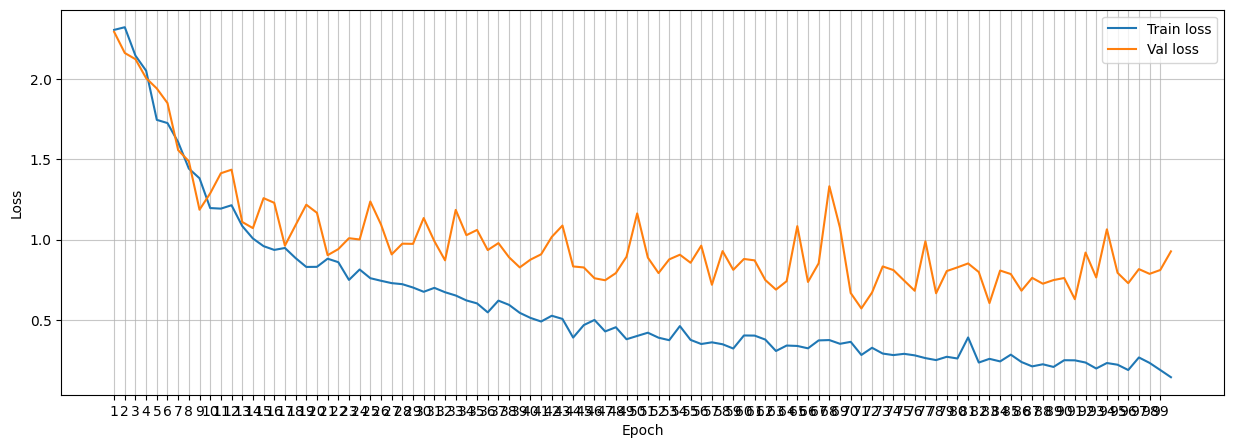

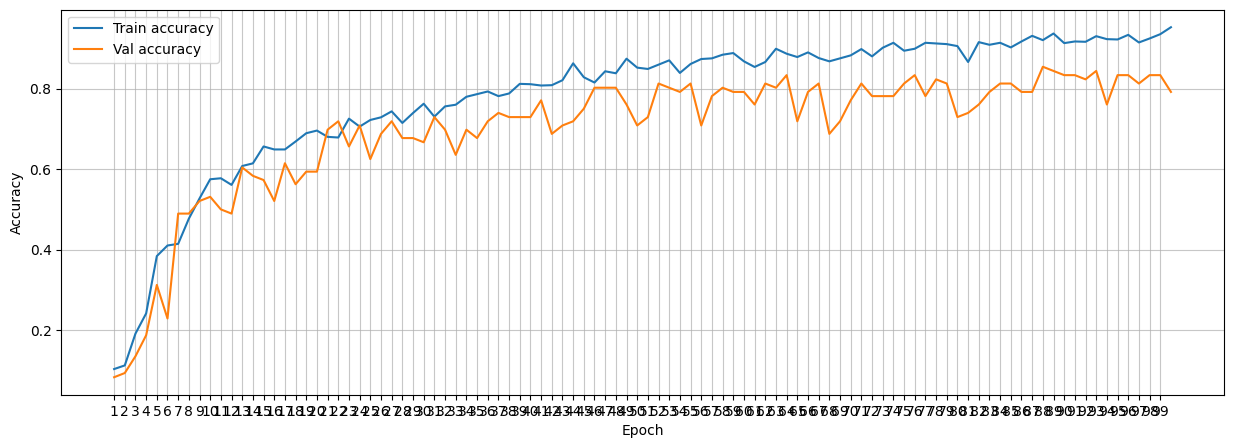

In [25]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.7750 (77.50%)

MACRO AVERAGES:
  F1-Score   : 0.7715
  Precision  : 0.8167
  Recall     : 0.7750

WEIGHTED AVERAGES:
  F1-Score   : 0.7715
  Precision  : 0.8167
  Recall     : 0.7750

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8571   1.0000     0.7500  
clock_tick      0.7368   0.6364     0.8750  
crackling_fire  0.8421   0.7273     1.0000  
crying_baby     1.0000   1.0000     1.0000  
dog             0.5455   1.0000     0.3750  
helicopter      0.8571   1.0000     0.7500  
rain            0.5000   0.5000     0.5000  
rooster         0.9333   1.0000     0.8750  
sea_waves       0.7368   0.6364     0.8750  
sneezing        0.7059   0.6667     0.7500  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     1.0000    0.7500    0.8571 

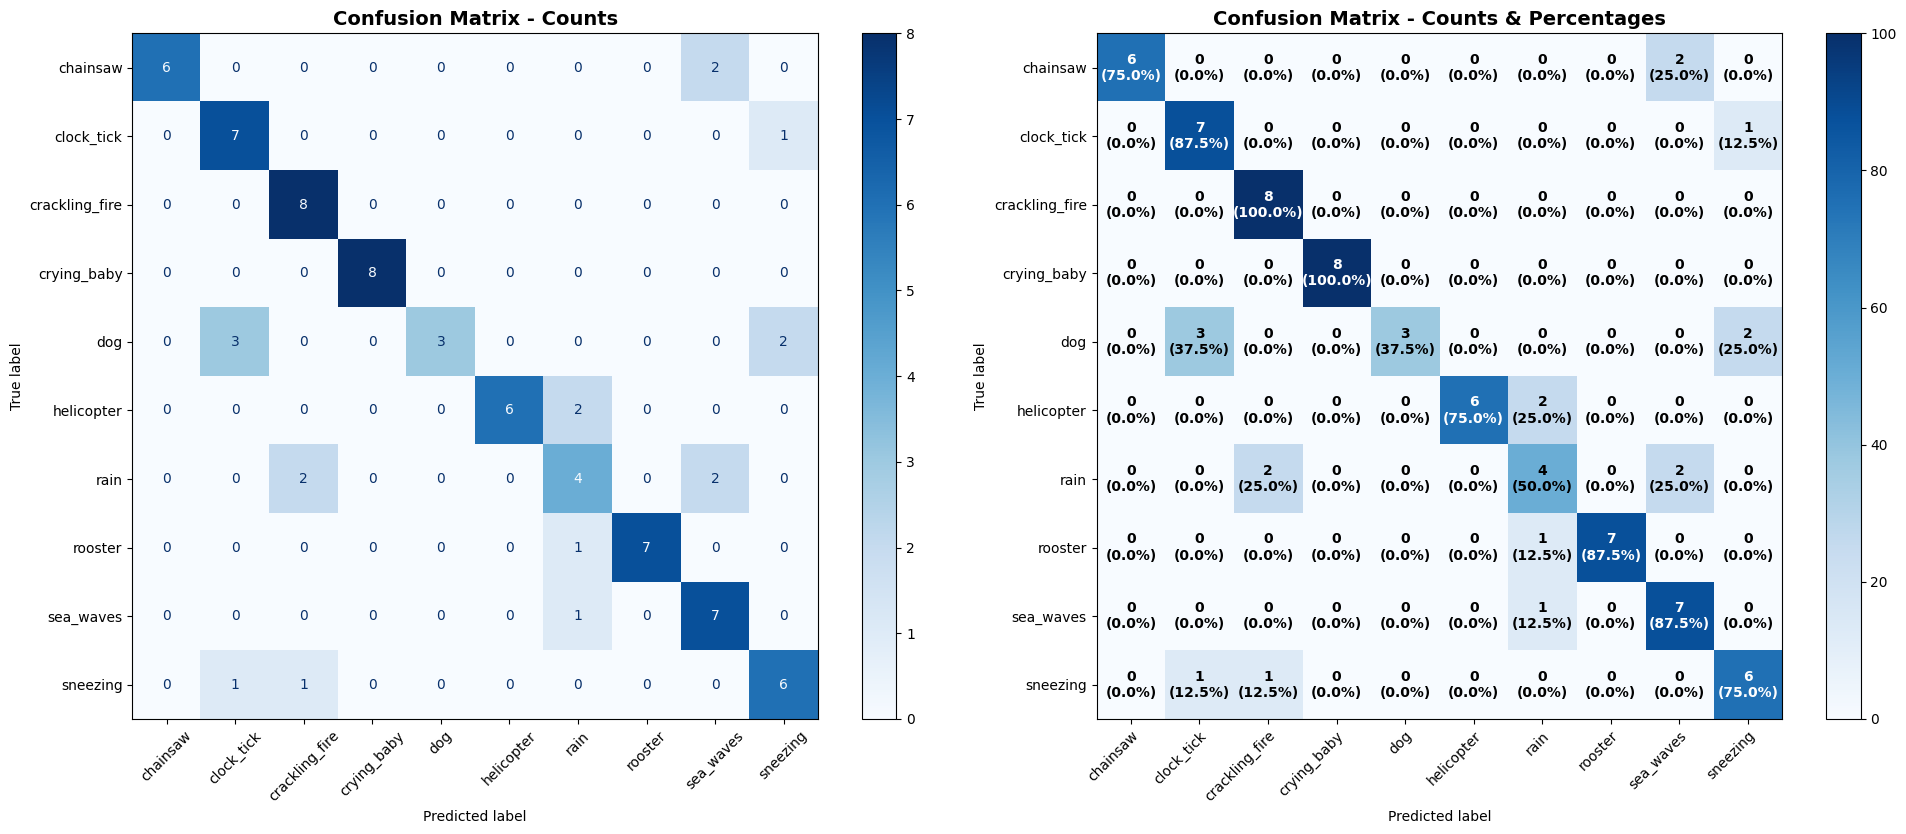


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        6        8        75.00     %
clock_tick      7        8        87.50     %
crackling_fire  8        8        100.00    %
crying_baby     8        8        100.00    %
dog             3        8        37.50     %
helicopter      6        8        75.00     %
rain            4        8        50.00     %
rooster         7        8        87.50     %
sea_waves       7        8        87.50     %
sneezing        6        8        75.00     %


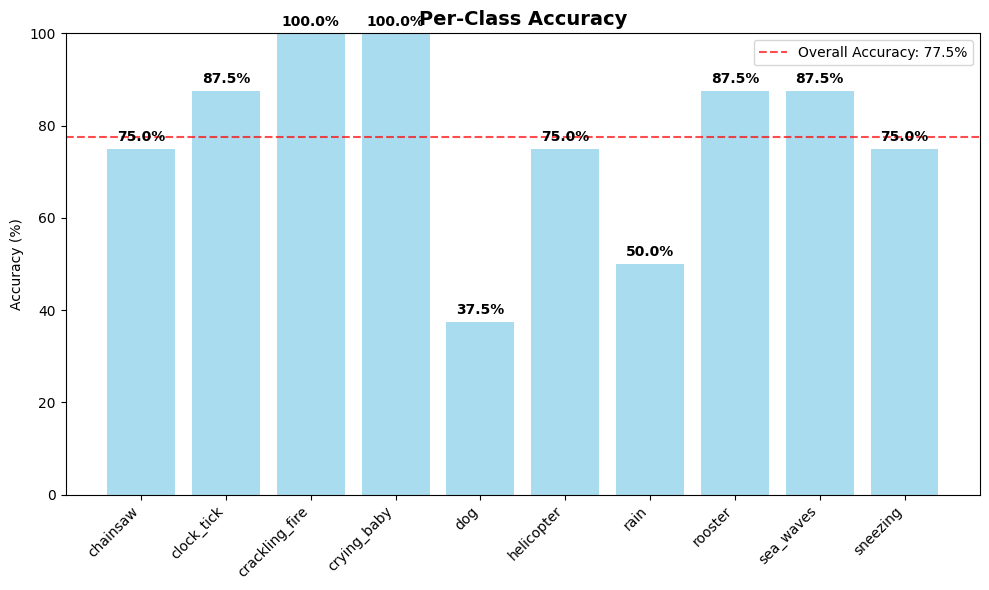

In [27]:
results_scnn_tae = evaluate_model_comprehensive(tae_c_snn_model, tae_test_loader, ESCLabels.class_names, device)

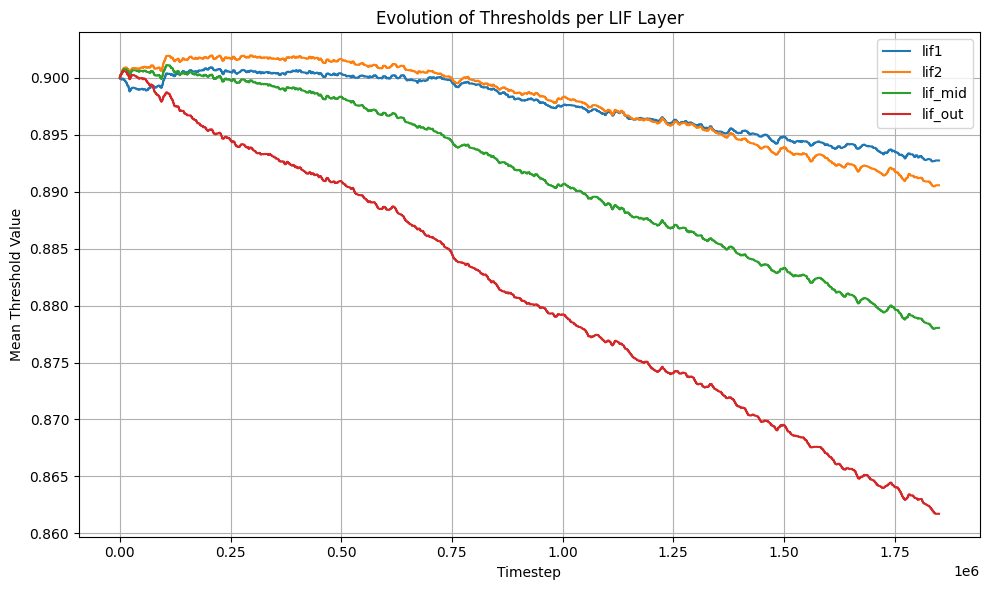

In [34]:
logs = tae_c_snn_model.threshold_logs

# Plotting the threshold evolution
plt.figure(figsize=(10, 6))
for key, values in logs.items():
    plt.plot(values, label=key)

plt.title("Evolution of Thresholds per LIF Layer")
plt.xlabel("Timestep")
plt.ylabel("Mean Threshold Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Spike Encoding: Step Forward

In [38]:
sf_train_dataset = StepForwardDataset(X_train_tensor, y_train_tensor)
sf_val_dataset = StepForwardDataset(X_val_tensor, y_val_tensor)
sf_test_dataset = StepForwardDataset(X_test_tensor, y_test_tensor)

In [39]:
sf_train_loader = DataLoader(sf_train_dataset,batch_size=BATCH_SIZE,shuffle=True,
                             num_workers=2,pin_memory=torch.cuda.is_available())

sf_val_loader = DataLoader(sf_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=2, pin_memory=torch.cuda.is_available())

sf_test_loader = DataLoader(sf_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, pin_memory=torch.cuda.is_available())

In [40]:
sf_X_batch, sf_y_batch = next(iter(sf_train_loader))
print("Step Forward encoding compleated!")

Step Forward encoding compleated!


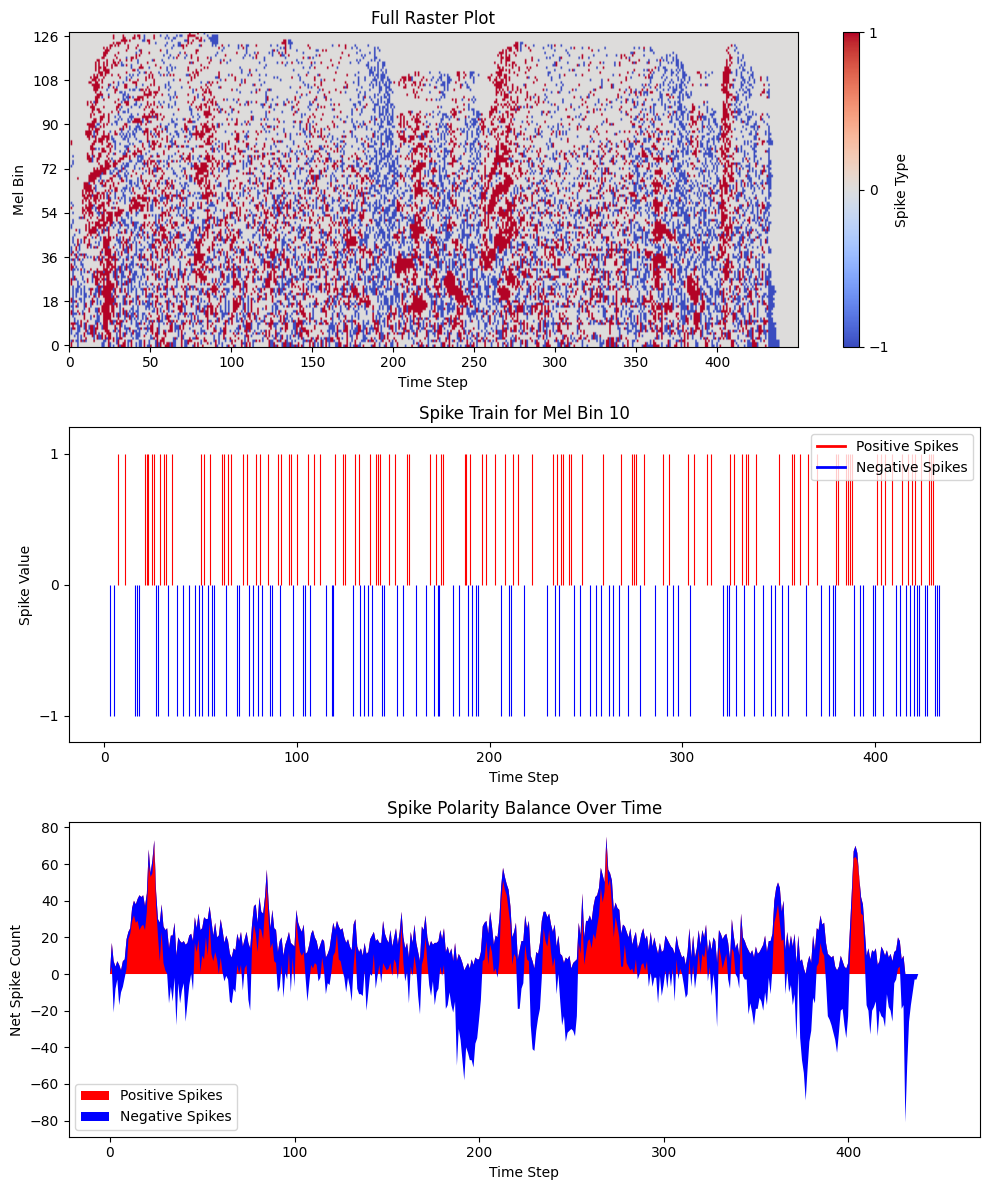

TAE Class: crying_baby


In [41]:
sample_idx = 10
visualize_spike_trains(sf_X_batch, sample_idx=sample_idx, mel_bin=10)
print(f"TAE Class: {ESCLabels.index_to_label[sf_y_batch[sample_idx].item()]}")

##Step Forward: SNN training

In [42]:
sf_snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(sf_snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 128]                 16,512
├─Leaky: 1-6                             [32, 128]                 129
├─Linear: 1-7                            [32, 10]                  1,290
├─Leaky: 1-8                             [32, 10]                  11
Total params: 51,224
Trainable params: 51,224
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.63
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.20
Estimated Total Size (MB): 0.42

In [43]:
optimizer = torch.optim.Adam(sf_snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=sf_snn_classifier,
    train_loader=sf_train_loader,
    valid_loader=sf_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    device=device,
    verbose=True,
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/content/drive/MyDrive/HumanData/utils/train_eval.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [02:01<00:00,  2.46s/it]
                                                              /content/drive/MyDrive/HumanData/utils/train_eval.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [02:09<3:33:29, 129.39s/it]


Epoch 1/100 - 129s - loss: 2.3026 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [04:16<3:29:05, 128.02s/it]


Epoch 2/100 - 127s - loss: 2.2924 - acc: 0.1423 - val_loss: 2.2269 - val_acc: 0.1562



Epochs:   3%|▎         | 3/100 [06:25<3:27:45, 128.51s/it]


Epoch 3/100 - 129s - loss: 2.3488 - acc: 0.1653 - val_loss: 2.3092 - val_acc: 0.1250



Epochs:   4%|▍         | 4/100 [08:33<3:25:07, 128.21s/it]


Epoch 4/100 - 127s - loss: 2.2825 - acc: 0.1842 - val_loss: 2.2776 - val_acc: 0.1250



Epochs:   5%|▌         | 5/100 [10:42<3:23:18, 128.41s/it]


Epoch 5/100 - 128s - loss: 2.2876 - acc: 0.1900 - val_loss: 2.2852 - val_acc: 0.2396



Epochs:   6%|▌         | 6/100 [12:51<3:21:57, 128.91s/it]


Epoch 6/100 - 129s - loss: 2.1709 - acc: 0.2336 - val_loss: 2.0754 - val_acc: 0.3125



Epochs:   7%|▋         | 7/100 [15:00<3:19:28, 128.69s/it]


Epoch 7/100 - 128s - loss: 4.0987 - acc: 0.3109 - val_loss: 2.0984 - val_acc: 0.3333



Epochs:   8%|▊         | 8/100 [17:08<3:16:55, 128.43s/it]


Epoch 8/100 - 127s - loss: 1.8694 - acc: 0.3627 - val_loss: 2.0043 - val_acc: 0.2917



Epochs:   9%|▉         | 9/100 [19:15<3:14:05, 127.97s/it]


Epoch 9/100 - 126s - loss: 2.1731 - acc: 0.3857 - val_loss: 1.9410 - val_acc: 0.3646



Epochs:  10%|█         | 10/100 [21:23<3:12:06, 128.07s/it]


Epoch 10/100 - 128s - loss: 1.7682 - acc: 0.4120 - val_loss: 2.0262 - val_acc: 0.3854



Epochs:  11%|█         | 11/100 [23:31<3:10:06, 128.16s/it]


Epoch 11/100 - 128s - loss: 1.7224 - acc: 0.4317 - val_loss: 1.9875 - val_acc: 0.3750



Epochs:  12%|█▏        | 12/100 [25:37<3:07:06, 127.57s/it]


Epoch 12/100 - 126s - loss: 1.6861 - acc: 0.4334 - val_loss: 1.6072 - val_acc: 0.4583



Epochs:  13%|█▎        | 13/100 [27:46<3:05:31, 127.95s/it]


Epoch 13/100 - 128s - loss: 1.5029 - acc: 0.4745 - val_loss: 2.5108 - val_acc: 0.3125



Epochs:  14%|█▍        | 14/100 [29:54<3:03:06, 127.75s/it]


Epoch 14/100 - 127s - loss: 1.7486 - acc: 0.4655 - val_loss: 1.7795 - val_acc: 0.4688



Epochs:  15%|█▌        | 15/100 [32:02<3:01:27, 128.09s/it]


Epoch 15/100 - 128s - loss: 1.5455 - acc: 0.5255 - val_loss: 1.6603 - val_acc: 0.4896



Epochs:  16%|█▌        | 16/100 [34:09<2:58:50, 127.74s/it]


Epoch 16/100 - 126s - loss: 1.7106 - acc: 0.5090 - val_loss: 1.3537 - val_acc: 0.5729



Epochs:  17%|█▋        | 17/100 [36:18<2:56:59, 127.95s/it]


Epoch 17/100 - 128s - loss: 1.4845 - acc: 0.5551 - val_loss: 1.8234 - val_acc: 0.3854



Epochs:  18%|█▊        | 18/100 [38:25<2:54:27, 127.66s/it]


Epoch 18/100 - 126s - loss: 1.5947 - acc: 0.5477 - val_loss: 1.7830 - val_acc: 0.5417



Epochs:  19%|█▉        | 19/100 [40:31<2:51:51, 127.30s/it]


Epoch 19/100 - 126s - loss: 1.4998 - acc: 0.5691 - val_loss: 1.5278 - val_acc: 0.6354



Epochs:  20%|██        | 20/100 [42:38<2:49:32, 127.15s/it]


Epoch 20/100 - 126s - loss: 1.1883 - acc: 0.6275 - val_loss: 1.3576 - val_acc: 0.6562



Epochs:  21%|██        | 21/100 [44:45<2:47:12, 127.00s/it]


Epoch 21/100 - 126s - loss: 1.2195 - acc: 0.6258 - val_loss: 1.7843 - val_acc: 0.5625



Epochs:  22%|██▏       | 22/100 [46:51<2:44:57, 126.89s/it]


Epoch 22/100 - 126s - loss: 1.3416 - acc: 0.6102 - val_loss: 1.8495 - val_acc: 0.6146



Epochs:  23%|██▎       | 23/100 [48:59<2:43:09, 127.14s/it]


Epoch 23/100 - 127s - loss: 1.2095 - acc: 0.6546 - val_loss: 1.8923 - val_acc: 0.4896



Epochs:  24%|██▍       | 24/100 [51:07<2:41:23, 127.42s/it]


Epoch 24/100 - 128s - loss: 1.3508 - acc: 0.6340 - val_loss: 1.8821 - val_acc: 0.5938



Epochs:  25%|██▌       | 25/100 [53:13<2:38:51, 127.09s/it]


Epoch 25/100 - 126s - loss: 1.1176 - acc: 0.6743 - val_loss: 1.9939 - val_acc: 0.5729



Epochs:  26%|██▌       | 26/100 [55:22<2:37:21, 127.59s/it]


Epoch 26/100 - 128s - loss: 1.0819 - acc: 0.6834 - val_loss: 1.9957 - val_acc: 0.4688



Epochs:  27%|██▋       | 27/100 [57:29<2:34:56, 127.34s/it]


Epoch 27/100 - 126s - loss: 1.0602 - acc: 0.6743 - val_loss: 1.8963 - val_acc: 0.6354



Epochs:  28%|██▊       | 28/100 [59:38<2:33:20, 127.79s/it]


Epoch 28/100 - 128s - loss: 1.1403 - acc: 0.7023 - val_loss: 2.1451 - val_acc: 0.5104



Epochs:  29%|██▉       | 29/100 [1:01:45<2:31:06, 127.70s/it]


Epoch 29/100 - 127s - loss: 0.9475 - acc: 0.7072 - val_loss: 2.0376 - val_acc: 0.5833



Epochs:  30%|███       | 30/100 [1:03:53<2:29:08, 127.83s/it]


Epoch 30/100 - 128s - loss: 0.9920 - acc: 0.6982 - val_loss: 2.2121 - val_acc: 0.4896



Epochs:  31%|███       | 31/100 [1:06:00<2:26:43, 127.59s/it]


Epoch 31/100 - 127s - loss: 0.9509 - acc: 0.7336 - val_loss: 1.4008 - val_acc: 0.6458



Epochs:  32%|███▏      | 32/100 [1:08:07<2:24:21, 127.37s/it]


Epoch 32/100 - 126s - loss: 1.0090 - acc: 0.7130 - val_loss: 2.3516 - val_acc: 0.5417



Epochs:  33%|███▎      | 33/100 [1:10:17<2:23:03, 128.11s/it]


Epoch 33/100 - 129s - loss: 0.9557 - acc: 0.7327 - val_loss: 1.6148 - val_acc: 0.5729



Epochs:  34%|███▍      | 34/100 [1:12:30<2:22:30, 129.56s/it]


Epoch 34/100 - 132s - loss: 0.8416 - acc: 0.7459 - val_loss: 1.5076 - val_acc: 0.6146



Epochs:  35%|███▌      | 35/100 [1:14:38<2:19:48, 129.05s/it]


Epoch 35/100 - 127s - loss: 0.7144 - acc: 0.7821 - val_loss: 1.5879 - val_acc: 0.6458



Epochs:  36%|███▌      | 36/100 [1:16:47<2:17:33, 128.96s/it]


Epoch 36/100 - 128s - loss: 0.7504 - acc: 0.7681 - val_loss: 2.4006 - val_acc: 0.5938



Epochs:  37%|███▋      | 37/100 [1:18:54<2:14:51, 128.43s/it]


Epoch 37/100 - 127s - loss: 0.8448 - acc: 0.7599 - val_loss: 1.0480 - val_acc: 0.6979



Epochs:  38%|███▊      | 38/100 [1:21:03<2:12:56, 128.65s/it]


Epoch 38/100 - 129s - loss: 0.6765 - acc: 0.8018 - val_loss: 1.3436 - val_acc: 0.6667



Epochs:  39%|███▉      | 39/100 [1:23:10<2:10:25, 128.28s/it]


Epoch 39/100 - 127s - loss: 0.7273 - acc: 0.7887 - val_loss: 1.5086 - val_acc: 0.6354



Epochs:  40%|████      | 40/100 [1:25:18<2:08:01, 128.02s/it]


Epoch 40/100 - 127s - loss: 0.7188 - acc: 0.7952 - val_loss: 1.4858 - val_acc: 0.6458



Epochs:  41%|████      | 41/100 [1:27:25<2:05:44, 127.87s/it]


Epoch 41/100 - 127s - loss: 0.6627 - acc: 0.8018 - val_loss: 1.3034 - val_acc: 0.6771



Epochs:  42%|████▏     | 42/100 [1:29:33<2:03:26, 127.69s/it]


Epoch 42/100 - 127s - loss: 0.6782 - acc: 0.7969 - val_loss: 1.8135 - val_acc: 0.7604



Epochs:  43%|████▎     | 43/100 [1:31:41<2:01:24, 127.80s/it]


Epoch 43/100 - 128s - loss: 0.6779 - acc: 0.7969 - val_loss: 1.5487 - val_acc: 0.6979



Epochs:  44%|████▍     | 44/100 [1:33:48<1:59:01, 127.53s/it]


Epoch 44/100 - 126s - loss: 0.6570 - acc: 0.8076 - val_loss: 1.5662 - val_acc: 0.6354



Epochs:  45%|████▌     | 45/100 [1:35:56<1:57:11, 127.84s/it]


Epoch 45/100 - 128s - loss: 0.5736 - acc: 0.8396 - val_loss: 1.4775 - val_acc: 0.6667



Epochs:  46%|████▌     | 46/100 [1:38:03<1:54:50, 127.59s/it]


Epoch 46/100 - 127s - loss: 0.5840 - acc: 0.8396 - val_loss: 1.8925 - val_acc: 0.6875



Epochs:  47%|████▋     | 47/100 [1:40:12<1:52:59, 127.92s/it]


Epoch 47/100 - 128s - loss: 0.8280 - acc: 0.7993 - val_loss: 1.5145 - val_acc: 0.6562



Epochs:  48%|████▊     | 48/100 [1:42:20<1:51:00, 128.09s/it]


Epoch 48/100 - 128s - loss: 0.6084 - acc: 0.8158 - val_loss: 1.3875 - val_acc: 0.7500



Epochs:  49%|████▉     | 49/100 [1:44:28<1:48:42, 127.89s/it]


Epoch 49/100 - 127s - loss: 0.5773 - acc: 0.8396 - val_loss: 1.5618 - val_acc: 0.6458



Epochs:  50%|█████     | 50/100 [1:46:36<1:46:42, 128.05s/it]


Epoch 50/100 - 128s - loss: 0.6316 - acc: 0.8109 - val_loss: 1.0297 - val_acc: 0.7812



Epochs:  51%|█████     | 51/100 [1:48:44<1:44:24, 127.85s/it]


Epoch 51/100 - 127s - loss: 0.5174 - acc: 0.8561 - val_loss: 1.1817 - val_acc: 0.7604



Epochs:  52%|█████▏    | 52/100 [1:50:52<1:42:25, 128.03s/it]


Epoch 52/100 - 128s - loss: 0.5842 - acc: 0.8536 - val_loss: 1.9450 - val_acc: 0.6250



Epochs:  53%|█████▎    | 53/100 [1:52:59<1:39:58, 127.62s/it]


Epoch 53/100 - 126s - loss: 0.5334 - acc: 0.8454 - val_loss: 1.7844 - val_acc: 0.6875



Epochs:  54%|█████▍    | 54/100 [1:55:07<1:38:05, 127.95s/it]


Epoch 54/100 - 128s - loss: 0.5522 - acc: 0.8396 - val_loss: 2.0549 - val_acc: 0.6458



Epochs:  55%|█████▌    | 55/100 [1:57:16<1:36:11, 128.26s/it]


Epoch 55/100 - 128s - loss: 0.5568 - acc: 0.8487 - val_loss: 1.1455 - val_acc: 0.7500



Epochs:  56%|█████▌    | 56/100 [1:59:24<1:33:56, 128.10s/it]


Epoch 56/100 - 127s - loss: 0.5849 - acc: 0.8232 - val_loss: 1.3913 - val_acc: 0.6875



Epochs:  57%|█████▋    | 57/100 [2:01:34<1:32:06, 128.53s/it]


Epoch 57/100 - 129s - loss: 0.6451 - acc: 0.8413 - val_loss: 1.9446 - val_acc: 0.6875



Epochs:  58%|█████▊    | 58/100 [2:03:41<1:29:49, 128.31s/it]


Epoch 58/100 - 127s - loss: 0.6326 - acc: 0.8520 - val_loss: 1.6699 - val_acc: 0.7083



Epochs:  59%|█████▉    | 59/100 [2:05:57<1:29:11, 130.52s/it]


Epoch 59/100 - 135s - loss: 0.7457 - acc: 0.8322 - val_loss: 1.5263 - val_acc: 0.6875



Epochs:  60%|██████    | 60/100 [2:08:10<1:27:22, 131.07s/it]


Epoch 60/100 - 132s - loss: 0.6755 - acc: 0.8602 - val_loss: 1.9323 - val_acc: 0.7604



Epochs:  61%|██████    | 61/100 [2:10:21<1:25:18, 131.25s/it]


Epoch 61/100 - 131s - loss: 0.6111 - acc: 0.8512 - val_loss: 1.8592 - val_acc: 0.6458



Epochs:  62%|██████▏   | 62/100 [2:12:32<1:23:06, 131.22s/it]


Epoch 62/100 - 131s - loss: 0.6666 - acc: 0.8569 - val_loss: 1.1821 - val_acc: 0.7188



Epochs:  63%|██████▎   | 63/100 [2:14:40<1:20:21, 130.30s/it]


Epoch 63/100 - 128s - loss: 0.6060 - acc: 0.8503 - val_loss: 1.9385 - val_acc: 0.7083



Epochs:  64%|██████▍   | 64/100 [2:16:49<1:17:56, 129.90s/it]


Epoch 64/100 - 128s - loss: 0.5062 - acc: 0.8627 - val_loss: 1.7591 - val_acc: 0.6875



Epochs:  65%|██████▌   | 65/100 [2:18:57<1:15:26, 129.32s/it]


Epoch 65/100 - 127s - loss: 0.6479 - acc: 0.8495 - val_loss: 2.0314 - val_acc: 0.5833



Epochs:  66%|██████▌   | 66/100 [2:21:05<1:12:56, 128.71s/it]


Epoch 66/100 - 127s - loss: 0.6649 - acc: 0.8553 - val_loss: 1.8155 - val_acc: 0.7188



Epochs:  67%|██████▋   | 67/100 [2:23:14<1:10:57, 129.02s/it]


Epoch 67/100 - 129s - loss: 0.5999 - acc: 0.8586 - val_loss: 2.0461 - val_acc: 0.6458



Epochs:  68%|██████▊   | 68/100 [2:25:23<1:08:47, 128.97s/it]


Epoch 68/100 - 128s - loss: 0.6588 - acc: 0.8503 - val_loss: 1.8072 - val_acc: 0.7500



Epochs:  69%|██████▉   | 69/100 [2:27:31<1:06:27, 128.61s/it]


Epoch 69/100 - 127s - loss: 0.4234 - acc: 0.8857 - val_loss: 1.3674 - val_acc: 0.7500



Epochs:  70%|███████   | 70/100 [2:29:39<1:04:16, 128.54s/it]


Epoch 70/100 - 128s - loss: 0.4476 - acc: 0.8865 - val_loss: 1.6635 - val_acc: 0.7812



Epochs:  71%|███████   | 71/100 [2:31:46<1:01:53, 128.07s/it]


Epoch 71/100 - 126s - loss: 0.4276 - acc: 0.9120 - val_loss: 1.3860 - val_acc: 0.7083



Epochs:  72%|███████▏  | 72/100 [2:33:56<59:54, 128.38s/it]  


Epoch 72/100 - 129s - loss: 0.4292 - acc: 0.8980 - val_loss: 1.9648 - val_acc: 0.7500



Epochs:  73%|███████▎  | 73/100 [2:36:03<57:42, 128.26s/it]


Epoch 73/100 - 127s - loss: 0.4064 - acc: 0.9013 - val_loss: 1.5174 - val_acc: 0.7812



Epochs:  74%|███████▍  | 74/100 [2:38:12<55:39, 128.42s/it]


Epoch 74/100 - 128s - loss: 0.4745 - acc: 0.8906 - val_loss: 2.2025 - val_acc: 0.7188



Epochs:  75%|███████▌  | 75/100 [2:40:22<53:36, 128.66s/it]


Epoch 75/100 - 129s - loss: 0.3875 - acc: 0.8980 - val_loss: 1.7709 - val_acc: 0.7708



Epochs:  76%|███████▌  | 76/100 [2:42:29<51:17, 128.23s/it]


Epoch 76/100 - 127s - loss: 0.4945 - acc: 0.8997 - val_loss: 1.4443 - val_acc: 0.7812



Epochs:  77%|███████▋  | 77/100 [2:44:39<49:20, 128.71s/it]


Epoch 77/100 - 129s - loss: 0.4653 - acc: 0.8997 - val_loss: 2.0474 - val_acc: 0.7188



Epochs:  78%|███████▊  | 78/100 [2:46:48<47:19, 129.07s/it]


Epoch 78/100 - 129s - loss: 0.4195 - acc: 0.9038 - val_loss: 1.5949 - val_acc: 0.7708



Epochs:  79%|███████▉  | 79/100 [2:48:57<45:04, 128.77s/it]


Epoch 79/100 - 128s - loss: 0.4718 - acc: 0.8939 - val_loss: 1.3140 - val_acc: 0.8021



Epochs:  79%|███████▉  | 79/100 [2:51:05<45:28, 129.94s/it]

Early stopping triggered


In [44]:
torch.save(sf_snn_classifier.state_dict(), '/content/drive/MyDrive/HumanData/best_models/step_forward/sf_snn.pth')

##Step Forward: SNN evaluation

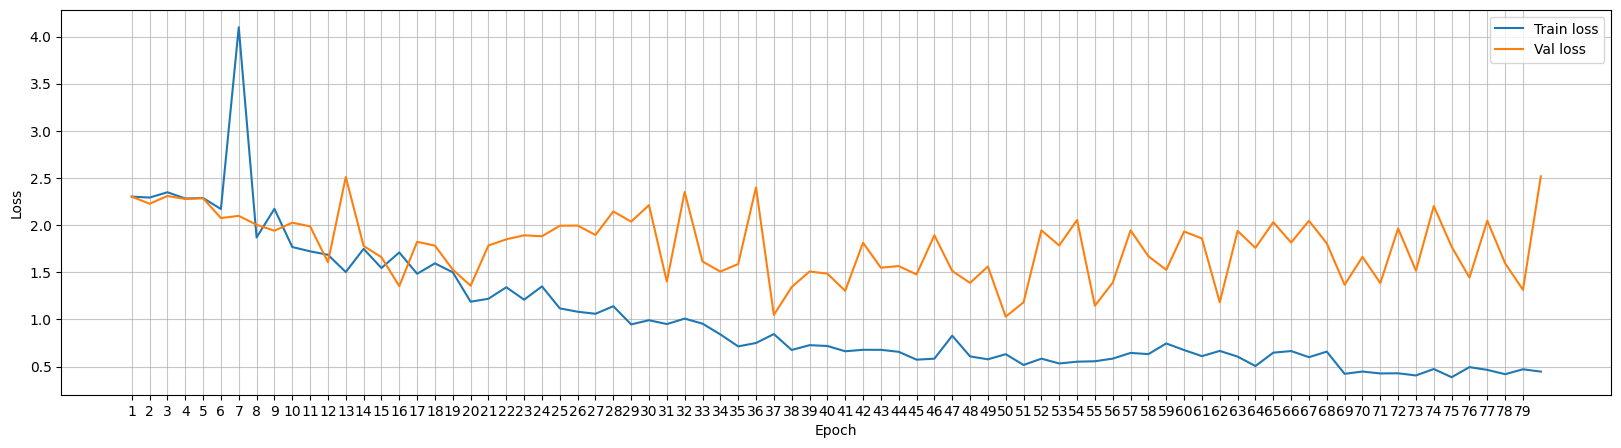

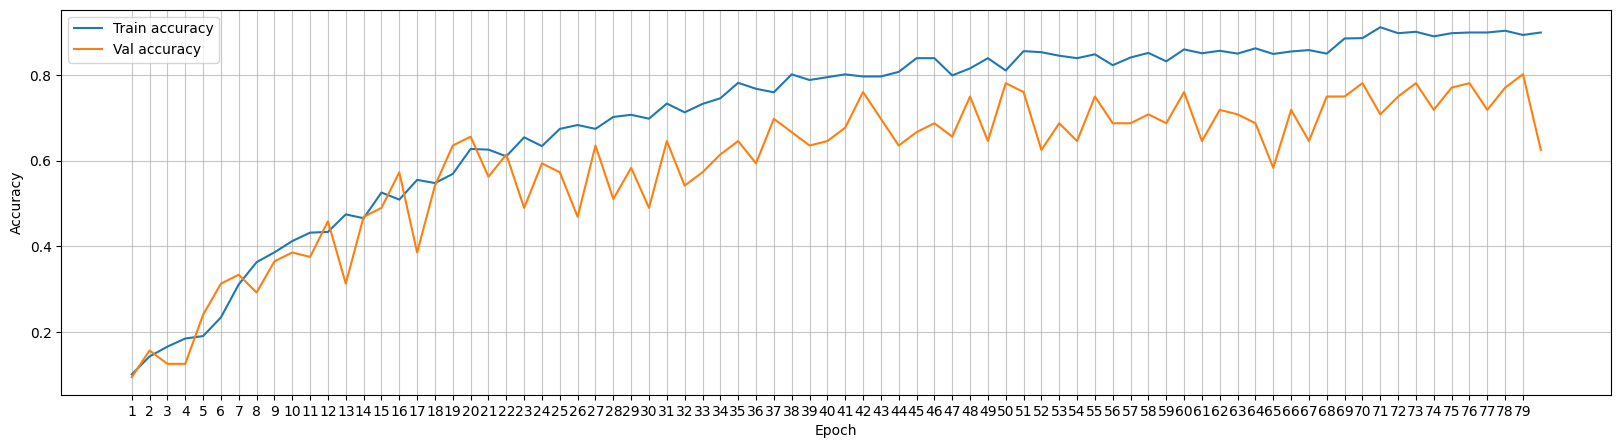

In [45]:
# Plot loss
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(20,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.6750 (67.50%)

MACRO AVERAGES:
  F1-Score   : 0.6551
  Precision  : 0.7308
  Recall     : 0.6750

WEIGHTED AVERAGES:
  F1-Score   : 0.6551
  Precision  : 0.7308
  Recall     : 0.6750

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8889   0.8000     1.0000  
clock_tick      0.6154   0.8000     0.5000  
crackling_fire  0.8000   0.8571     0.7500  
crying_baby     0.9333   1.0000     0.8750  
dog             0.7000   0.5833     0.8750  
helicopter      0.5714   0.6667     0.5000  
rain            0.5882   0.5556     0.6250  
rooster         0.2222   1.0000     0.1250  
sea_waves       0.6000   0.5000     0.7500  
sneezing        0.6316   0.5455     0.7500  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.8000    1.0000    0.8889 

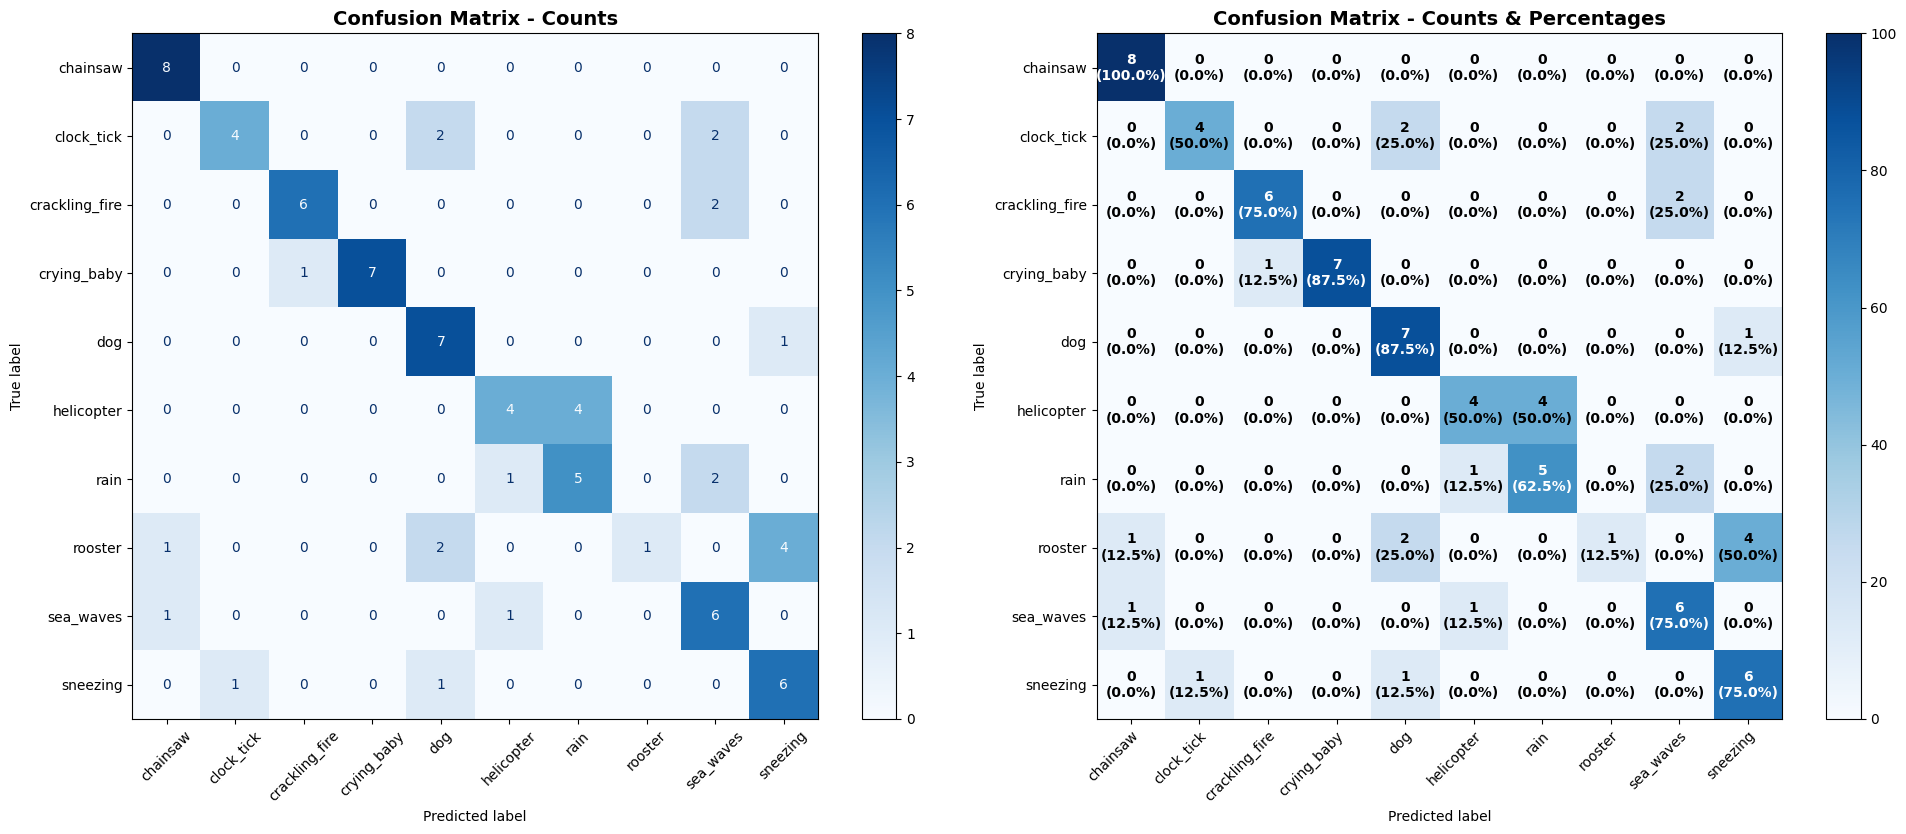


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        8        8        100.00    %
clock_tick      4        8        50.00     %
crackling_fire  6        8        75.00     %
crying_baby     7        8        87.50     %
dog             7        8        87.50     %
helicopter      4        8        50.00     %
rain            5        8        62.50     %
rooster         1        8        12.50     %
sea_waves       6        8        75.00     %
sneezing        6        8        75.00     %


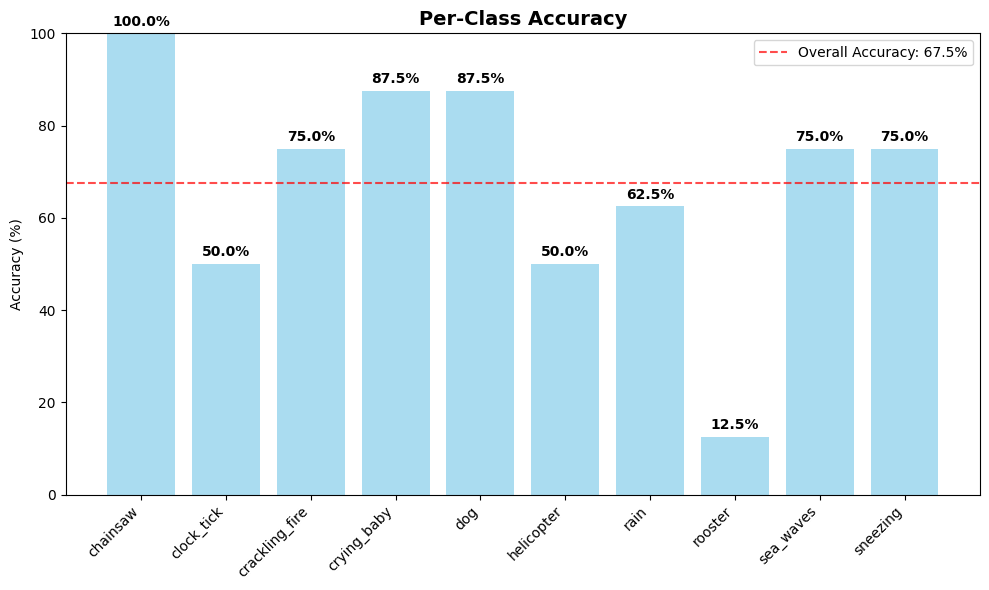

In [46]:
results_snn_sf = evaluate_model_comprehensive(sf_snn_classifier, sf_test_loader, ESCLabels.class_names, device)

##Step Forward: SCNN training

In [42]:
sf_c_snn_model = C_SNN(
    surr_grad=snn.surrogate.fast_sigmoid(),
    n_mels=N_MELS,
    num_classes=10,
    conv_channels1=16,
    conv_channels2=32,
    hidden_dim=64,
    dropout_rate=0.0,
    kernel_size=3,
    pool_kernel=2
).to(device)

summary(sf_c_snn_model, input_size=(BATCH_SIZE, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
C_SNN                                    [1, 32, 10]               --
├─Conv1d: 1-1                            [32, 16, 128]             64
├─Leaky: 1-2                             [32, 16, 128]             2
├─MaxPool1d: 1-3                         [32, 16, 64]              --
├─Conv1d: 1-4                            [32, 32, 64]              1,568
├─Leaky: 1-5                             [32, 32, 64]              2
├─MaxPool1d: 1-6                         [32, 32, 32]              --
├─Dropout: 1-7                           [32, 1024]                --
├─Linear: 1-8                            [32, 64]                  65,536
├─Leaky: 1-9                             [32, 64]                  2
├─Linear: 1-10                           [32, 10]                  640
├─Leaky: 1-11                            [32, 10]                  2
Total params: 67,816
Trainable params: 67,816
Non-trainable params: 0
Total mult-

In [43]:
optimizer = torch.optim.Adam(sf_c_snn_model.parameters(), lr=0.0001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=sf_c_snn_model,
    train_loader=sf_train_loader,
    valid_loader=sf_val_loader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
    device=device
)

Train batches:   0%|          | 0/38 [00:00<?, ?it/s]/content/drive/MyDrive/HumanData/utils/train_eval.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():

Train batches: 100%|██████████| 38/38 [02:09<00:00,  2.63s/it]
                                                              /content/drive/MyDrive/HumanData/utils/train_eval.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epochs:   1%|          | 1/100 [02:17<3:47:28, 137.87s/it]


Epoch 1/100 - 137s - loss: 2.3089 - acc: 0.1003 - val_loss: 2.3026 - val_acc: 0.0938



Epochs:   2%|▏         | 2/100 [04:35<3:45:12, 137.88s/it]


Epoch 2/100 - 137s - loss: 2.3054 - acc: 0.1225 - val_loss: 2.3021 - val_acc: 0.0938



Epochs:   3%|▎         | 3/100 [06:52<3:42:08, 137.40s/it]


Epoch 3/100 - 136s - loss: 2.3077 - acc: 0.1036 - val_loss: 2.2689 - val_acc: 0.1250



Epochs:   4%|▍         | 4/100 [09:10<3:39:58, 137.48s/it]


Epoch 4/100 - 137s - loss: 2.3017 - acc: 0.1382 - val_loss: 2.2285 - val_acc: 0.1458



Epochs:   5%|▌         | 5/100 [11:27<3:37:29, 137.37s/it]


Epoch 5/100 - 137s - loss: 2.2824 - acc: 0.1497 - val_loss: 2.2710 - val_acc: 0.1979



Epochs:   6%|▌         | 6/100 [13:45<3:35:31, 137.57s/it]


Epoch 6/100 - 137s - loss: 2.2765 - acc: 0.2048 - val_loss: 2.2432 - val_acc: 0.2083



Epochs:   7%|▋         | 7/100 [16:02<3:33:03, 137.45s/it]


Epoch 7/100 - 137s - loss: 2.2173 - acc: 0.2245 - val_loss: 2.3028 - val_acc: 0.1667



Epochs:   8%|▊         | 8/100 [18:20<3:30:50, 137.51s/it]


Epoch 8/100 - 137s - loss: 2.1594 - acc: 0.2788 - val_loss: 2.3804 - val_acc: 0.1771



Epochs:   9%|▉         | 9/100 [20:36<3:28:13, 137.30s/it]


Epoch 9/100 - 136s - loss: 2.1199 - acc: 0.3240 - val_loss: 2.0941 - val_acc: 0.2500



Epochs:  10%|█         | 10/100 [22:54<3:25:59, 137.33s/it]


Epoch 10/100 - 137s - loss: 1.9770 - acc: 0.3775 - val_loss: 2.2518 - val_acc: 0.4062



Epochs:  11%|█         | 11/100 [25:11<3:23:32, 137.22s/it]


Epoch 11/100 - 136s - loss: 1.7983 - acc: 0.4531 - val_loss: 1.4900 - val_acc: 0.5312



Epochs:  12%|█▏        | 12/100 [27:28<3:21:20, 137.28s/it]


Epoch 12/100 - 137s - loss: 1.5546 - acc: 0.4918 - val_loss: 1.3922 - val_acc: 0.4479



Epochs:  13%|█▎        | 13/100 [29:45<3:18:55, 137.20s/it]


Epoch 13/100 - 137s - loss: 1.4658 - acc: 0.5280 - val_loss: 1.5518 - val_acc: 0.4688



Epochs:  14%|█▍        | 14/100 [32:03<3:16:41, 137.22s/it]


Epoch 14/100 - 137s - loss: 1.3473 - acc: 0.5477 - val_loss: 1.2462 - val_acc: 0.5208



Epochs:  15%|█▌        | 15/100 [34:21<3:14:54, 137.58s/it]


Epoch 15/100 - 138s - loss: 1.2785 - acc: 0.5913 - val_loss: 1.1462 - val_acc: 0.6042



Epochs:  16%|█▌        | 16/100 [36:38<3:12:21, 137.40s/it]


Epoch 16/100 - 136s - loss: 1.1985 - acc: 0.6003 - val_loss: 1.3072 - val_acc: 0.5938



Epochs:  17%|█▋        | 17/100 [38:56<3:10:17, 137.56s/it]


Epoch 17/100 - 137s - loss: 1.1060 - acc: 0.6299 - val_loss: 1.3943 - val_acc: 0.4792



Epochs:  18%|█▊        | 18/100 [41:14<3:08:05, 137.63s/it]


Epoch 18/100 - 137s - loss: 1.1031 - acc: 0.6250 - val_loss: 1.1344 - val_acc: 0.5521



Epochs:  19%|█▉        | 19/100 [43:31<3:05:29, 137.40s/it]


Epoch 19/100 - 136s - loss: 1.0872 - acc: 0.6398 - val_loss: 1.4387 - val_acc: 0.6146



Epochs:  20%|██        | 20/100 [45:49<3:03:26, 137.58s/it]


Epoch 20/100 - 137s - loss: 0.9744 - acc: 0.6743 - val_loss: 1.4095 - val_acc: 0.5625



Epochs:  21%|██        | 21/100 [48:07<3:01:20, 137.72s/it]


Epoch 21/100 - 138s - loss: 1.0096 - acc: 0.6530 - val_loss: 1.1209 - val_acc: 0.6250



Epochs:  22%|██▏       | 22/100 [50:23<2:58:36, 137.39s/it]


Epoch 22/100 - 136s - loss: 1.0464 - acc: 0.6595 - val_loss: 1.1507 - val_acc: 0.6250



Epochs:  23%|██▎       | 23/100 [52:40<2:55:54, 137.08s/it]


Epoch 23/100 - 136s - loss: 0.8996 - acc: 0.6924 - val_loss: 1.1517 - val_acc: 0.6250



Epochs:  24%|██▍       | 24/100 [54:58<2:54:02, 137.40s/it]


Epoch 24/100 - 138s - loss: 0.9058 - acc: 0.6941 - val_loss: 1.1513 - val_acc: 0.6667



Epochs:  25%|██▌       | 25/100 [57:14<2:51:20, 137.08s/it]


Epoch 25/100 - 136s - loss: 0.9019 - acc: 0.6982 - val_loss: 0.9460 - val_acc: 0.6667



Epochs:  26%|██▌       | 26/100 [59:31<2:49:12, 137.19s/it]


Epoch 26/100 - 137s - loss: 0.8529 - acc: 0.7130 - val_loss: 0.9162 - val_acc: 0.6667



Epochs:  27%|██▋       | 27/100 [1:01:47<2:46:24, 136.78s/it]


Epoch 27/100 - 135s - loss: 0.7662 - acc: 0.7352 - val_loss: 1.0200 - val_acc: 0.6562



Epochs:  28%|██▊       | 28/100 [1:04:03<2:43:53, 136.58s/it]


Epoch 28/100 - 136s - loss: 0.8079 - acc: 0.7196 - val_loss: 1.0216 - val_acc: 0.7083



Epochs:  29%|██▉       | 29/100 [1:06:20<2:41:42, 136.65s/it]


Epoch 29/100 - 136s - loss: 0.7913 - acc: 0.7253 - val_loss: 0.8358 - val_acc: 0.6771



Epochs:  30%|███       | 30/100 [1:08:35<2:38:51, 136.17s/it]


Epoch 30/100 - 135s - loss: 0.8252 - acc: 0.7294 - val_loss: 0.9385 - val_acc: 0.6667



Epochs:  31%|███       | 31/100 [1:10:52<2:36:37, 136.20s/it]


Epoch 31/100 - 136s - loss: 0.7391 - acc: 0.7484 - val_loss: 0.8710 - val_acc: 0.6667



Epochs:  32%|███▏      | 32/100 [1:13:07<2:34:00, 135.89s/it]


Epoch 32/100 - 135s - loss: 0.7070 - acc: 0.7484 - val_loss: 0.9083 - val_acc: 0.7500



Epochs:  33%|███▎      | 33/100 [1:15:21<2:31:20, 135.53s/it]


Epoch 33/100 - 134s - loss: 0.7253 - acc: 0.7516 - val_loss: 1.0070 - val_acc: 0.7292



Epochs:  34%|███▍      | 34/100 [1:17:37<2:29:11, 135.63s/it]


Epoch 34/100 - 135s - loss: 0.6915 - acc: 0.7558 - val_loss: 0.8090 - val_acc: 0.7083



Epochs:  35%|███▌      | 35/100 [1:19:53<2:26:58, 135.67s/it]


Epoch 35/100 - 135s - loss: 0.6704 - acc: 0.7640 - val_loss: 0.8704 - val_acc: 0.7500



Epochs:  36%|███▌      | 36/100 [1:22:11<2:25:22, 136.29s/it]


Epoch 36/100 - 137s - loss: 0.7050 - acc: 0.7484 - val_loss: 1.0710 - val_acc: 0.6667



Epochs:  37%|███▋      | 37/100 [1:24:27<2:22:59, 136.19s/it]


Epoch 37/100 - 135s - loss: 0.7032 - acc: 0.7492 - val_loss: 0.9521 - val_acc: 0.7083



Epochs:  38%|███▊      | 38/100 [1:26:42<2:20:32, 136.00s/it]


Epoch 38/100 - 135s - loss: 0.6954 - acc: 0.7615 - val_loss: 0.8554 - val_acc: 0.6875



Epochs:  39%|███▉      | 39/100 [1:28:59<2:18:25, 136.15s/it]


Epoch 39/100 - 136s - loss: 0.6746 - acc: 0.7706 - val_loss: 0.8509 - val_acc: 0.6771



Epochs:  40%|████      | 40/100 [1:31:15<2:16:11, 136.20s/it]


Epoch 40/100 - 136s - loss: 0.6809 - acc: 0.7599 - val_loss: 0.9485 - val_acc: 0.7292



Epochs:  41%|████      | 41/100 [1:33:31<2:13:50, 136.12s/it]


Epoch 41/100 - 135s - loss: 0.6625 - acc: 0.7722 - val_loss: 0.8651 - val_acc: 0.6979



Epochs:  42%|████▏     | 42/100 [1:35:49<2:12:10, 136.74s/it]


Epoch 42/100 - 138s - loss: 0.6537 - acc: 0.7763 - val_loss: 0.8393 - val_acc: 0.7083



Epochs:  43%|████▎     | 43/100 [1:38:05<2:09:32, 136.36s/it]


Epoch 43/100 - 135s - loss: 0.5574 - acc: 0.8035 - val_loss: 0.9230 - val_acc: 0.7812



Epochs:  44%|████▍     | 44/100 [1:40:21<2:07:17, 136.39s/it]


Epoch 44/100 - 136s - loss: 0.5986 - acc: 0.8010 - val_loss: 1.0400 - val_acc: 0.6458



Epochs:  45%|████▌     | 45/100 [1:42:37<2:04:52, 136.23s/it]


Epoch 45/100 - 135s - loss: 0.6307 - acc: 0.7738 - val_loss: 0.9451 - val_acc: 0.7500



Epochs:  46%|████▌     | 46/100 [1:44:52<2:02:22, 135.98s/it]


Epoch 46/100 - 135s - loss: 0.5698 - acc: 0.8174 - val_loss: 0.8662 - val_acc: 0.7708



Epochs:  47%|████▋     | 47/100 [1:47:09<2:00:14, 136.12s/it]


Epoch 47/100 - 136s - loss: 0.5879 - acc: 0.7985 - val_loss: 0.9648 - val_acc: 0.7292



Epochs:  48%|████▊     | 48/100 [1:49:25<1:58:06, 136.27s/it]


Epoch 48/100 - 136s - loss: 0.5395 - acc: 0.8199 - val_loss: 0.7351 - val_acc: 0.7812



Epochs:  49%|████▉     | 49/100 [1:51:41<1:55:43, 136.14s/it]


Epoch 49/100 - 135s - loss: 0.5437 - acc: 0.8158 - val_loss: 0.8483 - val_acc: 0.7083



Epochs:  50%|█████     | 50/100 [1:53:57<1:53:26, 136.13s/it]


Epoch 50/100 - 136s - loss: 0.6336 - acc: 0.7821 - val_loss: 0.7506 - val_acc: 0.7917



Epochs:  51%|█████     | 51/100 [1:56:14<1:51:15, 136.23s/it]


Epoch 51/100 - 136s - loss: 0.5522 - acc: 0.8018 - val_loss: 0.6813 - val_acc: 0.7500



Epochs:  52%|█████▏    | 52/100 [1:58:30<1:48:57, 136.20s/it]


Epoch 52/100 - 136s - loss: 0.5004 - acc: 0.8257 - val_loss: 0.8348 - val_acc: 0.8021



Epochs:  53%|█████▎    | 53/100 [2:00:47<1:46:47, 136.32s/it]


Epoch 53/100 - 136s - loss: 0.5351 - acc: 0.8273 - val_loss: 1.1625 - val_acc: 0.7188



Epochs:  54%|█████▍    | 54/100 [2:03:02<1:44:18, 136.06s/it]


Epoch 54/100 - 135s - loss: 0.5807 - acc: 0.7985 - val_loss: 0.7868 - val_acc: 0.7917



Epochs:  55%|█████▌    | 55/100 [2:05:17<1:41:49, 135.77s/it]


Epoch 55/100 - 135s - loss: 0.4790 - acc: 0.8438 - val_loss: 0.7527 - val_acc: 0.7708



Epochs:  56%|█████▌    | 56/100 [2:07:32<1:39:27, 135.63s/it]


Epoch 56/100 - 135s - loss: 0.4835 - acc: 0.8438 - val_loss: 0.7720 - val_acc: 0.8125



Epochs:  57%|█████▋    | 57/100 [2:09:50<1:37:36, 136.20s/it]


Epoch 57/100 - 137s - loss: 0.4243 - acc: 0.8462 - val_loss: 0.6474 - val_acc: 0.7500



Epochs:  58%|█████▊    | 58/100 [2:12:06<1:35:23, 136.27s/it]


Epoch 58/100 - 136s - loss: 0.4394 - acc: 0.8520 - val_loss: 0.9535 - val_acc: 0.7500



Epochs:  59%|█████▉    | 59/100 [2:14:22<1:33:02, 136.16s/it]


Epoch 59/100 - 135s - loss: 0.5118 - acc: 0.8298 - val_loss: 0.5243 - val_acc: 0.8438



Epochs:  60%|██████    | 60/100 [2:16:38<1:30:42, 136.05s/it]


Epoch 60/100 - 135s - loss: 0.4210 - acc: 0.8569 - val_loss: 0.9217 - val_acc: 0.7396



Epochs:  61%|██████    | 61/100 [2:18:56<1:28:44, 136.53s/it]


Epoch 61/100 - 137s - loss: 0.4349 - acc: 0.8692 - val_loss: 0.7786 - val_acc: 0.7812



Epochs:  62%|██████▏   | 62/100 [2:21:11<1:26:17, 136.24s/it]


Epoch 62/100 - 135s - loss: 0.4507 - acc: 0.8503 - val_loss: 0.6972 - val_acc: 0.7812



Epochs:  63%|██████▎   | 63/100 [2:23:28<1:24:05, 136.36s/it]


Epoch 63/100 - 136s - loss: 0.4302 - acc: 0.8503 - val_loss: 0.7992 - val_acc: 0.7812



Epochs:  64%|██████▍   | 64/100 [2:25:45<1:21:53, 136.49s/it]


Epoch 64/100 - 136s - loss: 0.4384 - acc: 0.8405 - val_loss: 0.9112 - val_acc: 0.7708



Epochs:  65%|██████▌   | 65/100 [2:28:01<1:19:33, 136.39s/it]


Epoch 65/100 - 136s - loss: 0.5150 - acc: 0.8248 - val_loss: 0.5536 - val_acc: 0.7917



Epochs:  66%|██████▌   | 66/100 [2:30:17<1:17:14, 136.32s/it]


Epoch 66/100 - 136s - loss: 0.4679 - acc: 0.8339 - val_loss: 0.6774 - val_acc: 0.7708



Epochs:  67%|██████▋   | 67/100 [2:32:34<1:15:06, 136.58s/it]


Epoch 67/100 - 137s - loss: 0.4408 - acc: 0.8429 - val_loss: 0.4915 - val_acc: 0.8125



Epochs:  68%|██████▊   | 68/100 [2:34:51<1:12:50, 136.57s/it]


Epoch 68/100 - 136s - loss: 0.4117 - acc: 0.8635 - val_loss: 0.8090 - val_acc: 0.7188



Epochs:  69%|██████▉   | 69/100 [2:37:06<1:10:24, 136.29s/it]


Epoch 69/100 - 135s - loss: 0.4179 - acc: 0.8627 - val_loss: 0.6577 - val_acc: 0.7917



Epochs:  70%|███████   | 70/100 [2:39:23<1:08:11, 136.39s/it]


Epoch 70/100 - 136s - loss: 0.4467 - acc: 0.8512 - val_loss: 0.7004 - val_acc: 0.7917



Epochs:  71%|███████   | 71/100 [2:41:42<1:06:17, 137.15s/it]


Epoch 71/100 - 138s - loss: 0.3838 - acc: 0.8684 - val_loss: 0.6670 - val_acc: 0.7708



Epochs:  72%|███████▏  | 72/100 [2:43:57<1:03:42, 136.50s/it]


Epoch 72/100 - 134s - loss: 0.3319 - acc: 0.8791 - val_loss: 0.5205 - val_acc: 0.8125



Epochs:  73%|███████▎  | 73/100 [2:46:14<1:01:32, 136.77s/it]


Epoch 73/100 - 137s - loss: 0.3670 - acc: 0.8692 - val_loss: 0.8021 - val_acc: 0.7812



Epochs:  74%|███████▍  | 74/100 [2:48:30<59:04, 136.33s/it]  


Epoch 74/100 - 135s - loss: 0.3518 - acc: 0.8717 - val_loss: 0.5448 - val_acc: 0.8021



Epochs:  75%|███████▌  | 75/100 [2:50:46<56:50, 136.41s/it]


Epoch 75/100 - 136s - loss: 0.3996 - acc: 0.8692 - val_loss: 0.6223 - val_acc: 0.8125



Epochs:  76%|███████▌  | 76/100 [2:53:04<54:41, 136.73s/it]


Epoch 76/100 - 137s - loss: 0.3158 - acc: 0.8824 - val_loss: 0.6994 - val_acc: 0.8125



Epochs:  77%|███████▋  | 77/100 [2:55:20<52:19, 136.51s/it]


Epoch 77/100 - 135s - loss: 0.3404 - acc: 0.8816 - val_loss: 0.8202 - val_acc: 0.7604



Epochs:  78%|███████▊  | 78/100 [2:57:36<50:00, 136.38s/it]


Epoch 78/100 - 136s - loss: 0.3870 - acc: 0.8610 - val_loss: 0.6777 - val_acc: 0.6979



Epochs:  79%|███████▉  | 79/100 [2:59:52<47:41, 136.25s/it]


Epoch 79/100 - 135s - loss: 0.3353 - acc: 0.8758 - val_loss: 0.6709 - val_acc: 0.8021



Epochs:  80%|████████  | 80/100 [3:02:08<45:27, 136.39s/it]


Epoch 80/100 - 136s - loss: 0.3482 - acc: 0.8824 - val_loss: 0.7077 - val_acc: 0.7604



Epochs:  81%|████████  | 81/100 [3:04:26<43:15, 136.61s/it]


Epoch 81/100 - 137s - loss: 0.3509 - acc: 0.8758 - val_loss: 0.9703 - val_acc: 0.7604



Epochs:  82%|████████▏ | 82/100 [3:06:41<40:53, 136.32s/it]


Epoch 82/100 - 135s - loss: 0.3606 - acc: 0.8832 - val_loss: 0.6113 - val_acc: 0.7917



Epochs:  83%|████████▎ | 83/100 [3:08:57<38:35, 136.19s/it]


Epoch 83/100 - 135s - loss: 0.3293 - acc: 0.8865 - val_loss: 0.8852 - val_acc: 0.7604



Epochs:  84%|████████▍ | 84/100 [3:11:14<36:24, 136.52s/it]


Epoch 84/100 - 137s - loss: 0.3291 - acc: 0.8956 - val_loss: 0.8919 - val_acc: 0.7604



Epochs:  85%|████████▌ | 85/100 [3:13:30<34:01, 136.12s/it]


Epoch 85/100 - 135s - loss: 0.3054 - acc: 0.8931 - val_loss: 0.7374 - val_acc: 0.7917



Epochs:  86%|████████▌ | 86/100 [3:15:45<31:44, 136.03s/it]


Epoch 86/100 - 135s - loss: 0.3083 - acc: 0.8980 - val_loss: 0.6149 - val_acc: 0.8125



Epochs:  87%|████████▋ | 87/100 [3:18:01<29:25, 135.82s/it]


Epoch 87/100 - 135s - loss: 0.2874 - acc: 0.8972 - val_loss: 0.6799 - val_acc: 0.8021



Epochs:  88%|████████▊ | 88/100 [3:20:18<27:13, 136.16s/it]


Epoch 88/100 - 136s - loss: 0.3414 - acc: 0.8906 - val_loss: 0.7307 - val_acc: 0.8229



Epochs:  89%|████████▉ | 89/100 [3:22:33<24:56, 136.01s/it]


Epoch 89/100 - 135s - loss: 0.2989 - acc: 0.8931 - val_loss: 0.7244 - val_acc: 0.8021



Epochs:  90%|█████████ | 90/100 [3:24:50<22:40, 136.08s/it]


Epoch 90/100 - 136s - loss: 0.3395 - acc: 0.8857 - val_loss: 0.7288 - val_acc: 0.7917



Epochs:  91%|█████████ | 91/100 [3:27:07<20:26, 136.32s/it]


Epoch 91/100 - 136s - loss: 0.3402 - acc: 0.8865 - val_loss: 0.5800 - val_acc: 0.8021



Epochs:  92%|█████████▏| 92/100 [3:29:22<18:09, 136.16s/it]


Epoch 92/100 - 135s - loss: 0.2901 - acc: 0.8972 - val_loss: 0.5712 - val_acc: 0.8438



Epochs:  93%|█████████▎| 93/100 [3:31:39<15:54, 136.33s/it]


Epoch 93/100 - 136s - loss: 0.2760 - acc: 0.9079 - val_loss: 0.5806 - val_acc: 0.8021



Epochs:  94%|█████████▍| 94/100 [3:33:55<13:37, 136.23s/it]


Epoch 94/100 - 135s - loss: 0.3390 - acc: 0.8873 - val_loss: 0.7197 - val_acc: 0.7708



Epochs:  95%|█████████▌| 95/100 [3:36:12<11:22, 136.58s/it]


Epoch 95/100 - 137s - loss: 0.3228 - acc: 0.8914 - val_loss: 0.5512 - val_acc: 0.8125



Epochs:  96%|█████████▌| 96/100 [3:38:31<09:08, 137.16s/it]


Epoch 96/100 - 138s - loss: 0.2694 - acc: 0.9079 - val_loss: 0.7338 - val_acc: 0.8125



Epochs:  96%|█████████▌| 96/100 [3:40:47<09:11, 137.99s/it]

Early stopping triggered


In [44]:
torch.save(sf_c_snn_model.state_dict(), '/content/drive/MyDrive/HumanData/best_models/step_forward/sf_scnn.pth')

##Step Forward: SCNN evaluation

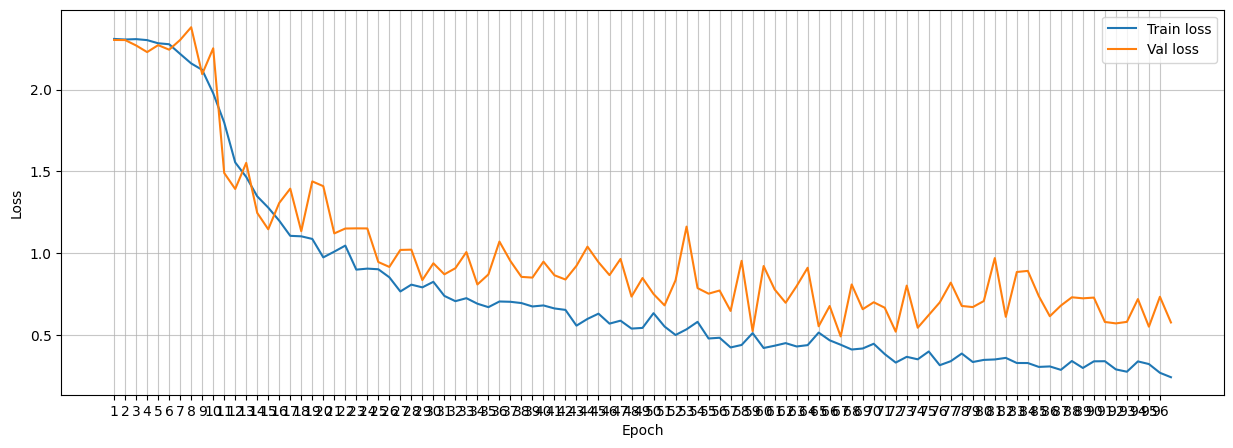

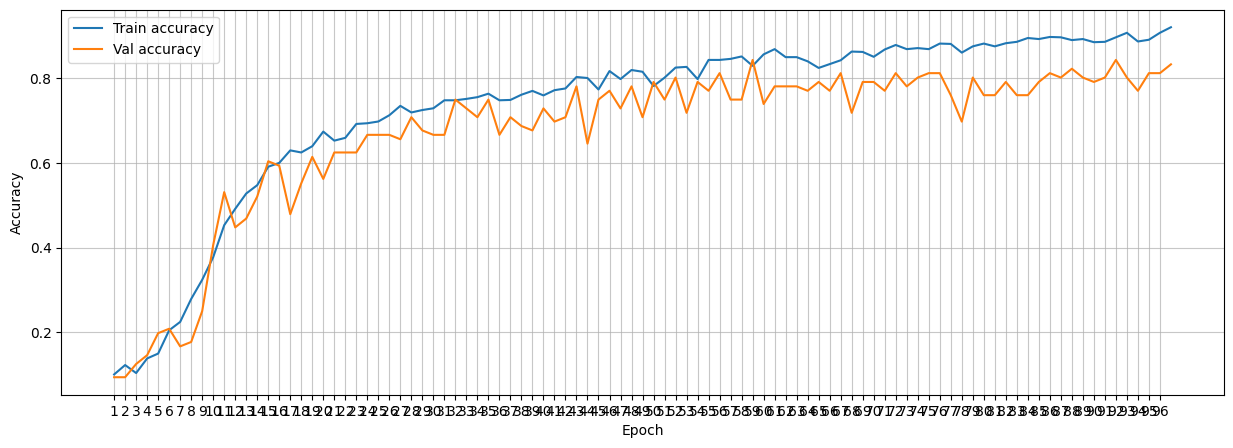

In [45]:
# Plot loss
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(15,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

COMPREHENSIVE EVALUATION RESULTS
Accuracy: 0.8125 (81.25%)

MACRO AVERAGES:
  F1-Score   : 0.8192
  Precision  : 0.8413
  Recall     : 0.8125

WEIGHTED AVERAGES:
  F1-Score   : 0.8192
  Precision  : 0.8413
  Recall     : 0.8125

PER-CLASS METRICS:
------------------------------------------------------------
Class           F1       Precision  Recall  
------------------------------------------------------------
chainsaw        0.8750   0.8750     0.8750  
clock_tick      0.5882   0.5556     0.6250  
crackling_fire  0.8571   1.0000     0.7500  
crying_baby     1.0000   1.0000     1.0000  
dog             0.8000   0.8571     0.7500  
helicopter      0.8750   0.8750     0.8750  
rain            0.7000   0.5833     0.8750  
rooster         0.8571   1.0000     0.7500  
sea_waves       0.7059   0.6667     0.7500  
sneezing        0.9333   1.0000     0.8750  

DETAILED CLASSIFICATION REPORT
                precision    recall  f1-score   support

      chainsaw     0.8750    0.8750    0.8750 

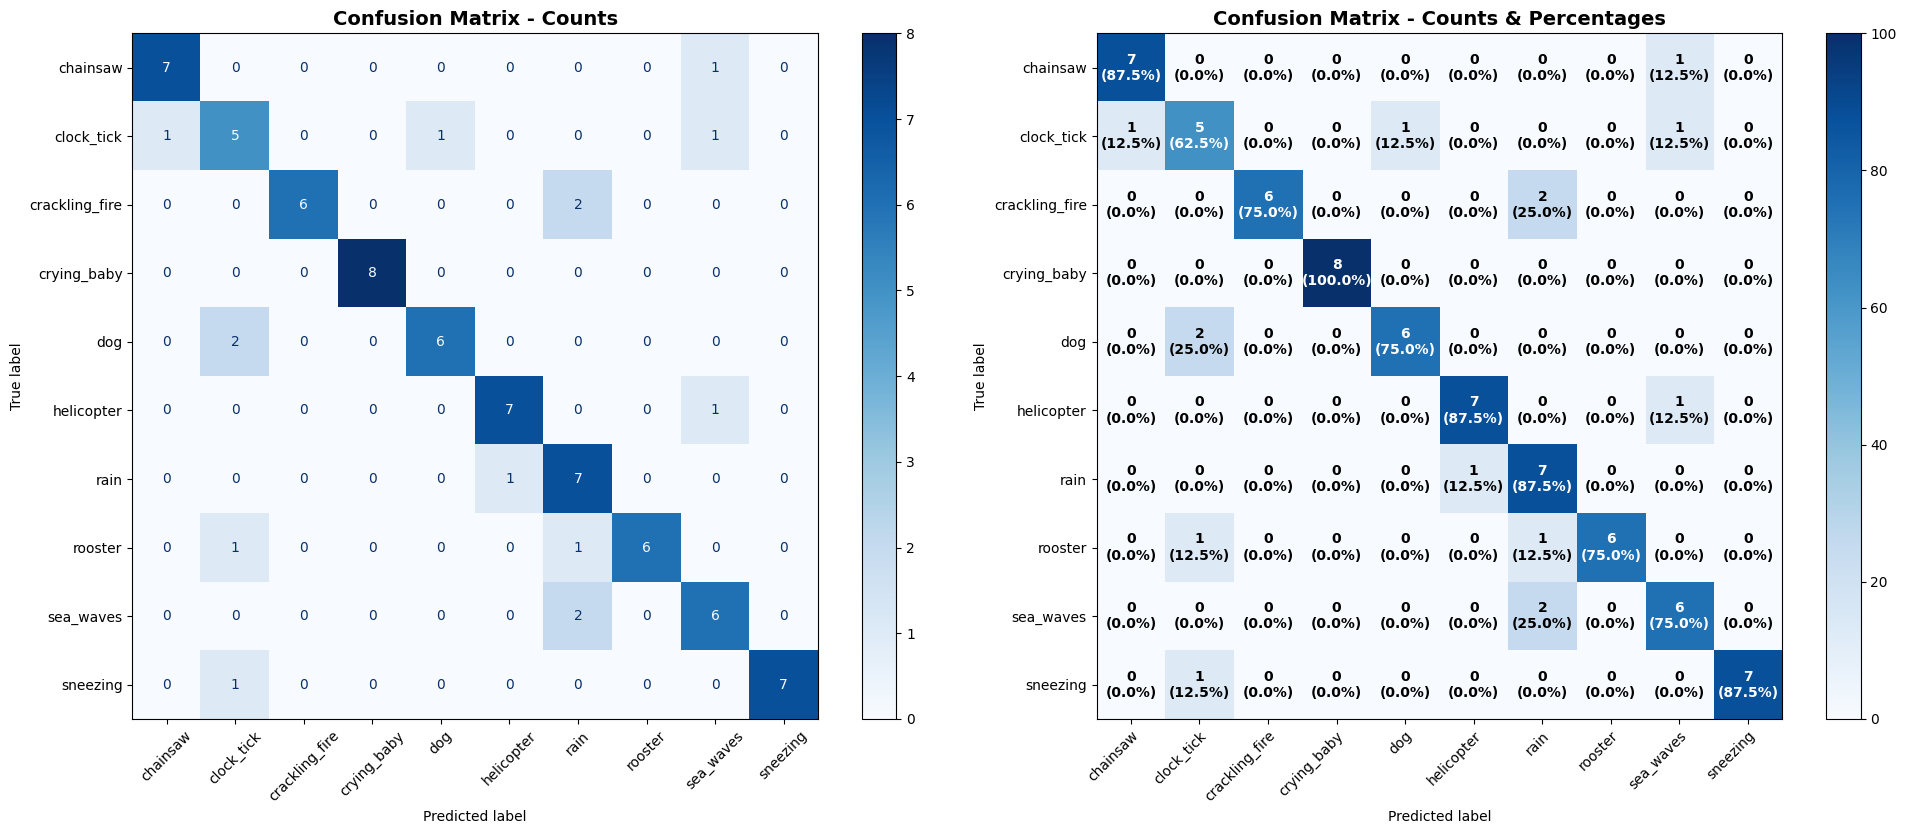


PER-CLASS ACCURACY BREAKDOWN
True Class      Correct  Total    Accuracy  
------------------------------------------------------------
chainsaw        7        8        87.50     %
clock_tick      5        8        62.50     %
crackling_fire  6        8        75.00     %
crying_baby     8        8        100.00    %
dog             6        8        75.00     %
helicopter      7        8        87.50     %
rain            7        8        87.50     %
rooster         6        8        75.00     %
sea_waves       6        8        75.00     %
sneezing        7        8        87.50     %


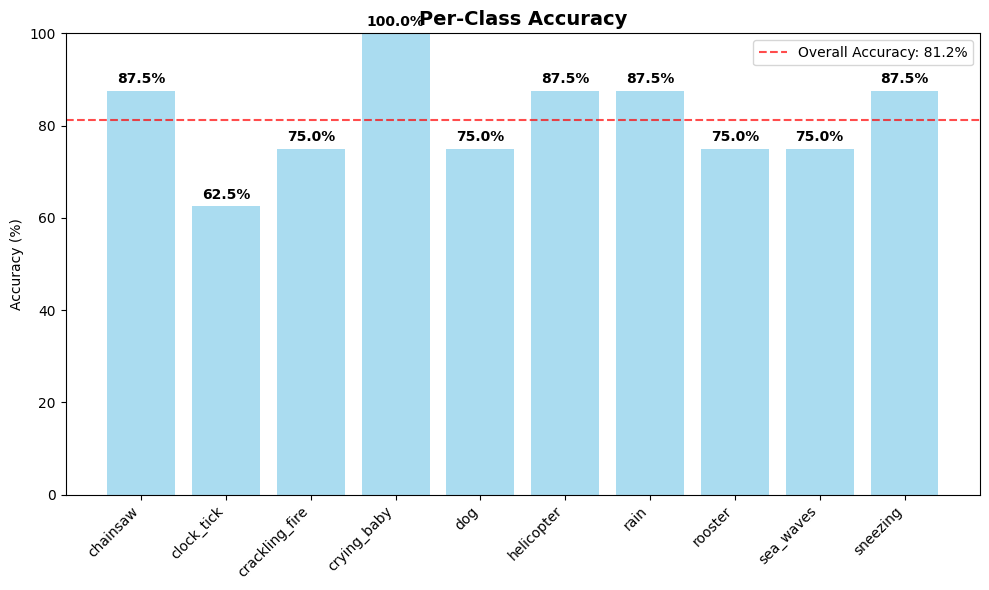

In [46]:
results_scnn_sf = evaluate_model_comprehensive(sf_c_snn_model, sf_test_loader, ESCLabels.class_names, device)

# Performance Analysis

### Delta Modulation SNN

MODEL COMPLEXITY ANALYSIS
INFERENCE PERFORMANCE PROFILING
TRAINING PERFORMANCE PROFILING


/content/drive/MyDrive/HumanData/utils/performance_analysis.py:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


STEP FORWARD ENCODING BENCHMARK


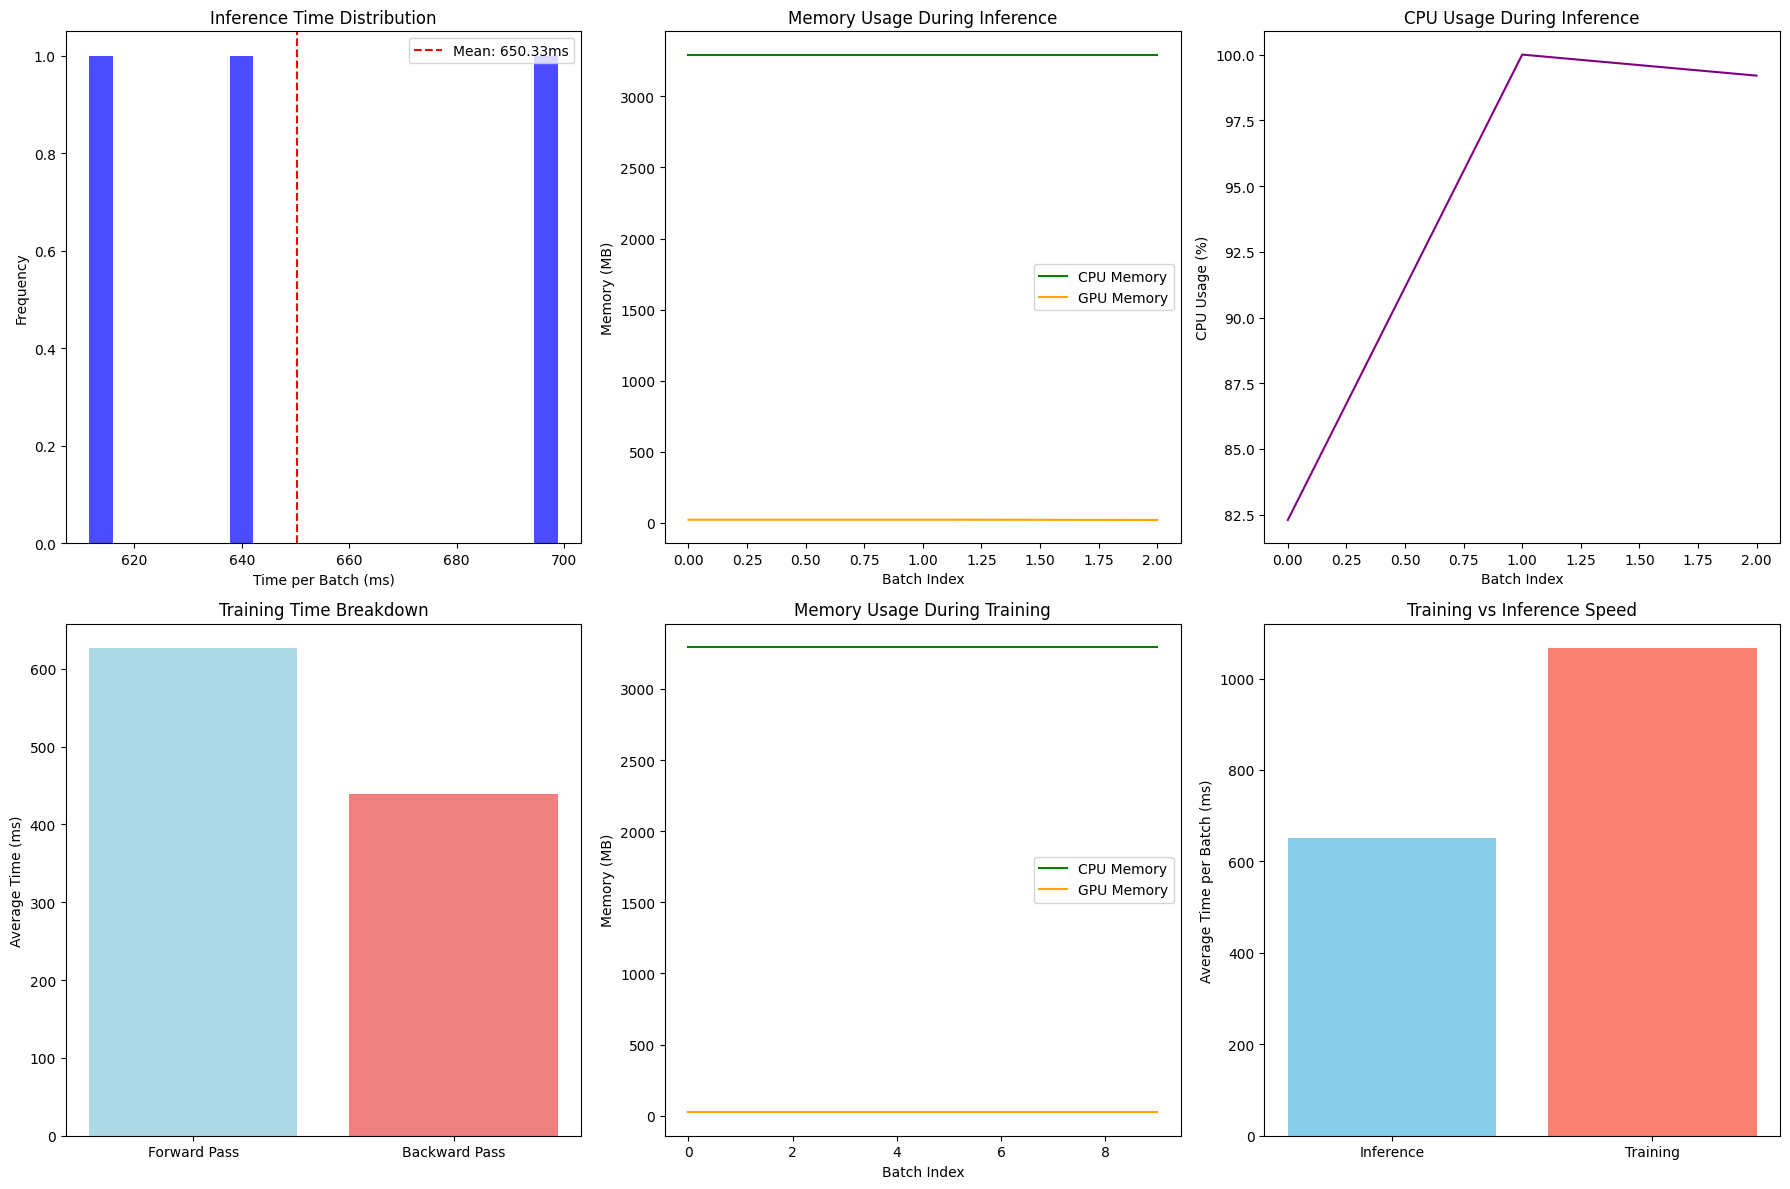


COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN

 INFERENCE PERFORMANCE:
  Average batch time: 650.33 ± 36.26 ms
  Throughput: 41.0 samples/second
  Min/Max batch time: 611.60 / 698.81 ms
  CPU usage: 93.8%
  Peak CPU memory: 3294.0 MB
  Peak GPU memory: 22.3 MB

 TRAINING PERFORMANCE:
  Average batch time: 1066.25 ms
  Forward pass: 626.38 ms
  Backward pass: 439.51 ms
  Peak CPU memory: 3294.0 MB
  Peak GPU memory: 22.7 MB

 MODEL COMPLEXITY:
  Total parameters: 51,224
  Trainable parameters: 51,224
  Model size: 0.22 MB

  Estimated memory usage by batch size:
    batch_1: 1.1 MB
    batch_16: 14.3 MB
    batch_32: 28.3 MB
    batch_64: 56.5 MB


In [47]:
analysis_delta_snn = run_performance_evaluation(
    model=delta_snn_classifier,
    train_loader=delta_train_loader,
    val_loader=delta_val_loader,
    test_loader=delta_test_loader,
    device=device
)

###Delta Modulation SCNN

MODEL COMPLEXITY ANALYSIS
INFERENCE PERFORMANCE PROFILING
TRAINING PERFORMANCE PROFILING


/content/drive/MyDrive/HumanData/utils/performance_analysis.py:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


STEP FORWARD ENCODING BENCHMARK


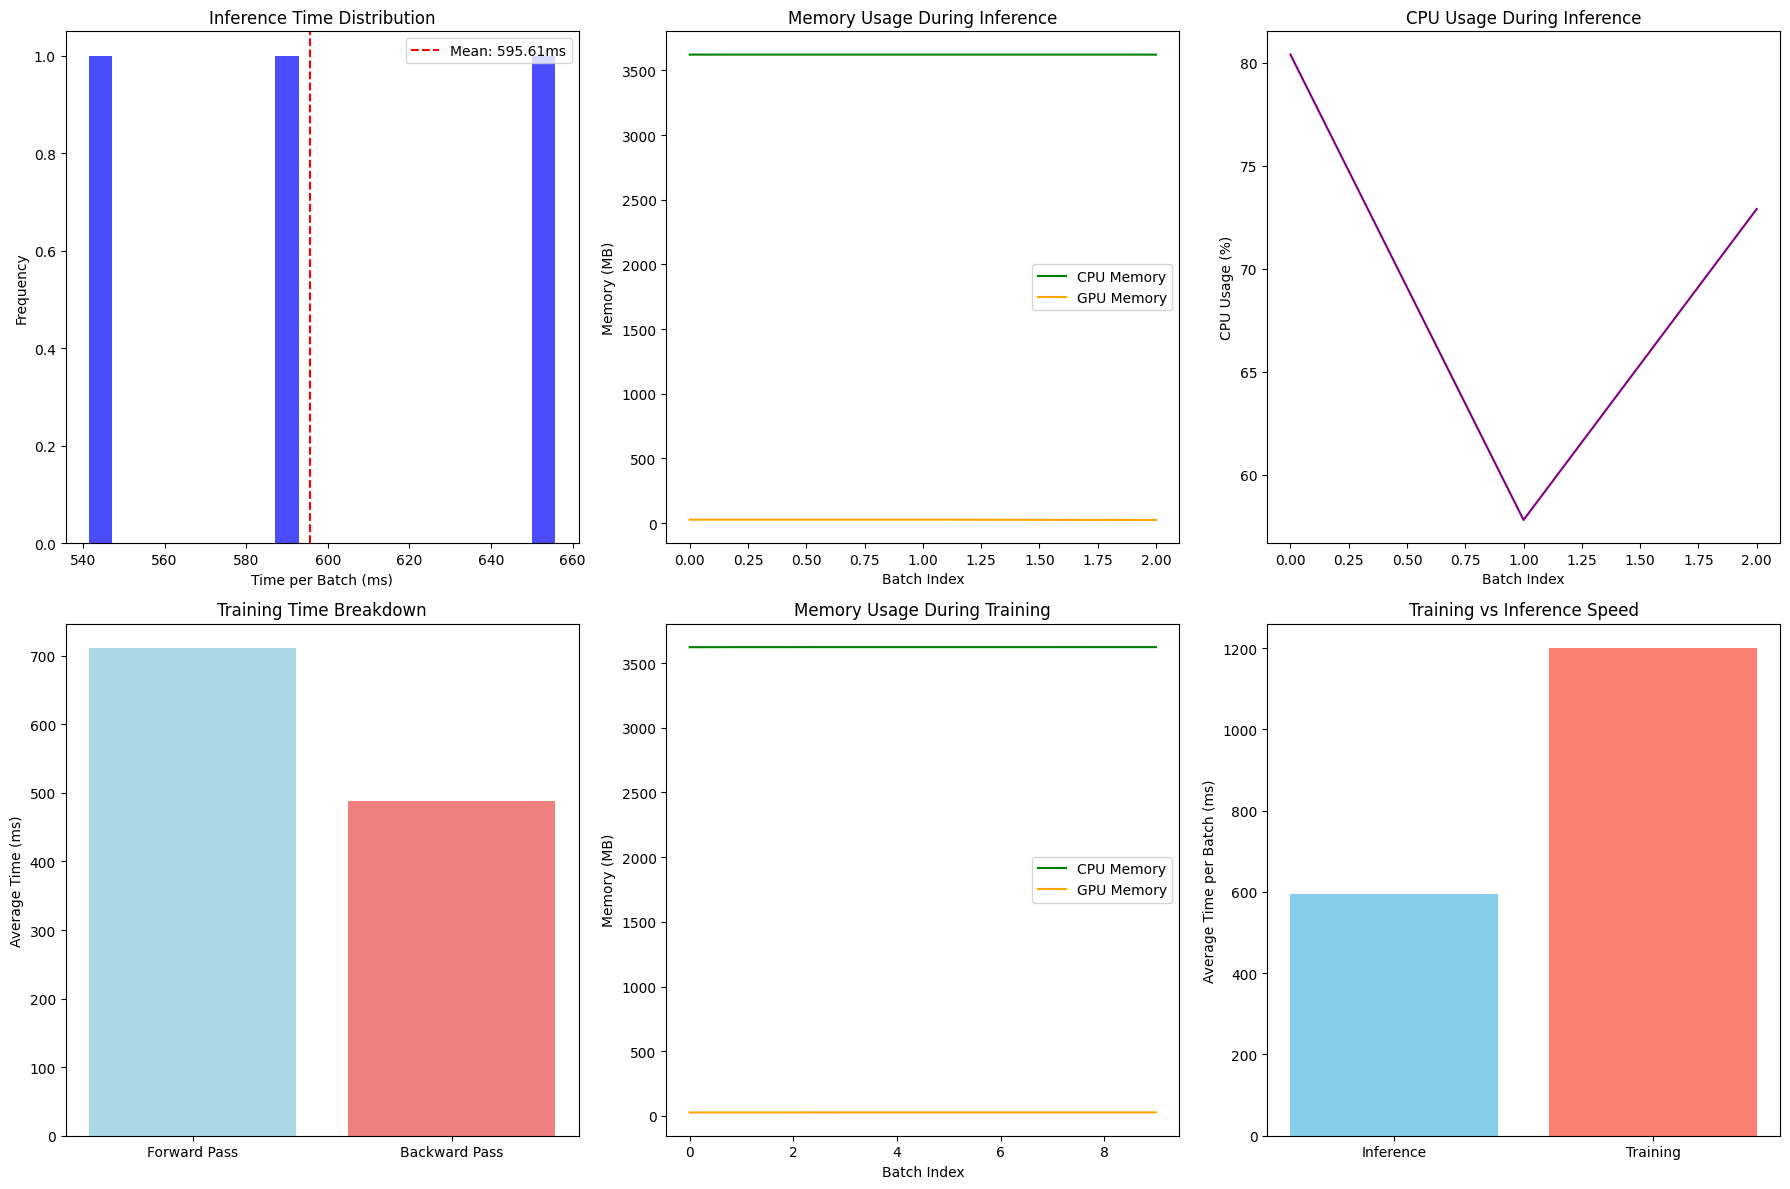


COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN

 INFERENCE PERFORMANCE:
  Average batch time: 595.61 ± 46.85 ms
  Throughput: 44.8 samples/second
  Min/Max batch time: 541.47 / 655.75 ms
  CPU usage: 70.4%
  Peak CPU memory: 3622.2 MB
  Peak GPU memory: 26.8 MB

 TRAINING PERFORMANCE:
  Average batch time: 1200.04 ms
  Forward pass: 710.94 ms
  Backward pass: 488.80 ms
  Peak CPU memory: 3623.7 MB
  Peak GPU memory: 27.4 MB

 MODEL COMPLEXITY:
  Total parameters: 67,816
  Trainable parameters: 67,816
  Model size: 0.51 MB

  Estimated memory usage by batch size:
    batch_1: 1.4 MB
    batch_16: 14.6 MB
    batch_32: 28.6 MB
    batch_64: 56.8 MB


In [47]:
analysis_delta_scnn = run_performance_evaluation(
    model=delta_c_snn_model,
    train_loader=delta_train_loader,
    val_loader=delta_val_loader,
    test_loader=delta_test_loader,
    device=device
)

###TAE SNN

MODEL COMPLEXITY ANALYSIS
INFERENCE PERFORMANCE PROFILING
TRAINING PERFORMANCE PROFILING
STEP FORWARD ENCODING BENCHMARK


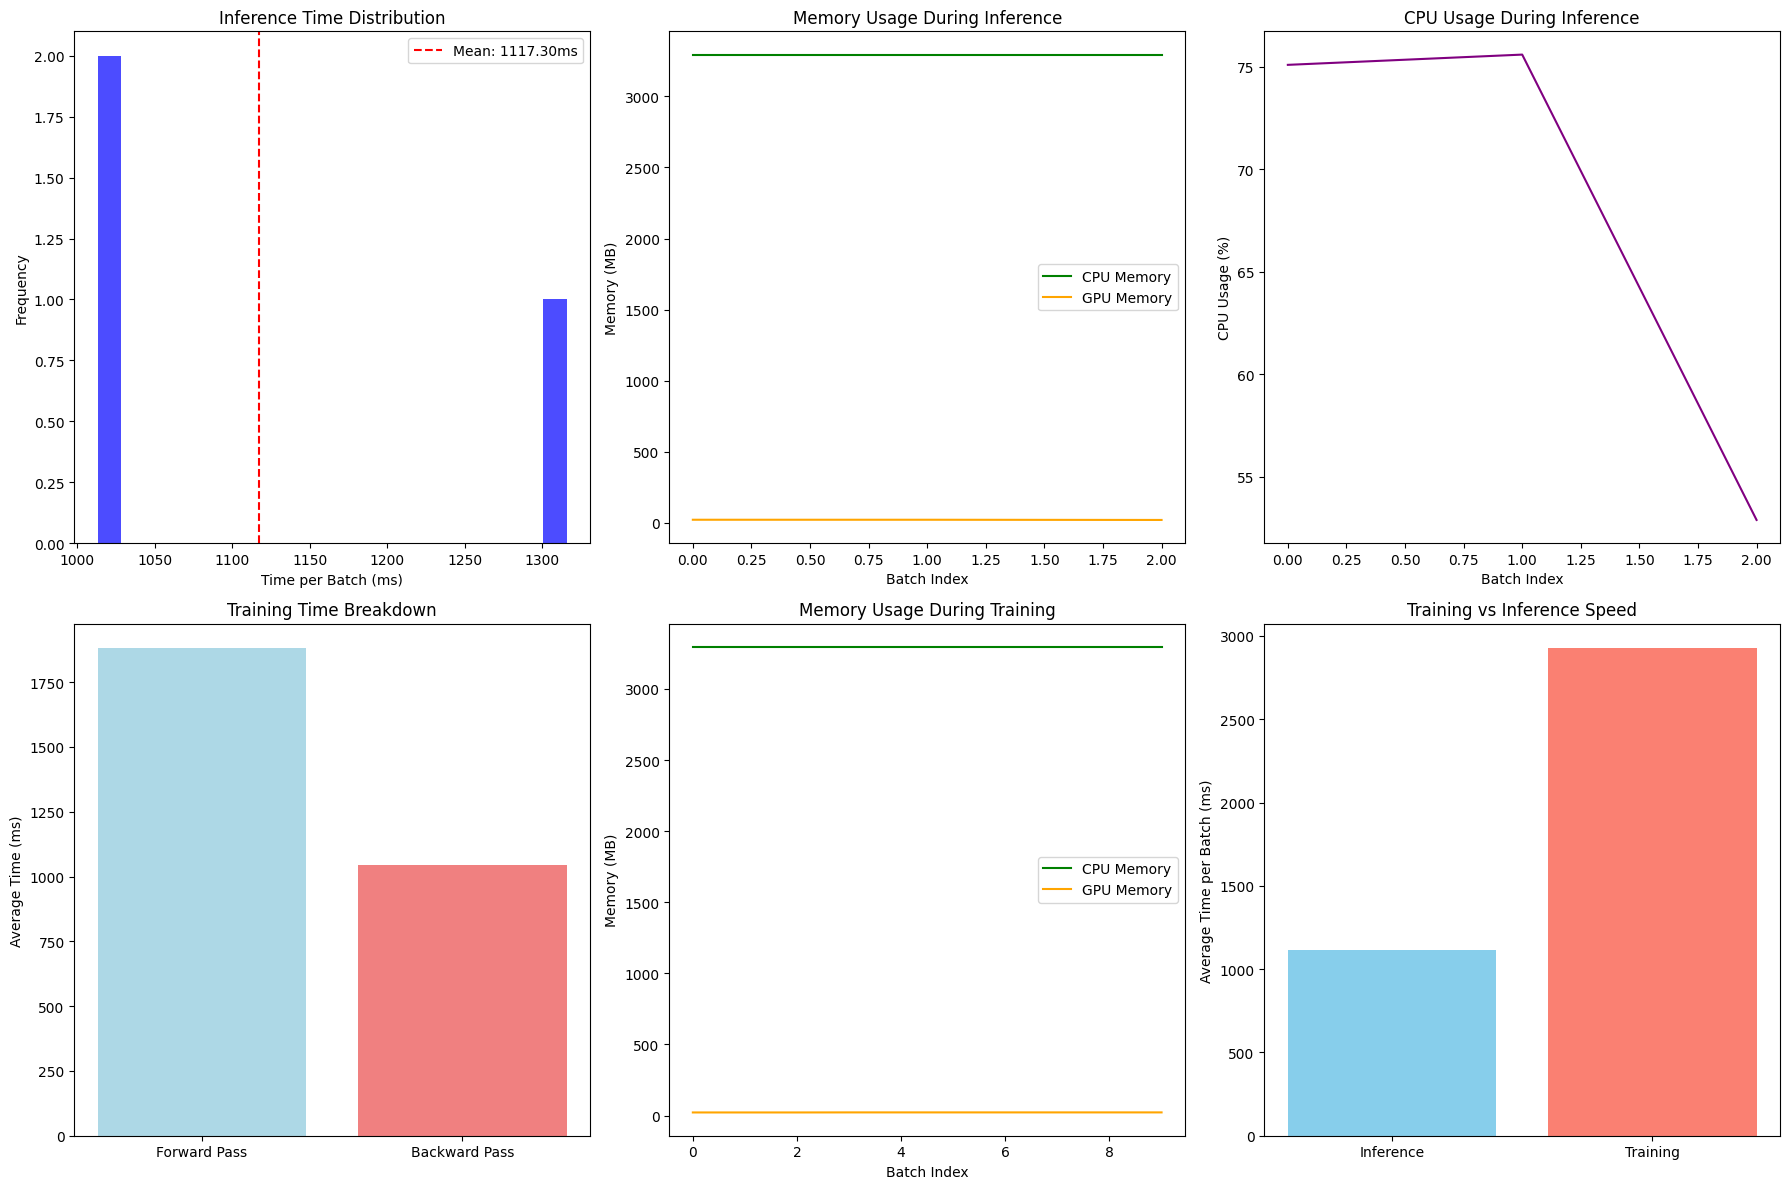


COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN

 INFERENCE PERFORMANCE:
  Average batch time: 1117.30 ± 140.34 ms
  Throughput: 23.9 samples/second
  Min/Max batch time: 1013.16 / 1315.69 ms
  CPU usage: 67.9%
  Peak CPU memory: 3294.2 MB
  Peak GPU memory: 21.6 MB

 TRAINING PERFORMANCE:
  Average batch time: 2926.54 ms
  Forward pass: 1881.09 ms
  Backward pass: 1045.15 ms
  Peak CPU memory: 3294.2 MB
  Peak GPU memory: 22.0 MB

 MODEL COMPLEXITY:
  Total parameters: 51,224
  Trainable parameters: 51,224
  Model size: 0.22 MB

  Estimated memory usage by batch size:
    batch_1: 1.1 MB
    batch_16: 14.3 MB
    batch_32: 28.3 MB
    batch_64: 56.5 MB


In [48]:
analysis_tae_snn = run_performance_evaluation(
    model=tae_snn_classifier,
    train_loader=tae_train_loader,
    val_loader=tae_val_loader,
    test_loader=tae_test_loader,
    device=device
)

###TAE SCNN

MODEL COMPLEXITY ANALYSIS
INFERENCE PERFORMANCE PROFILING
TRAINING PERFORMANCE PROFILING
STEP FORWARD ENCODING BENCHMARK


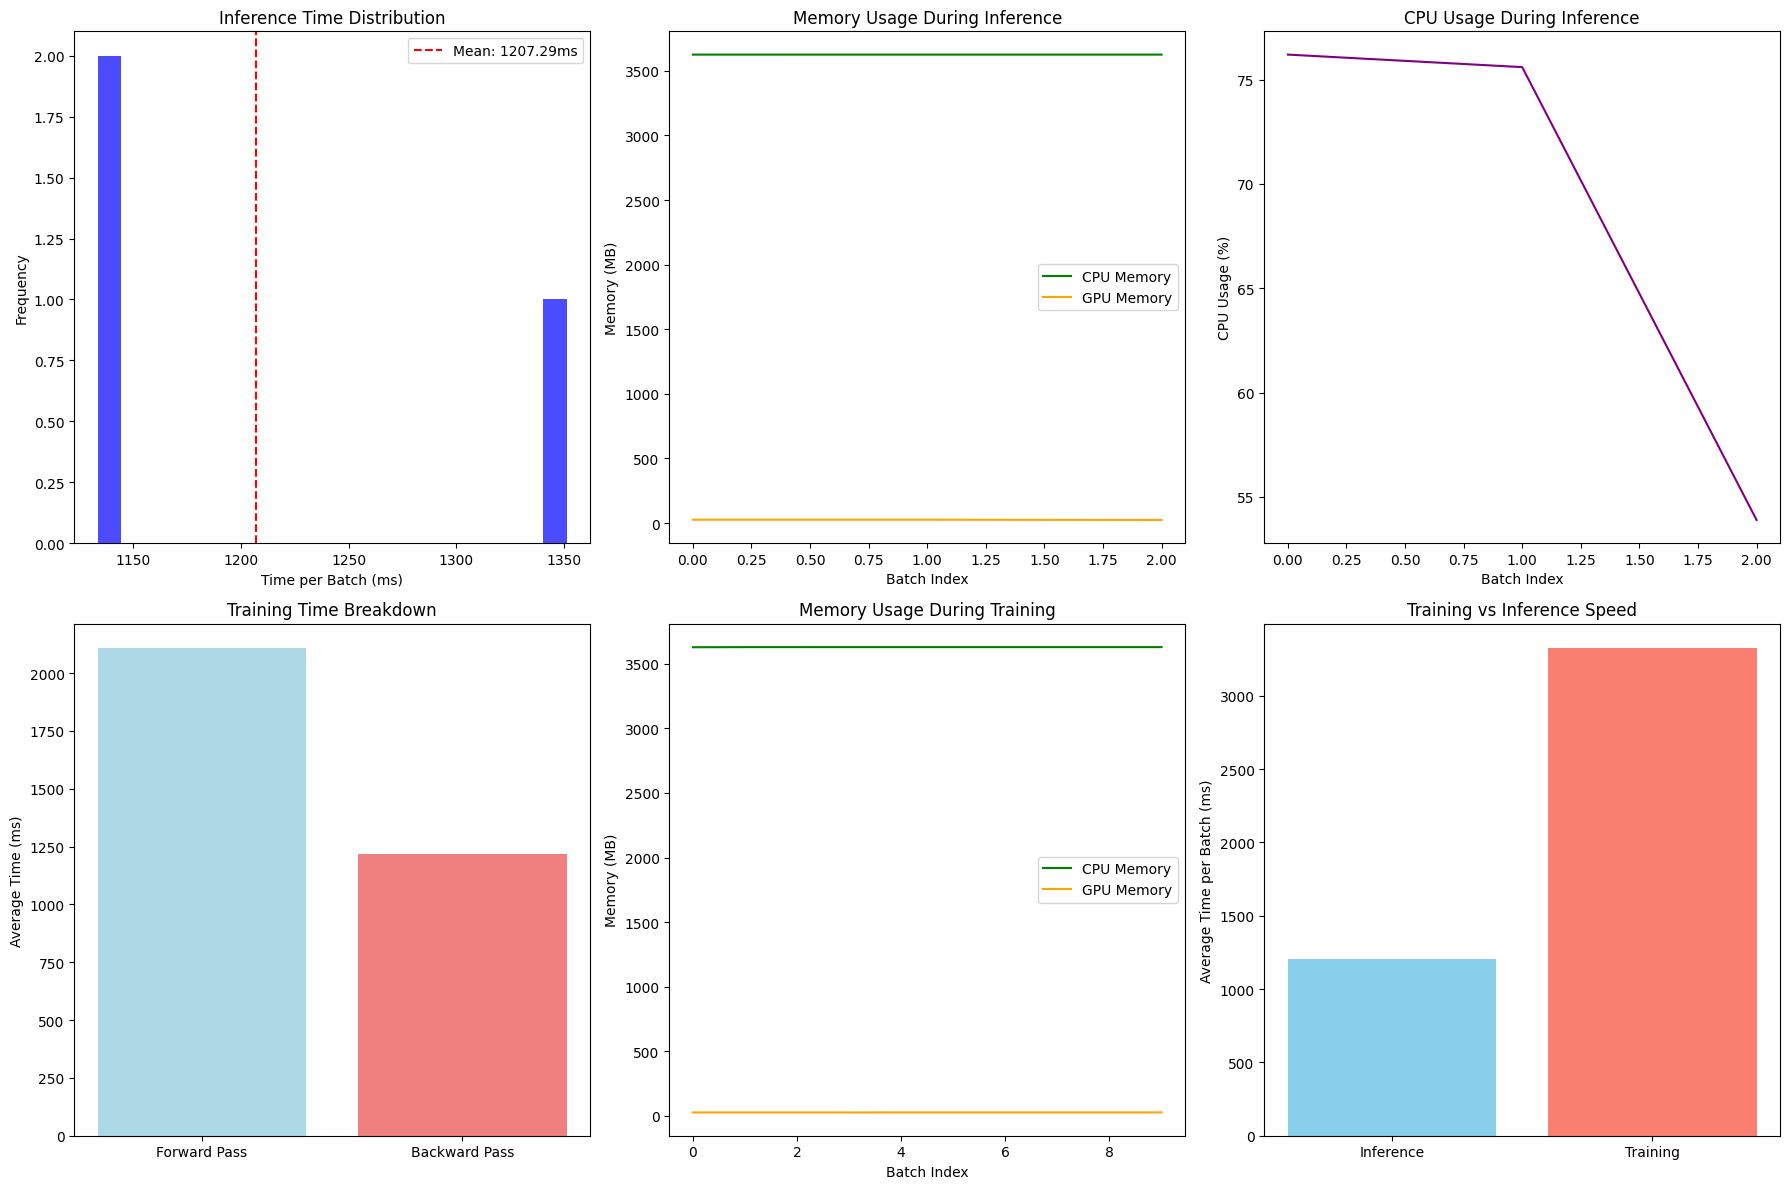


COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN

 INFERENCE PERFORMANCE:
  Average batch time: 1207.29 ± 101.74 ms
  Throughput: 22.1 samples/second
  Min/Max batch time: 1133.70 / 1351.16 ms
  CPU usage: 68.6%
  Peak CPU memory: 3626.2 MB
  Peak GPU memory: 26.1 MB

 TRAINING PERFORMANCE:
  Average batch time: 3324.47 ms
  Forward pass: 2107.84 ms
  Backward pass: 1216.43 ms
  Peak CPU memory: 3628.8 MB
  Peak GPU memory: 26.9 MB

 MODEL COMPLEXITY:
  Total parameters: 67,816
  Trainable parameters: 67,816
  Model size: 0.77 MB

  Estimated memory usage by batch size:
    batch_1: 1.6 MB
    batch_16: 14.8 MB
    batch_32: 28.9 MB
    batch_64: 57.0 MB


In [48]:
analysis_tae_scnn = run_performance_evaluation(
    model=tae_c_snn_model,
    train_loader=tae_train_loader,
    val_loader=tae_val_loader,
    test_loader=tae_test_loader,
    device=device
)

###Step Forward SNN

MODEL COMPLEXITY ANALYSIS
INFERENCE PERFORMANCE PROFILING
TRAINING PERFORMANCE PROFILING
STEP FORWARD ENCODING BENCHMARK


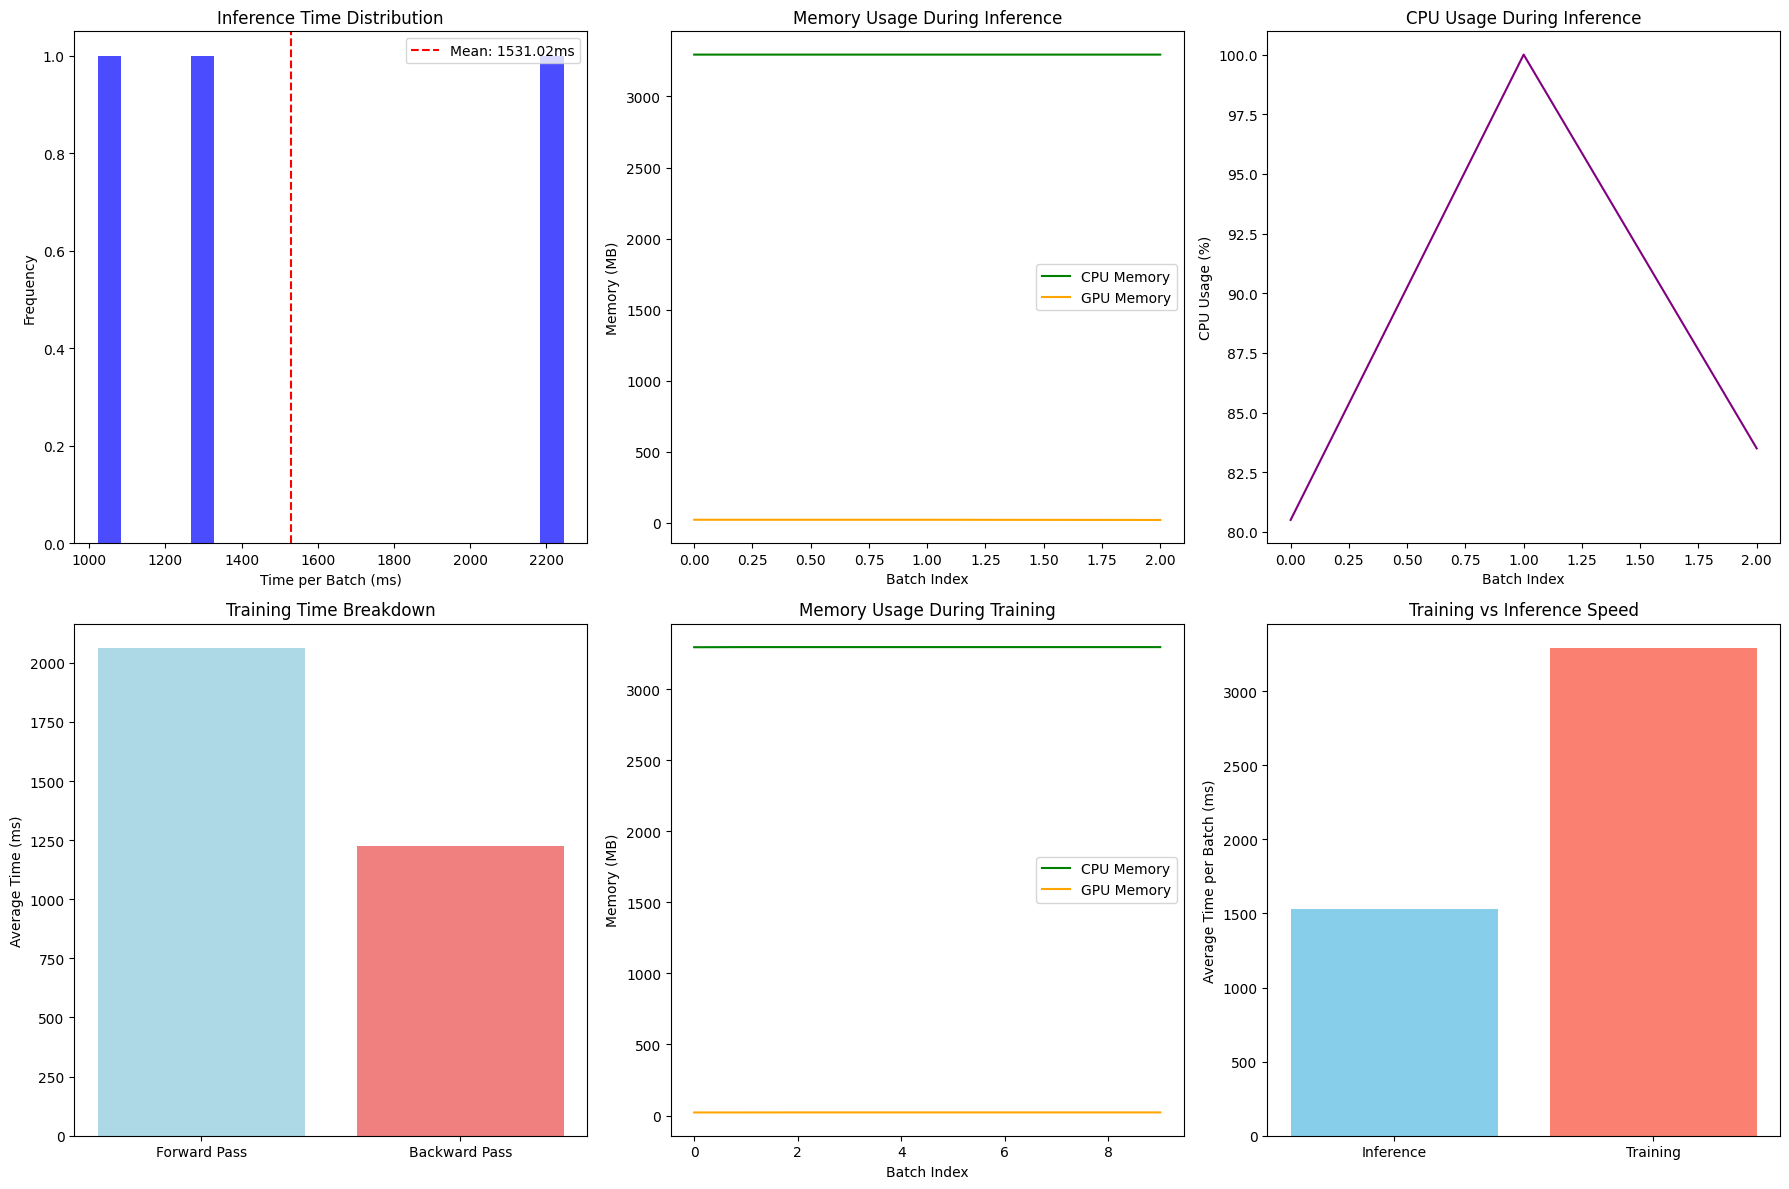


COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN

 INFERENCE PERFORMANCE:
  Average batch time: 1531.02 ± 520.49 ms
  Throughput: 17.4 samples/second
  Min/Max batch time: 1022.39 / 2246.13 ms
  CPU usage: 88.0%
  Peak CPU memory: 3294.8 MB
  Peak GPU memory: 21.6 MB

 TRAINING PERFORMANCE:
  Average batch time: 3289.39 ms
  Forward pass: 2061.78 ms
  Backward pass: 1227.29 ms
  Peak CPU memory: 3296.7 MB
  Peak GPU memory: 22.0 MB

 MODEL COMPLEXITY:
  Total parameters: 51,224
  Trainable parameters: 51,224
  Model size: 0.22 MB

  Estimated memory usage by batch size:
    batch_1: 1.1 MB
    batch_16: 14.3 MB
    batch_32: 28.3 MB
    batch_64: 56.5 MB


In [49]:
analysis_sf_snn = run_performance_evaluation(
    model=sf_snn_classifier,
    train_loader=sf_train_loader,
    val_loader=sf_val_loader,
    test_loader=sf_test_loader,
    device=device
)

###Step Forward SCNN

MODEL COMPLEXITY ANALYSIS
INFERENCE PERFORMANCE PROFILING
TRAINING PERFORMANCE PROFILING
STEP FORWARD ENCODING BENCHMARK


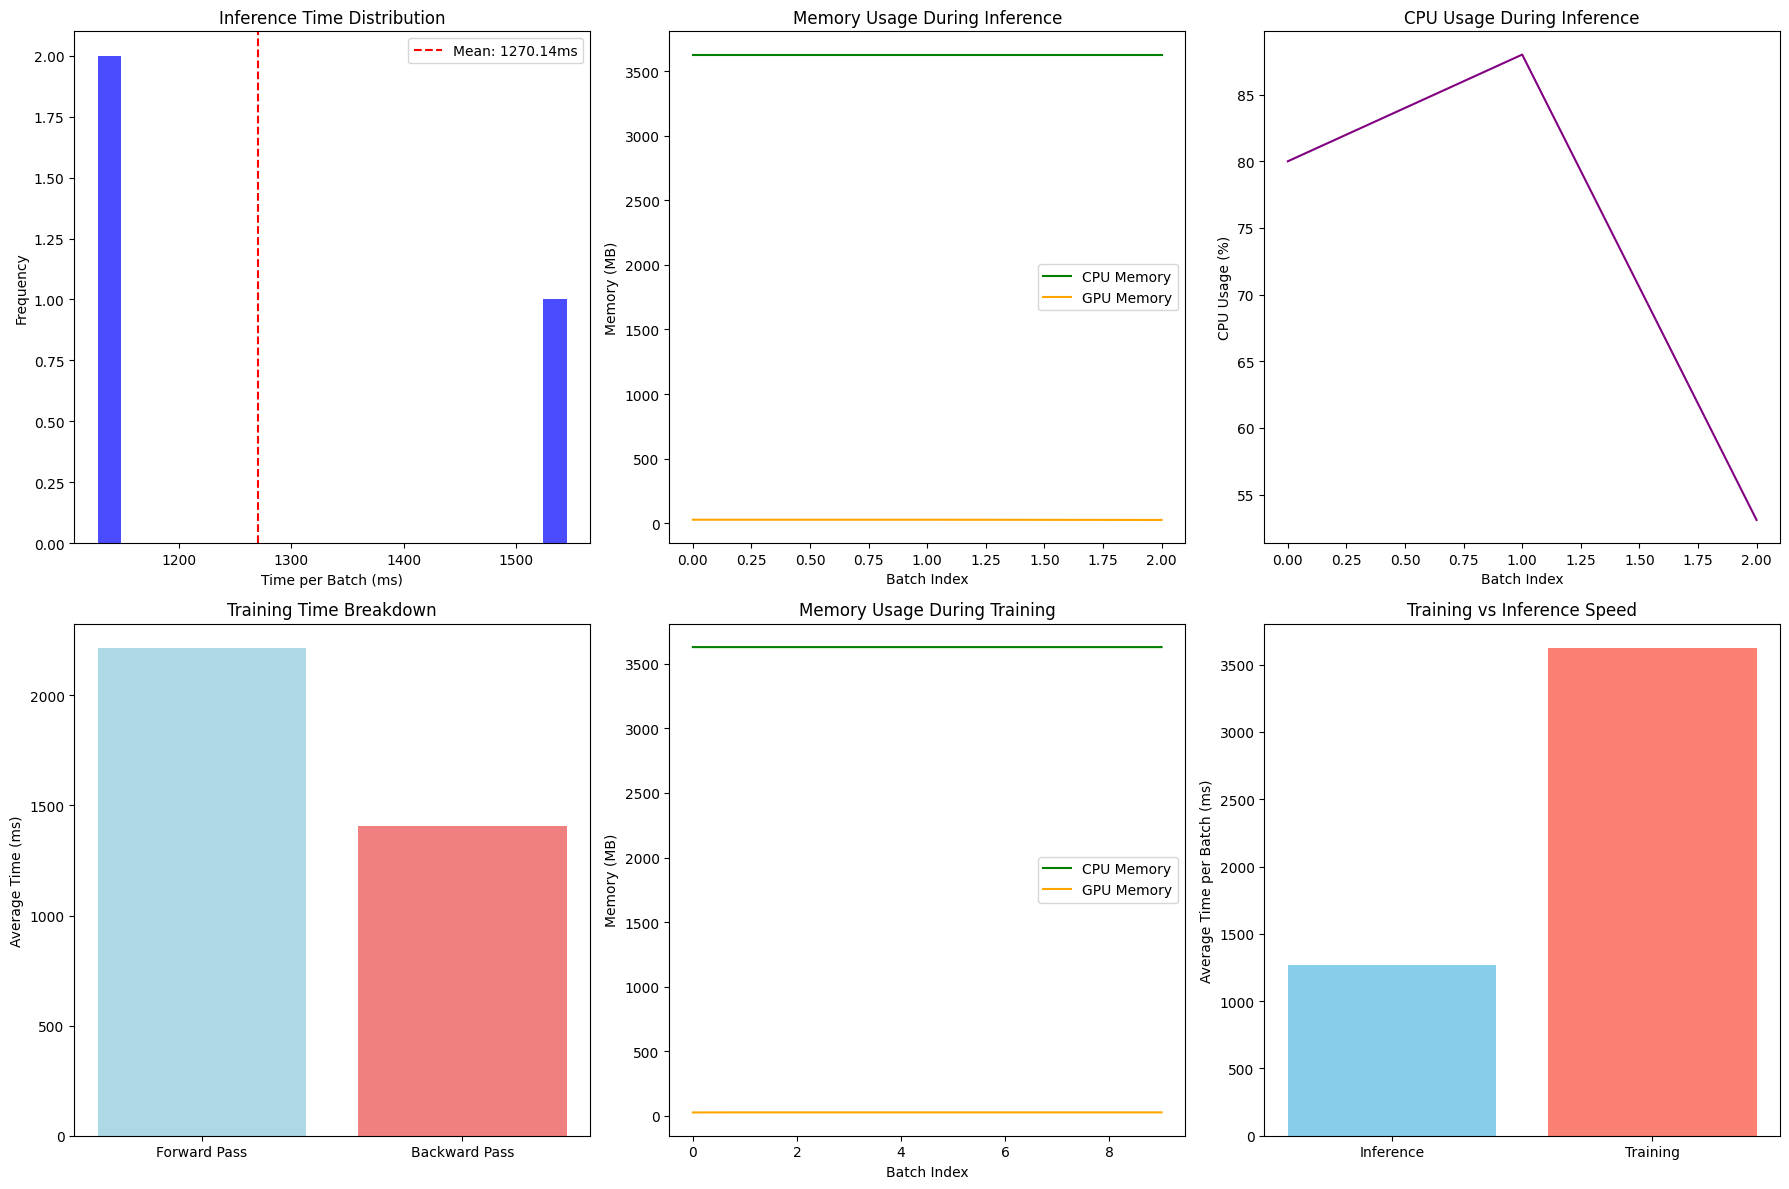


COMPREHENSIVE PERFORMANCE REPORT - STEP FORWARD SNN

 INFERENCE PERFORMANCE:
  Average batch time: 1270.14 ± 194.43 ms
  Throughput: 21.0 samples/second
  Min/Max batch time: 1127.51 / 1545.04 ms
  CPU usage: 73.7%
  Peak CPU memory: 3628.8 MB
  Peak GPU memory: 26.9 MB

 TRAINING PERFORMANCE:
  Average batch time: 3622.37 ms
  Forward pass: 2213.88 ms
  Backward pass: 1408.17 ms
  Peak CPU memory: 3628.8 MB
  Peak GPU memory: 27.4 MB

 MODEL COMPLEXITY:
  Total parameters: 67,816
  Trainable parameters: 67,816
  Model size: 0.51 MB

  Estimated memory usage by batch size:
    batch_1: 1.4 MB
    batch_16: 14.6 MB
    batch_32: 28.6 MB
    batch_64: 56.8 MB


In [49]:
analysis_sf_scnn = run_performance_evaluation(
    model=sf_c_snn_model,
    train_loader=sf_train_loader,
    val_loader=sf_val_loader,
    test_loader=sf_test_loader,
    device=device
)